In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as tt
from torch.autograd import Variable

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
IMAGE_CHANNEL = 1
INITIAL_CHANNEL = 4
Z_DIM = 100
G_HIDDEN = 64
X_DIM = 64
D_HIDDEN = 64
EPOCH_NUM = 5
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4

In [3]:
transform = tt.Compose([
    tt.Resize(64), # Reszie from 28x28 to 64x64
    tt.ToTensor(),
    #tt.Normalize((0.1307,), (0.3081,))
])

In [4]:
dataset = datasets.MNIST('.', train=True, transform = transform, download=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True)
# test_dataset = datasets.MNIST('.', train=False, transform = transform, download=False)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        
        return input.view(input.size()[0], -1).to(device) # for connecting conv layer and linear layer

    
class UnFlatten(nn.Module):
    def forward(self, input):
        
        return input.view(input.size()[0], 64, 2, 2).to(device) # for connecting linear layer and conv layer

class VAE(nn.Module):
    def __init__(self, image_channels= IMAGE_CHANNEL, output_channels= INITIAL_CHANNEL, h_dim=256, z_dim=16): # h_dim : last hidden dimension, z_dim : latent dimension
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, output_channels, kernel_size=3, stride=2, padding = 1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(),
            nn.Conv2d(output_channels, output_channels*2, kernel_size=3, stride=2, padding = 1),
            nn.BatchNorm2d(output_channels*2),
            nn.ReLU(),
            nn.Conv2d(output_channels*2, output_channels*4, kernel_size=3, stride=2, padding = 1),
            nn.BatchNorm2d(output_channels*4),
            nn.ReLU(),
            nn.Conv2d(output_channels*4, output_channels*8, kernel_size=3, stride=2, padding = 1),
            nn.BatchNorm2d(output_channels*8),
            nn.ReLU(),
            nn.Conv2d(output_channels*8, output_channels*16, kernel_size=3, stride=2, padding = 1),
            nn.BatchNorm2d(output_channels*16),
            nn.ReLU(),
            nn.Dropout(0.8),
            Flatten()
        )

        
        self.fc1 = nn.Linear(h_dim, z_dim).to(device) # for mu right before reparameterization
        self.fc2 = nn.Linear(h_dim, z_dim).to(device) # for logvar right before reparameterization

        self.fc3 = nn.Linear(z_dim, h_dim).to(device) # right before decoding starts
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(output_channels*16, output_channels*8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(output_channels*8),
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels*8, output_channels*4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(output_channels*4),
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels*4, output_channels*2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(output_channels*2),            
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels*2, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(output_channels),            
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels, image_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(image_channels),
            nn.Sigmoid() # so that make the range of values 0~1
        )
        
    def reparameterize(self, mu, logvar):

        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp # N(mu, std) ~ N(0, 1) * std + mu
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h) # never add activation functions here!
        #logvar = torch.clamp(logvar, min=-4, max=4) # prevent exploding of variance later on
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        return self.bottleneck(h)
        
    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x) # save mu and logvar
        z = self.decode(z) # decode reparameterized z
        return z, mu, logvar

In [6]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    #BCE = nn.MSELoss()
    #BCE = BCE(recon_x, x) # unless value range = [0, 1],
                           # use MSELoss since you cannot use BCELoss

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

In [7]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

model = VAE()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003) 
scheduler = StepLR(optimizer, step_size=20, gamma=0.9)  # decrease to 90% at every 20 epochs


Epoch 1/500: 100%|████████████████████████████| 118/118 [00:10<00:00, 11.09it/s]


Epoch [1/500], Loss: 271526.4375 (total loss), 270797.9375 (bce), 728.4951 (kld)
Mu range: -1.4436124563217163 ~ 1.1620980501174927, Logvar range: -1.610214114189148 ~ 0.004284668248146772
tensor(8)


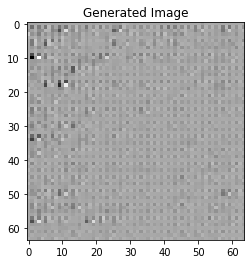

Epoch 2/500: 100%|████████████████████████████| 118/118 [00:09<00:00, 12.05it/s]

Epoch [2/500], Loss: 261820.8438 (total loss), 261271.3281 (bce), 549.5195 (kld)
Mu range: -1.0714775323867798 ~ 0.9555709362030029, Logvar range: -1.5205376148223877 ~ 0.10562403500080109
tensor(3)


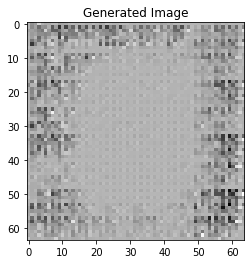

Epoch 3/500: 100%|████████████████████████████| 118/118 [00:13<00:00,  8.94it/s]


Epoch [3/500], Loss: 246653.4688 (total loss), 246067.2812 (bce), 586.1936 (kld)
Mu range: -0.7344861626625061 ~ 1.0581976175308228, Logvar range: -1.2117359638214111 ~ 0.4650445580482483
tensor(8)


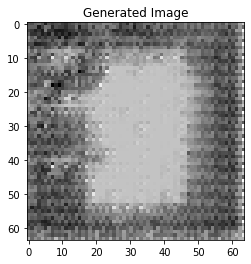

Epoch 4/500: 100%|████████████████████████████| 118/118 [00:11<00:00,  9.84it/s]


Epoch [4/500], Loss: 234386.0156 (total loss), 233519.7812 (bce), 866.2361 (kld)
Mu range: -0.9543523788452148 ~ 1.0028222799301147, Logvar range: -2.5291831493377686 ~ -0.3551800847053528
tensor(1)


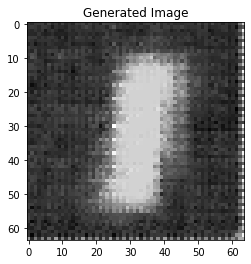

Epoch 5/500: 100%|████████████████████████████| 118/118 [00:11<00:00, 10.62it/s]


Epoch [5/500], Loss: 225261.5156 (total loss), 223658.1875 (bce), 1603.3295 (kld)
Mu range: -1.201185941696167 ~ 1.4223265647888184, Logvar range: -4.183966159820557 ~ -0.3837069571018219
tensor(9)


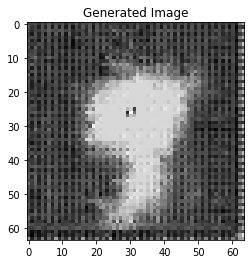

Epoch 6/500: 100%|████████████████████████████| 118/118 [00:10<00:00, 10.96it/s]


Epoch [6/500], Loss: 213853.4688 (total loss), 212097.1406 (bce), 1756.3292 (kld)
Mu range: -1.3286136388778687 ~ 1.0316237211227417, Logvar range: -3.865558624267578 ~ -0.7906814217567444
tensor(3)


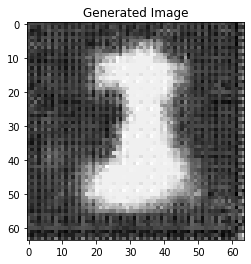

Epoch 7/500: 100%|████████████████████████████| 118/118 [00:12<00:00,  9.17it/s]

Epoch [7/500], Loss: 210475.7500 (total loss), 208568.0156 (bce), 1907.7400 (kld)
Mu range: -0.5813772678375244 ~ 0.8170381784439087, Logvar range: -1.8917723894119263 ~ 0.12367619574069977
tensor(7)


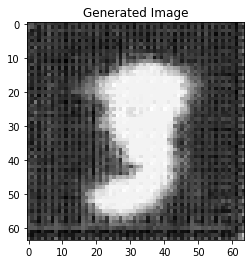

Epoch 8/500: 100%|████████████████████████████| 118/118 [00:11<00:00, 10.59it/s]


Epoch [8/500], Loss: 200078.6562 (total loss), 198194.4531 (bce), 1884.2034 (kld)
Mu range: -1.2459269762039185 ~ 0.6132669448852539, Logvar range: -4.369638919830322 ~ -1.0730935335159302
tensor(8)


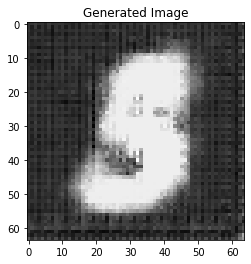

Epoch 9/500: 100%|████████████████████████████| 118/118 [00:10<00:00, 10.91it/s]

Epoch [9/500], Loss: 195089.4062 (total loss), 192957.3594 (bce), 2132.0413 (kld)
Mu range: -1.619699239730835 ~ 0.9134790897369385, Logvar range: -5.107859134674072 ~ -1.2708619832992554
tensor(4)


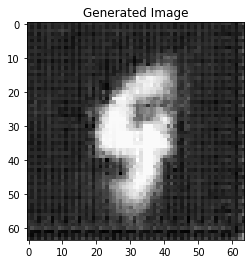

Epoch 10/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 10.91it/s]

Epoch [10/500], Loss: 190866.5781 (total loss), 188595.1719 (bce), 2271.4043 (kld)
Mu range: -0.7936990261077881 ~ 1.166239857673645, Logvar range: -4.085235118865967 ~ -1.1396900415420532
tensor(5)


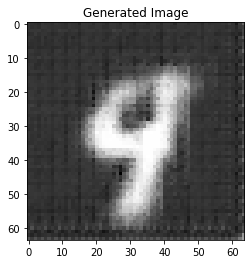

Epoch 11/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.06it/s]

Epoch [11/500], Loss: 186449.6875 (total loss), 184145.0469 (bce), 2304.6406 (kld)
Mu range: -1.5727250576019287 ~ 0.48541927337646484, Logvar range: -5.122217178344727 ~ -1.4109617471694946
tensor(1)


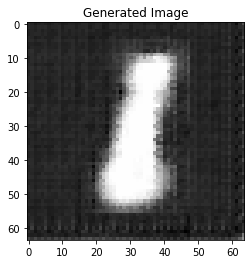

Epoch 12/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 11.40it/s]

Epoch [12/500], Loss: 181821.0625 (total loss), 179446.6250 (bce), 2374.4358 (kld)
Mu range: -2.102846145629883 ~ 2.439666271209717, Logvar range: -5.242740154266357 ~ -1.6561410427093506
tensor(7)


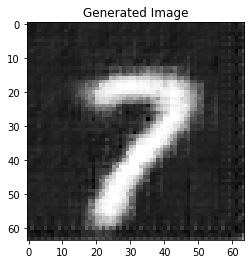

Epoch 13/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 11.18it/s]


Epoch [13/500], Loss: 184017.6719 (total loss), 181547.2812 (bce), 2470.3855 (kld)
Mu range: -2.493138551712036 ~ 1.8922079801559448, Logvar range: -5.484509468078613 ~ -1.419395923614502
tensor(6)


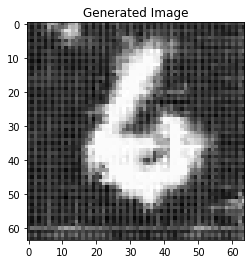

Epoch 14/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 11.03it/s]

Epoch [14/500], Loss: 173815.2969 (total loss), 171247.8125 (bce), 2567.4883 (kld)
Mu range: -1.6017494201660156 ~ 2.000227212905884, Logvar range: -3.509964942932129 ~ -0.7100276350975037
tensor(7)


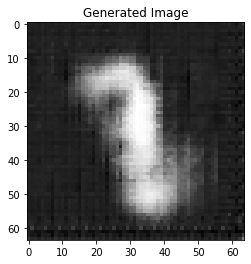

Epoch 15/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 11.02it/s]


Epoch [15/500], Loss: 164923.1719 (total loss), 162047.0312 (bce), 2876.1428 (kld)
Mu range: -2.017582654953003 ~ 0.8993585109710693, Logvar range: -4.216461181640625 ~ -1.3375916481018066
tensor(2)


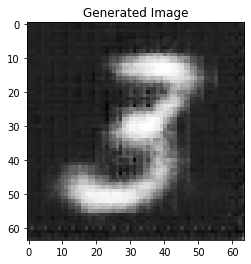

Epoch 16/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.35it/s]

Epoch [16/500], Loss: 159971.9062 (total loss), 157323.0469 (bce), 2648.8672 (kld)
Mu range: -1.1195176839828491 ~ 1.2520965337753296, Logvar range: -3.1731884479522705 ~ -0.8307333588600159
tensor(9)


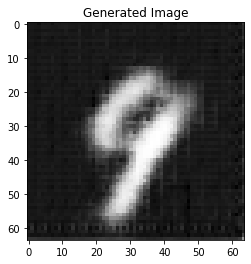

Epoch 17/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.56it/s]

Epoch [17/500], Loss: 159566.0469 (total loss), 156698.5938 (bce), 2867.4541 (kld)
Mu range: -1.8057737350463867 ~ 1.7515496015548706, Logvar range: -6.3900346755981445 ~ -1.4292486906051636
tensor(4)


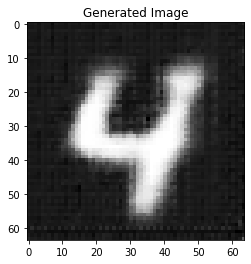

Epoch 18/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.01it/s]


Epoch [18/500], Loss: 183128.5469 (total loss), 180276.1250 (bce), 2852.4189 (kld)
Mu range: -1.6793487071990967 ~ 1.9932544231414795, Logvar range: -5.3705220222473145 ~ -1.1839497089385986
tensor(0)


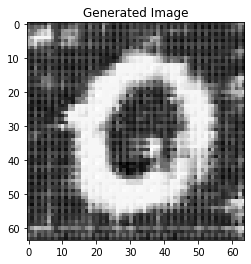

Epoch 19/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.34it/s]


Epoch [19/500], Loss: 153736.6250 (total loss), 150846.2188 (bce), 2890.4092 (kld)
Mu range: -0.7983668446540833 ~ 1.5049519538879395, Logvar range: -3.976850986480713 ~ -0.9143965244293213
tensor(9)


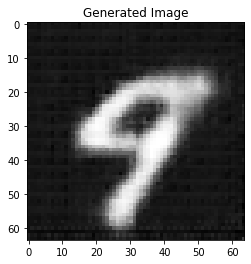

Epoch 20/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.39it/s]


Epoch [20/500], Loss: 150864.5469 (total loss), 148131.9062 (bce), 2732.6475 (kld)
Mu range: -1.296141505241394 ~ 1.564816951751709, Logvar range: -5.602603912353516 ~ -1.4340319633483887
tensor(7)


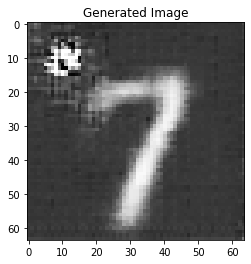

Epoch 21/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.29it/s]

Epoch [21/500], Loss: 157518.6875 (total loss), 154755.4531 (bce), 2763.2419 (kld)
Mu range: -2.686199188232422 ~ 4.102336406707764, Logvar range: -5.698610782623291 ~ -0.039984047412872314
tensor(0)


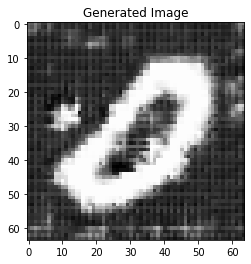

Epoch 22/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.44it/s]


Epoch [22/500], Loss: 145507.8594 (total loss), 142549.5312 (bce), 2958.3262 (kld)
Mu range: -2.131638526916504 ~ 3.9874300956726074, Logvar range: -8.188586235046387 ~ -2.607656478881836
tensor(9)


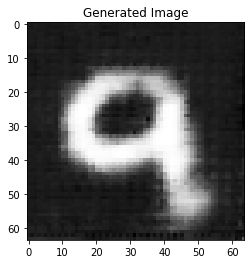

Epoch 23/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.08it/s]

Epoch [23/500], Loss: 142693.5781 (total loss), 139917.7812 (bce), 2775.7983 (kld)
Mu range: -1.3284599781036377 ~ 1.3152505159378052, Logvar range: -4.306612014770508 ~ -0.9190527200698853
tensor(1)


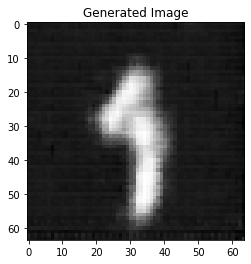

Epoch 24/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.29it/s]

Epoch [24/500], Loss: 144656.7500 (total loss), 141710.3438 (bce), 2946.4014 (kld)
Mu range: -1.8638941049575806 ~ 2.0093793869018555, Logvar range: -7.804331302642822 ~ -1.191948652267456
tensor(7)


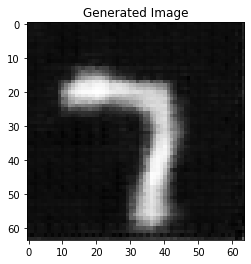

Epoch 25/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.13it/s]


Epoch [25/500], Loss: 172009.7344 (total loss), 168998.5781 (bce), 3011.1533 (kld)
Mu range: -1.2150310277938843 ~ 1.1298775672912598, Logvar range: -4.532414436340332 ~ -0.8356336951255798
tensor(3)


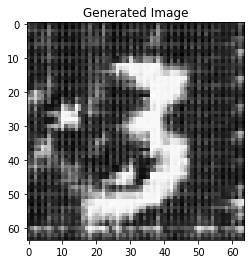

Epoch 26/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.15it/s]


Epoch [26/500], Loss: 137905.7969 (total loss), 134886.5000 (bce), 3019.2964 (kld)
Mu range: -1.3168569803237915 ~ 1.257365345954895, Logvar range: -3.8231723308563232 ~ -0.7533875703811646
tensor(7)


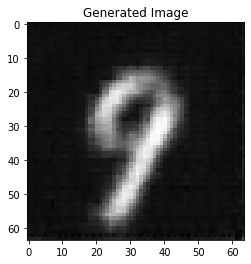

Epoch 27/500: 100%|███████████████████████████| 118/118 [00:12<00:00,  9.55it/s]


Epoch [27/500], Loss: 136140.5781 (total loss), 133261.9688 (bce), 2878.6074 (kld)
Mu range: -2.893275260925293 ~ 1.361145257949829, Logvar range: -6.535919666290283 ~ -0.9971014261245728
tensor(9)


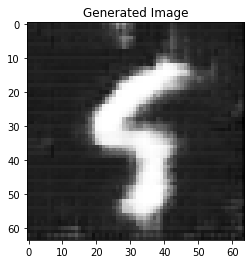

Epoch 28/500: 100%|███████████████████████████| 118/118 [00:12<00:00,  9.45it/s]


Epoch [28/500], Loss: 131679.1250 (total loss), 128662.2969 (bce), 3016.8281 (kld)
Mu range: -4.490384578704834 ~ 5.2625508308410645, Logvar range: -3.9669642448425293 ~ 0.5461835861206055
tensor(7)


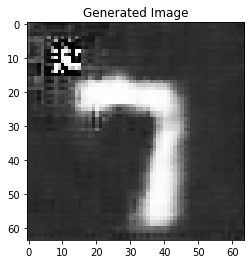

Epoch 29/500: 100%|███████████████████████████| 118/118 [00:12<00:00,  9.52it/s]

Epoch [29/500], Loss: 131800.8750 (total loss), 128886.7188 (bce), 2914.1531 (kld)
Mu range: -1.8238303661346436 ~ 2.4590938091278076, Logvar range: -5.9728264808654785 ~ -0.48595598340034485
tensor(6)


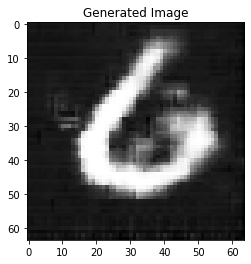

Epoch 30/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.34it/s]


Epoch [30/500], Loss: 128860.1797 (total loss), 125810.4141 (bce), 3049.7681 (kld)
Mu range: -1.6510611772537231 ~ 1.6591891050338745, Logvar range: -6.235106945037842 ~ -0.8273983001708984
tensor(3)


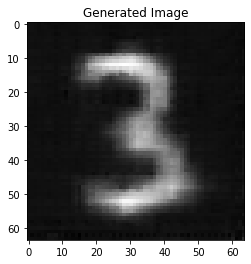

Epoch 31/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.36it/s]


Epoch [31/500], Loss: 128135.2266 (total loss), 125054.5156 (bce), 3080.7087 (kld)
Mu range: -2.3847994804382324 ~ 1.5496940612792969, Logvar range: -4.635496139526367 ~ -0.2604144215583801
tensor(9)


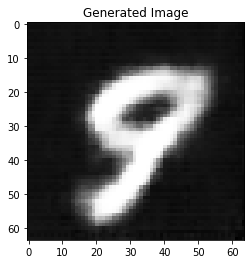

Epoch 32/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.26it/s]

Epoch [32/500], Loss: 127359.3281 (total loss), 124377.0469 (bce), 2982.2815 (kld)
Mu range: -2.6452317237854004 ~ 1.0244005918502808, Logvar range: -5.577219009399414 ~ -0.6250731348991394
tensor(3)


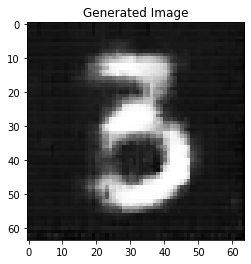

Epoch 33/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.30it/s]


Epoch [33/500], Loss: 126790.4531 (total loss), 123648.5156 (bce), 3141.9390 (kld)
Mu range: -1.0043257474899292 ~ 0.5788378715515137, Logvar range: -3.2649168968200684 ~ -0.6709471344947815
tensor(4)


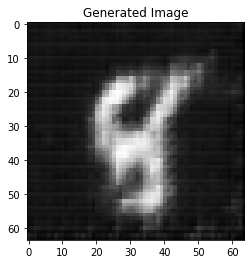

Epoch 34/500: 100%|███████████████████████████| 118/118 [00:11<00:00,  9.97it/s]

Epoch [34/500], Loss: 120802.8203 (total loss), 117674.0312 (bce), 3128.7866 (kld)
Mu range: -1.441886305809021 ~ 1.3640062808990479, Logvar range: -4.078146457672119 ~ -0.684195876121521
tensor(1)


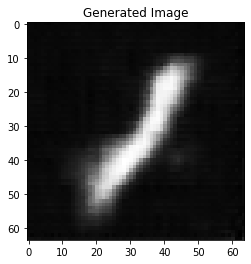

Epoch 35/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.41it/s]

Epoch [35/500], Loss: 163855.3750 (total loss), 160878.5938 (bce), 2976.7776 (kld)
Mu range: -1.3533424139022827 ~ 2.51189923286438, Logvar range: -5.079433441162109 ~ -0.564806342124939
tensor(2)


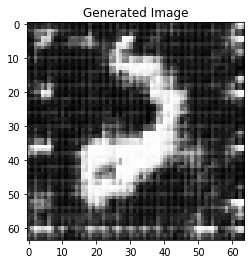

Epoch 36/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.42it/s]


Epoch [36/500], Loss: 135985.4844 (total loss), 133049.6562 (bce), 2935.8213 (kld)
Mu range: -2.5718841552734375 ~ 1.3033453226089478, Logvar range: -8.000713348388672 ~ -0.6198735237121582
tensor(8)


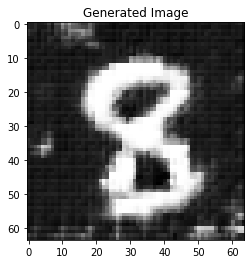

Epoch 37/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.16it/s]

Epoch [37/500], Loss: 116318.9219 (total loss), 113165.4922 (bce), 3153.4258 (kld)
Mu range: -1.4066392183303833 ~ 1.3796156644821167, Logvar range: -5.020220756530762 ~ -0.571134090423584
tensor(4)


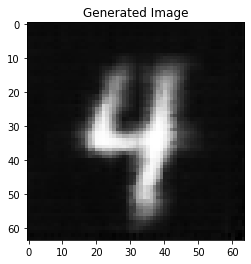

Epoch 38/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.18it/s]

Epoch [38/500], Loss: 113796.6016 (total loss), 110476.7578 (bce), 3319.8423 (kld)
Mu range: -1.4022130966186523 ~ 1.640400767326355, Logvar range: -4.7881574630737305 ~ -0.37364956736564636
tensor(1)


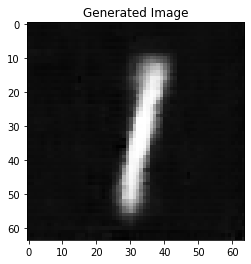

Epoch 39/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.31it/s]


Epoch [39/500], Loss: 116089.4062 (total loss), 112999.4688 (bce), 3089.9395 (kld)
Mu range: -1.2824548482894897 ~ 0.8989807963371277, Logvar range: -4.960825443267822 ~ -0.572163999080658
tensor(8)


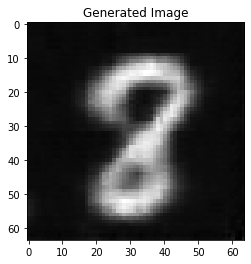

Epoch 40/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.52it/s]


Epoch [40/500], Loss: 114062.4688 (total loss), 110928.6484 (bce), 3133.8184 (kld)
Mu range: -1.5172120332717896 ~ 2.715700149536133, Logvar range: -7.707183837890625 ~ -0.16906562447547913
tensor(0)


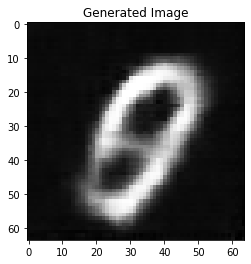

Epoch 41/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.27it/s]

Epoch [41/500], Loss: 112127.2812 (total loss), 109207.9219 (bce), 2919.3574 (kld)
Mu range: -2.87961483001709 ~ 1.0202128887176514, Logvar range: -6.653145790100098 ~ -0.3607805371284485
tensor(2)


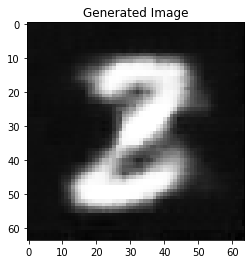

Epoch 42/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.12it/s]

Epoch [42/500], Loss: 109646.8359 (total loss), 106562.0547 (bce), 3084.7844 (kld)
Mu range: -1.105914831161499 ~ 1.0162464380264282, Logvar range: -6.353893280029297 ~ -0.29524844884872437
tensor(5)


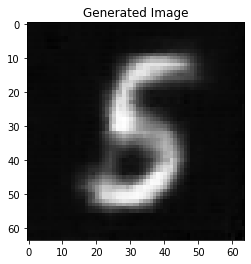

Epoch 43/500: 100%|███████████████████████████| 118/118 [00:11<00:00,  9.97it/s]


Epoch [43/500], Loss: 108114.1953 (total loss), 104889.5703 (bce), 3224.6221 (kld)
Mu range: -0.855410099029541 ~ 0.9163252711296082, Logvar range: -4.583360195159912 ~ -0.42243263125419617
tensor(9)


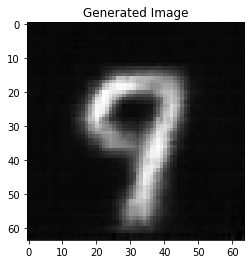

Epoch 44/500: 100%|███████████████████████████| 118/118 [00:11<00:00,  9.87it/s]


Epoch [44/500], Loss: 107879.8047 (total loss), 104652.5781 (bce), 3227.2288 (kld)
Mu range: -1.4494916200637817 ~ 2.1862220764160156, Logvar range: -5.9066314697265625 ~ -0.5661855936050415
tensor(9)


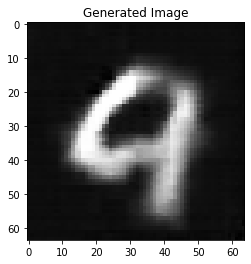

Epoch 45/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.13it/s]


Epoch [45/500], Loss: 108033.4531 (total loss), 104830.0234 (bce), 3203.4275 (kld)
Mu range: -0.858938992023468 ~ 1.7940170764923096, Logvar range: -5.308122158050537 ~ -0.2917696237564087
tensor(3)


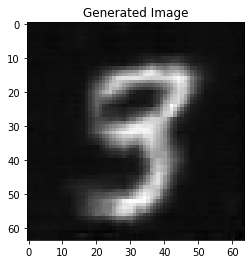

Epoch 46/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.11it/s]

Epoch [46/500], Loss: 105631.7109 (total loss), 102504.0938 (bce), 3127.6167 (kld)
Mu range: -3.124889373779297 ~ 1.612689733505249, Logvar range: -5.253317356109619 ~ -0.5138673782348633
tensor(5)


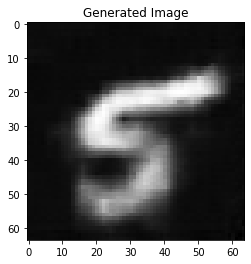

Epoch 47/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.06it/s]


Epoch [47/500], Loss: 129425.9062 (total loss), 126262.0312 (bce), 3163.8730 (kld)
Mu range: -2.329555034637451 ~ 1.0498653650283813, Logvar range: -8.021885871887207 ~ -0.25119590759277344
tensor(3)


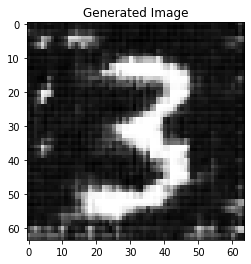

Epoch 48/500: 100%|███████████████████████████| 118/118 [00:11<00:00,  9.86it/s]


Epoch [48/500], Loss: 106483.4062 (total loss), 103628.1953 (bce), 2855.2104 (kld)
Mu range: -1.957092523574829 ~ 1.6204512119293213, Logvar range: -4.860762596130371 ~ -0.32685622572898865
tensor(9)


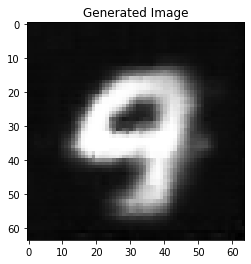

Epoch 49/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.26it/s]


Epoch [49/500], Loss: 104156.0938 (total loss), 101216.9844 (bce), 2939.1108 (kld)
Mu range: -2.270159959793091 ~ 1.6613212823867798, Logvar range: -6.649899959564209 ~ -0.36147773265838623
tensor(3)


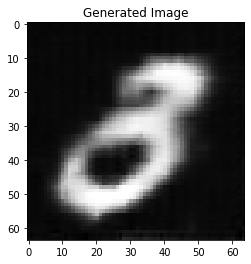

Epoch 50/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.33it/s]


Epoch [50/500], Loss: 103127.8984 (total loss), 99978.4375 (bce), 3149.4590 (kld)
Mu range: -3.7209882736206055 ~ 1.7880982160568237, Logvar range: -9.334110260009766 ~ -0.3118952810764313
tensor(8)


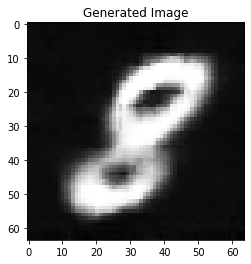

Epoch 51/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.24it/s]


Epoch [51/500], Loss: 100714.2500 (total loss), 97671.1875 (bce), 3043.0615 (kld)
Mu range: -2.2562525272369385 ~ 2.264997720718384, Logvar range: -7.047994136810303 ~ -0.23394596576690674
tensor(4)


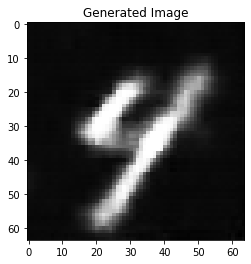

Epoch 52/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.28it/s]


Epoch [52/500], Loss: 98266.8125 (total loss), 95131.5781 (bce), 3135.2310 (kld)
Mu range: -1.2354178428649902 ~ 1.719196081161499, Logvar range: -6.19923734664917 ~ -0.43323826789855957
tensor(9)


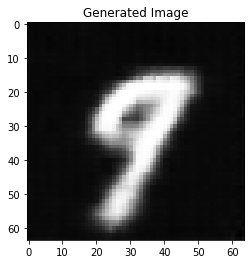

Epoch 53/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.01it/s]


Epoch [53/500], Loss: 97150.0547 (total loss), 94072.0781 (bce), 3077.9785 (kld)
Mu range: -0.9817769527435303 ~ 1.0353492498397827, Logvar range: -4.215462684631348 ~ -0.30433744192123413
tensor(8)


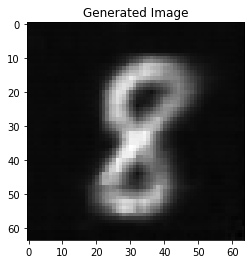

Epoch 54/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.34it/s]

Epoch [54/500], Loss: 132501.6406 (total loss), 129411.5156 (bce), 3090.1206 (kld)
Mu range: -1.9173070192337036 ~ 0.7076069116592407, Logvar range: -5.055756568908691 ~ -0.3186630308628082
tensor(9)


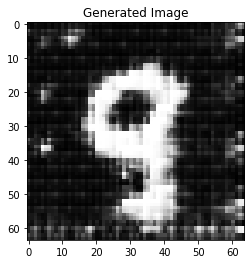

Epoch 55/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.54it/s]

Epoch [55/500], Loss: 96347.1328 (total loss), 93300.5547 (bce), 3046.5796 (kld)
Mu range: -1.6344609260559082 ~ 3.5783298015594482, Logvar range: -6.78024959564209 ~ -0.28737783432006836
tensor(2)


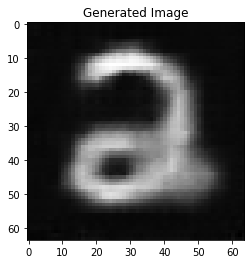

Epoch 56/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.20it/s]


Epoch [56/500], Loss: 97442.1875 (total loss), 94378.7812 (bce), 3063.4092 (kld)
Mu range: -1.5547609329223633 ~ 1.8041210174560547, Logvar range: -4.397988796234131 ~ -0.3635868430137634
tensor(2)


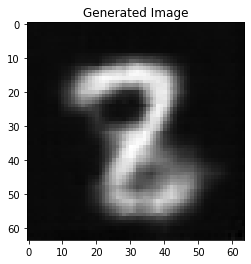

Epoch 57/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.24it/s]

Epoch [57/500], Loss: 96491.3516 (total loss), 93519.2500 (bce), 2972.1035 (kld)
Mu range: -1.3522411584854126 ~ 3.837542772293091, Logvar range: -7.3568220138549805 ~ -0.017836153507232666
tensor(0)


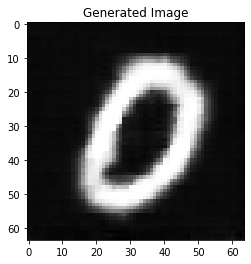

Epoch 58/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.28it/s]

Epoch [58/500], Loss: 96151.7344 (total loss), 93074.2578 (bce), 3077.4731 (kld)
Mu range: -4.024102687835693 ~ 2.429682493209839, Logvar range: -9.455954551696777 ~ -0.15714700520038605
tensor(5)


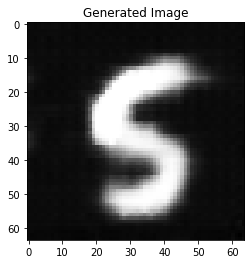

Epoch 59/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.28it/s]


Epoch [59/500], Loss: 95622.3516 (total loss), 92497.2031 (bce), 3125.1458 (kld)
Mu range: -0.9429253935813904 ~ 0.5469012260437012, Logvar range: -4.002524375915527 ~ -0.31621628999710083
tensor(4)


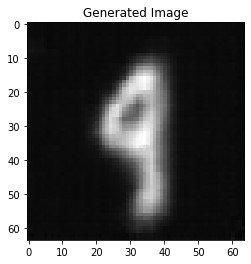

Epoch 60/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.51it/s]


Epoch [60/500], Loss: 98012.2656 (total loss), 94886.1172 (bce), 3126.1494 (kld)
Mu range: -1.6558970212936401 ~ 1.1688755750656128, Logvar range: -4.508663177490234 ~ -0.25058677792549133
tensor(5)


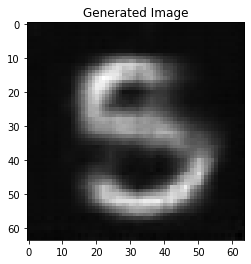

Epoch 61/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.37it/s]


Epoch [61/500], Loss: 98190.7109 (total loss), 95364.2734 (bce), 2826.4412 (kld)
Mu range: -0.6817403435707092 ~ 0.85536789894104, Logvar range: -3.761129379272461 ~ -0.18283367156982422
tensor(7)


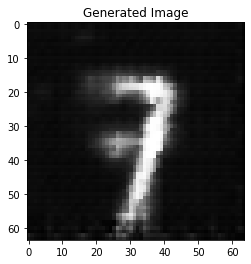

Epoch 62/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.19it/s]


Epoch [62/500], Loss: 90487.5859 (total loss), 87537.1094 (bce), 2950.4746 (kld)
Mu range: -0.8603077530860901 ~ 1.1731643676757812, Logvar range: -4.679401874542236 ~ -0.21495740115642548
tensor(9)


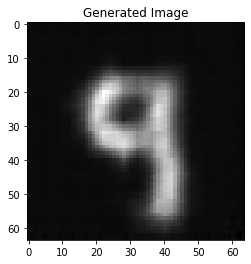

Epoch 63/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.07it/s]


Epoch [63/500], Loss: 89543.2812 (total loss), 86444.0859 (bce), 3099.1914 (kld)
Mu range: -1.4233717918395996 ~ 2.975264310836792, Logvar range: -6.605622291564941 ~ -0.23195207118988037
tensor(3)


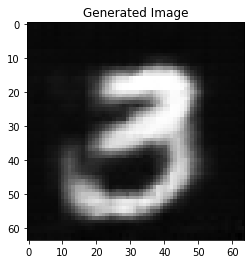

Epoch 64/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.49it/s]


Epoch [64/500], Loss: 91424.2891 (total loss), 88540.1016 (bce), 2884.1892 (kld)
Mu range: -2.7690131664276123 ~ 1.6714259386062622, Logvar range: -7.160880088806152 ~ -0.12197501957416534
tensor(1)


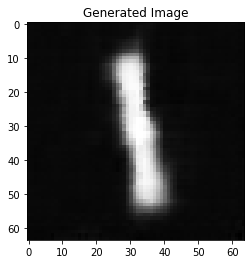

Epoch 65/500: 100%|███████████████████████████| 118/118 [00:12<00:00,  9.54it/s]

Epoch [65/500], Loss: 96883.0781 (total loss), 93863.0156 (bce), 3020.0649 (kld)
Mu range: -2.546433687210083 ~ 2.8981213569641113, Logvar range: -4.272635459899902 ~ -0.08206935226917267
tensor(6)


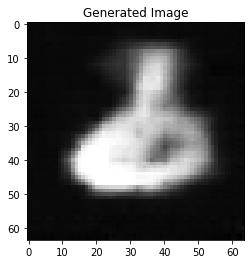

Epoch 66/500: 100%|███████████████████████████| 118/118 [00:12<00:00,  9.64it/s]

Epoch [66/500], Loss: 93714.6641 (total loss), 90568.0859 (bce), 3146.5759 (kld)
Mu range: -1.225008487701416 ~ 1.2143914699554443, Logvar range: -4.3232316970825195 ~ -0.34179744124412537
tensor(4)


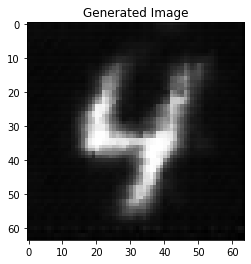

Epoch 67/500: 100%|███████████████████████████| 118/118 [00:12<00:00,  9.32it/s]


Epoch [67/500], Loss: 92057.6953 (total loss), 88948.0312 (bce), 3109.6628 (kld)
Mu range: -2.1291661262512207 ~ 0.6685428619384766, Logvar range: -5.3033294677734375 ~ -0.12453977763652802
tensor(6)


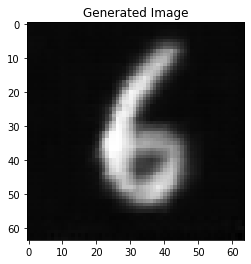

Epoch 68/500: 100%|███████████████████████████| 118/118 [00:11<00:00,  9.98it/s]


Epoch [68/500], Loss: 91992.9141 (total loss), 89039.2344 (bce), 2953.6833 (kld)
Mu range: -2.2118473052978516 ~ 1.859095573425293, Logvar range: -4.714053630828857 ~ -0.12876403331756592
tensor(3)


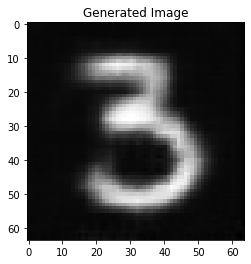

Epoch 69/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.16it/s]


Epoch [69/500], Loss: 89242.4609 (total loss), 86240.3906 (bce), 3002.0688 (kld)
Mu range: -2.2917051315307617 ~ 1.6919581890106201, Logvar range: -5.310955047607422 ~ -0.15285345911979675
tensor(0)


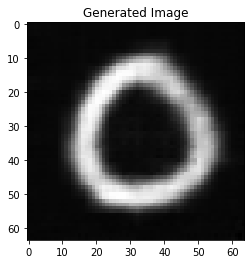

Epoch 70/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.01it/s]


Epoch [70/500], Loss: 122098.3594 (total loss), 119209.0859 (bce), 2889.2766 (kld)
Mu range: -4.479229927062988 ~ 2.0168683528900146, Logvar range: -7.726986885070801 ~ -0.1241491436958313
tensor(2)


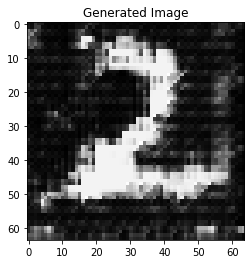

Epoch 71/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.15it/s]


Epoch [71/500], Loss: 111178.1719 (total loss), 108142.7422 (bce), 3035.4287 (kld)
Mu range: -1.6059964895248413 ~ 1.836719274520874, Logvar range: -6.131558418273926 ~ -0.15060587227344513
tensor(9)


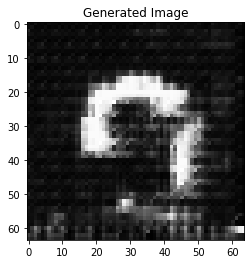

Epoch 72/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.31it/s]


Epoch [72/500], Loss: 86636.6250 (total loss), 83522.7812 (bce), 3113.8423 (kld)
Mu range: -0.9778717160224915 ~ 1.4794111251831055, Logvar range: -4.283147811889648 ~ -0.2911032438278198
tensor(6)


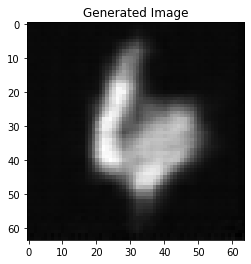

Epoch 73/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.49it/s]


Epoch [73/500], Loss: 85800.0391 (total loss), 82737.3125 (bce), 3062.7280 (kld)
Mu range: -1.457419514656067 ~ 1.4825458526611328, Logvar range: -6.867926597595215 ~ -0.22677786648273468
tensor(3)


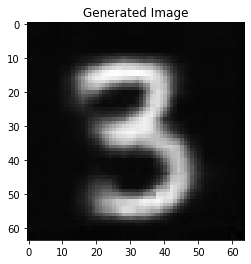

Epoch 74/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.39it/s]


Epoch [74/500], Loss: 84600.6328 (total loss), 81767.2891 (bce), 2833.3423 (kld)
Mu range: -1.951088309288025 ~ 1.7558581829071045, Logvar range: -6.082295894622803 ~ -0.09331528842449188
tensor(6)


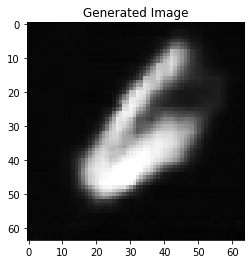

Epoch 75/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.32it/s]

Epoch [75/500], Loss: 88060.6641 (total loss), 85265.9297 (bce), 2794.7368 (kld)
Mu range: -1.4819316864013672 ~ 1.4437534809112549, Logvar range: -5.436193466186523 ~ -0.16411633789539337
tensor(5)


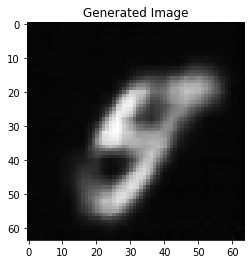

Epoch 76/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.20it/s]

Epoch [76/500], Loss: 86900.0625 (total loss), 83853.3125 (bce), 3046.7539 (kld)
Mu range: -1.5724560022354126 ~ 2.2309699058532715, Logvar range: -5.888069152832031 ~ -0.2838907837867737
tensor(0)


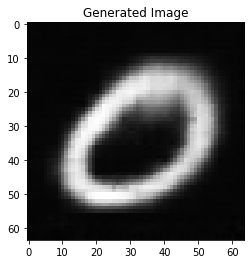

Epoch 77/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.26it/s]

Epoch [77/500], Loss: 86295.4922 (total loss), 83170.3828 (bce), 3125.1104 (kld)
Mu range: -2.687661647796631 ~ 1.3319644927978516, Logvar range: -6.557368755340576 ~ -0.15483775734901428
tensor(3)


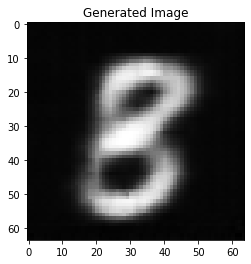

Epoch 78/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.19it/s]


Epoch [78/500], Loss: 85972.9375 (total loss), 82783.3906 (bce), 3189.5447 (kld)
Mu range: -2.0072269439697266 ~ 3.907921552658081, Logvar range: -7.241321563720703 ~ -0.19590426981449127
tensor(2)


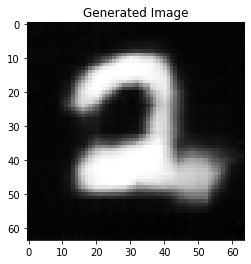

Epoch 79/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.40it/s]


Epoch [79/500], Loss: 86317.8359 (total loss), 83350.8516 (bce), 2966.9844 (kld)
Mu range: -2.0531222820281982 ~ 0.7577356696128845, Logvar range: -6.439273834228516 ~ -0.05475166440010071
tensor(1)


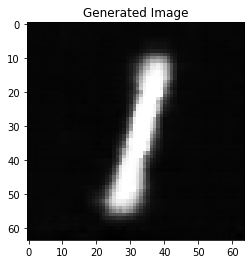

Epoch 80/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.04it/s]


Epoch [80/500], Loss: 84803.8438 (total loss), 81787.2500 (bce), 3016.5898 (kld)
Mu range: -1.3486627340316772 ~ 1.7642825841903687, Logvar range: -5.9443206787109375 ~ -0.24549227952957153
tensor(6)


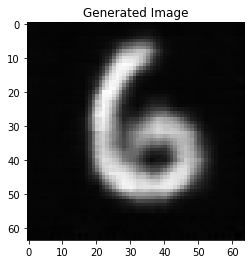

Epoch 81/500: 100%|███████████████████████████| 118/118 [00:11<00:00,  9.97it/s]


Epoch [81/500], Loss: 81321.4375 (total loss), 78269.4688 (bce), 3051.9717 (kld)
Mu range: -2.363429546356201 ~ 2.1556684970855713, Logvar range: -7.2148919105529785 ~ -0.0933888703584671
tensor(6)


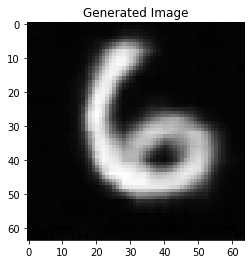

Epoch 82/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.18it/s]


Epoch [82/500], Loss: 80768.7812 (total loss), 77937.3203 (bce), 2831.4590 (kld)
Mu range: -1.6441518068313599 ~ 1.3975414037704468, Logvar range: -6.401392936706543 ~ -0.252380907535553
tensor(8)


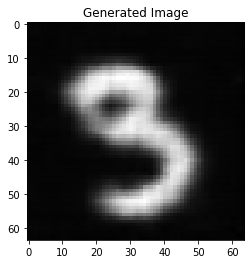

Epoch 83/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.20it/s]


Epoch [83/500], Loss: 81942.8828 (total loss), 78917.7188 (bce), 3025.1626 (kld)
Mu range: -1.3046293258666992 ~ 1.9737939834594727, Logvar range: -6.565385818481445 ~ -0.24790272116661072
tensor(9)


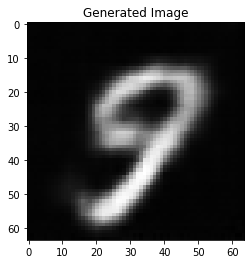

Epoch 84/500: 100%|███████████████████████████| 118/118 [00:12<00:00,  9.71it/s]


Epoch [84/500], Loss: 83008.7188 (total loss), 79991.7969 (bce), 3016.9185 (kld)
Mu range: -3.824936628341675 ~ 3.0499420166015625, Logvar range: -6.736409664154053 ~ 0.00047728419303894043
tensor(2)


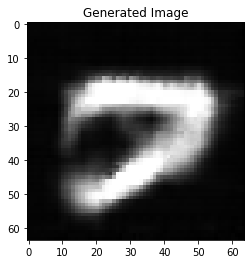

Epoch 85/500: 100%|███████████████████████████| 118/118 [00:12<00:00,  9.73it/s]


Epoch [85/500], Loss: 80197.4688 (total loss), 77312.2500 (bce), 2885.2148 (kld)
Mu range: -2.577812433242798 ~ 4.738269329071045, Logvar range: -6.2239089012146 ~ -0.055071622133255005
tensor(0)


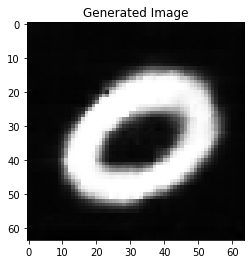

Epoch 86/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.01it/s]

Epoch [86/500], Loss: 81181.1016 (total loss), 78146.8516 (bce), 3034.2529 (kld)
Mu range: -1.3903374671936035 ~ 2.0662763118743896, Logvar range: -5.857601165771484 ~ -0.13838106393814087
tensor(5)


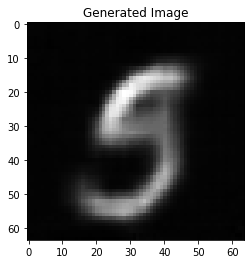

Epoch 87/500: 100%|███████████████████████████| 118/118 [00:12<00:00,  9.67it/s]


Epoch [87/500], Loss: 88147.4609 (total loss), 85296.6406 (bce), 2850.8179 (kld)
Mu range: -2.362122058868408 ~ 1.9854172468185425, Logvar range: -6.737063884735107 ~ -0.15332292020320892
tensor(0)


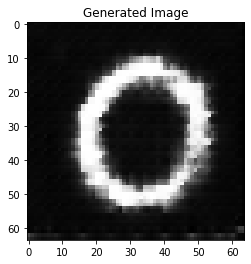

Epoch 88/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.12it/s]


Epoch [88/500], Loss: 80462.9766 (total loss), 77428.6953 (bce), 3034.2822 (kld)
Mu range: -1.3565082550048828 ~ 2.1431055068969727, Logvar range: -6.198990821838379 ~ -0.05790887773036957
tensor(4)


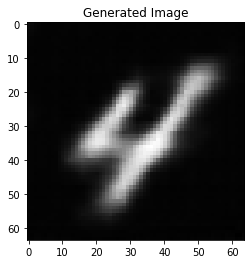

Epoch 89/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.05it/s]


Epoch [89/500], Loss: 109415.5000 (total loss), 106475.6797 (bce), 2939.8242 (kld)
Mu range: -2.180408477783203 ~ 2.7503888607025146, Logvar range: -7.2300615310668945 ~ 0.0367274284362793
tensor(6)


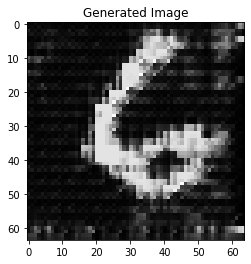

Epoch 90/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.06it/s]


Epoch [90/500], Loss: 77744.9844 (total loss), 74852.8750 (bce), 2892.1099 (kld)
Mu range: -1.3701459169387817 ~ 0.5655582547187805, Logvar range: -4.806665420532227 ~ -0.22775903344154358
tensor(8)


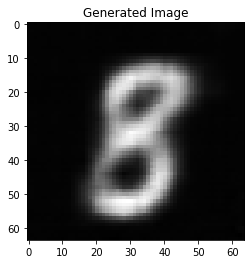

Epoch 91/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.38it/s]


Epoch [91/500], Loss: 78209.7578 (total loss), 75085.0703 (bce), 3124.6895 (kld)
Mu range: -4.277960300445557 ~ 2.5212998390197754, Logvar range: -8.562615394592285 ~ 0.07791167497634888
tensor(2)


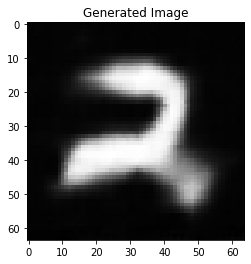

Epoch 92/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 10.88it/s]

Epoch [92/500], Loss: 79685.9922 (total loss), 76703.5156 (bce), 2982.4771 (kld)
Mu range: -1.6396052837371826 ~ 3.000328540802002, Logvar range: -6.225681304931641 ~ -0.1396237164735794
tensor(0)


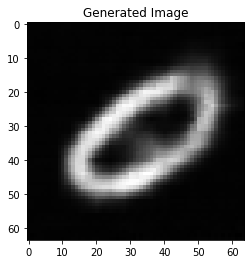

Epoch 93/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.30it/s]


Epoch [93/500], Loss: 79329.7578 (total loss), 76278.0703 (bce), 3051.6899 (kld)
Mu range: -1.0286113023757935 ~ 0.9073339700698853, Logvar range: -5.543551445007324 ~ -0.08758372068405151
tensor(1)


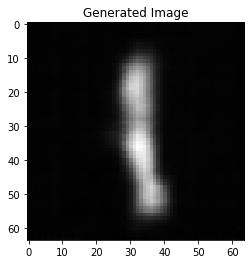

Epoch 94/500: 100%|███████████████████████████| 118/118 [00:12<00:00,  9.78it/s]


Epoch [94/500], Loss: 77952.6484 (total loss), 74949.3828 (bce), 3003.2673 (kld)
Mu range: -1.3379716873168945 ~ 1.9791691303253174, Logvar range: -5.232012748718262 ~ -0.10637001693248749
tensor(7)


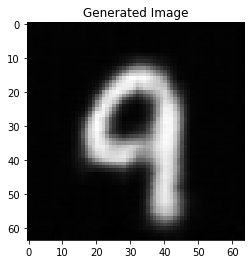

Epoch 95/500: 100%|███████████████████████████| 118/118 [00:12<00:00,  9.62it/s]

Epoch [95/500], Loss: 75621.5156 (total loss), 72566.6641 (bce), 3054.8506 (kld)
Mu range: -0.8651958703994751 ~ 0.5123164057731628, Logvar range: -4.155792236328125 ~ -0.1813001036643982
tensor(4)


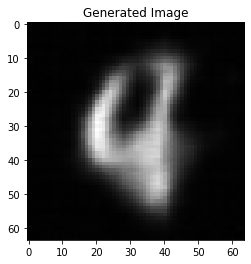

Epoch 96/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.16it/s]


Epoch [96/500], Loss: 74346.8047 (total loss), 71372.5547 (bce), 2974.2517 (kld)
Mu range: -1.1201810836791992 ~ 1.1592944860458374, Logvar range: -5.521476745605469 ~ -0.19674360752105713
tensor(7)


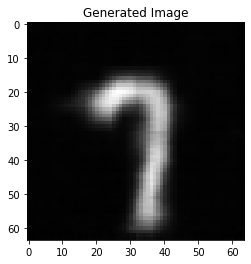

Epoch 97/500: 100%|███████████████████████████| 118/118 [00:11<00:00, 10.70it/s]

Epoch [97/500], Loss: 83576.5938 (total loss), 80602.2188 (bce), 2974.3772 (kld)
Mu range: -1.7690109014511108 ~ 1.2142099142074585, Logvar range: -5.6497931480407715 ~ -0.08745718002319336
tensor(6)


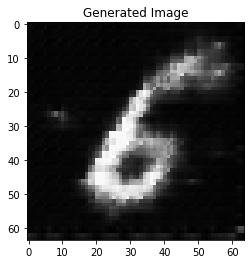

Epoch 98/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 10.83it/s]


Epoch [98/500], Loss: 76227.9062 (total loss), 72886.0000 (bce), 3341.9070 (kld)
Mu range: -1.921994924545288 ~ 2.4073565006256104, Logvar range: -6.307461738586426 ~ -0.0713774561882019
tensor(2)


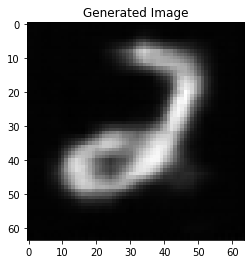

Epoch 99/500: 100%|███████████████████████████| 118/118 [00:10<00:00, 10.94it/s]

Epoch [99/500], Loss: 78884.4609 (total loss), 75885.4062 (bce), 2999.0574 (kld)
Mu range: -3.053626775741577 ~ 2.706157684326172, Logvar range: -4.685284614562988 ~ -0.28935495018959045
tensor(7)


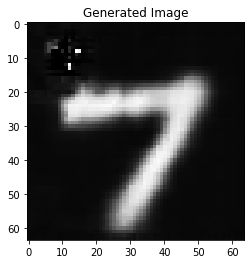

Epoch 100/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.06it/s]


Epoch [100/500], Loss: 75952.5312 (total loss), 72840.6328 (bce), 3111.8979 (kld)
Mu range: -1.1691752672195435 ~ 3.362139940261841, Logvar range: -8.966910362243652 ~ -0.0033883750438690186
tensor(7)


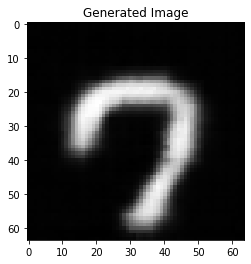

Epoch 101/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.41it/s]


Epoch [101/500], Loss: 76409.4141 (total loss), 73268.3047 (bce), 3141.1118 (kld)
Mu range: -2.6555304527282715 ~ 1.1564643383026123, Logvar range: -5.1843414306640625 ~ -0.10268190503120422
tensor(4)


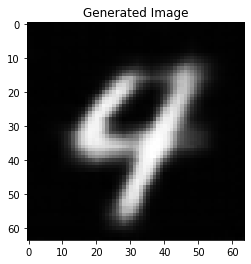

Epoch 102/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.47it/s]


Epoch [102/500], Loss: 75434.8516 (total loss), 72559.3828 (bce), 2875.4697 (kld)
Mu range: -2.609177350997925 ~ 1.569079875946045, Logvar range: -8.77208423614502 ~ 0.03836563229560852
tensor(4)


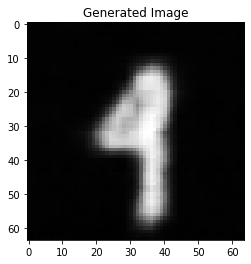

Epoch 103/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.10it/s]


Epoch [103/500], Loss: 81573.3984 (total loss), 78477.3125 (bce), 3096.0864 (kld)
Mu range: -1.535994529724121 ~ 1.0972566604614258, Logvar range: -5.158932685852051 ~ -0.02933044731616974
tensor(1)


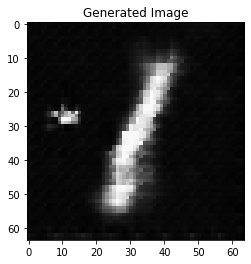

Epoch 104/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.36it/s]


Epoch [104/500], Loss: 83571.8203 (total loss), 80712.4688 (bce), 2859.3479 (kld)
Mu range: -1.9943727254867554 ~ 1.2287640571594238, Logvar range: -5.704073429107666 ~ -0.07753945887088776
tensor(1)


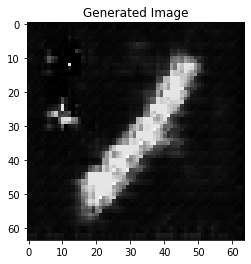

Epoch 105/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.24it/s]


Epoch [105/500], Loss: 85925.7188 (total loss), 82850.4141 (bce), 3075.3042 (kld)
Mu range: -0.9591829180717468 ~ 1.3658320903778076, Logvar range: -5.410549640655518 ~ -0.17968329787254333
tensor(1)


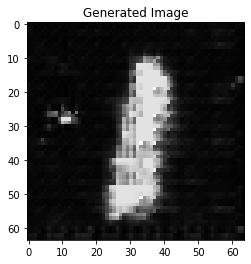

Epoch 106/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]


Epoch [106/500], Loss: 77374.4688 (total loss), 74450.0312 (bce), 2924.4370 (kld)
Mu range: -3.7927706241607666 ~ 2.890845775604248, Logvar range: -6.135286331176758 ~ 0.0708385705947876
tensor(0)


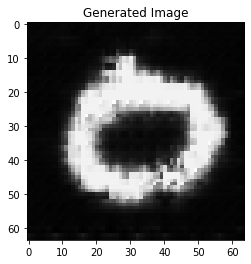

Epoch 107/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.23it/s]

Epoch [107/500], Loss: 71606.4141 (total loss), 68465.1797 (bce), 3141.2339 (kld)
Mu range: -2.006075382232666 ~ 2.2859461307525635, Logvar range: -5.297097206115723 ~ -0.10453927516937256
tensor(6)


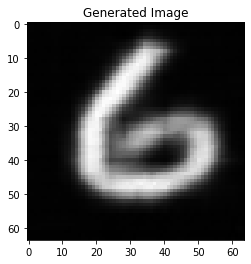

Epoch 108/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.30it/s]


Epoch [108/500], Loss: 72547.9688 (total loss), 69566.9062 (bce), 2981.0640 (kld)
Mu range: -2.7400553226470947 ~ 2.0213353633880615, Logvar range: -6.370277404785156 ~ -0.027299463748931885
tensor(2)


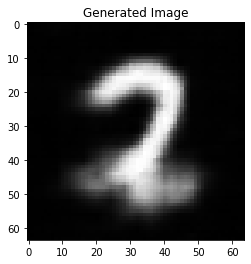

Epoch 109/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.38it/s]

Epoch [109/500], Loss: 90919.3359 (total loss), 88015.7031 (bce), 2903.6348 (kld)
Mu range: -2.3988826274871826 ~ 1.0245728492736816, Logvar range: -6.6578369140625 ~ -0.020932331681251526
tensor(8)


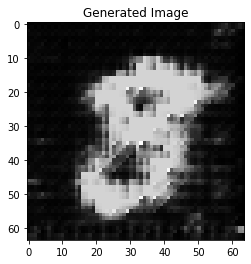

Epoch 110/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.40it/s]


Epoch [110/500], Loss: 72888.2734 (total loss), 69892.0391 (bce), 2996.2375 (kld)
Mu range: -2.4692413806915283 ~ 2.1777780055999756, Logvar range: -8.928529739379883 ~ -0.04495924711227417
tensor(3)


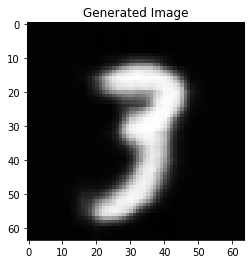

Epoch 111/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.94it/s]


Epoch [111/500], Loss: 76510.9297 (total loss), 73422.4688 (bce), 3088.4587 (kld)
Mu range: -1.6392720937728882 ~ 1.429234504699707, Logvar range: -5.790543556213379 ~ -0.08039544522762299
tensor(3)


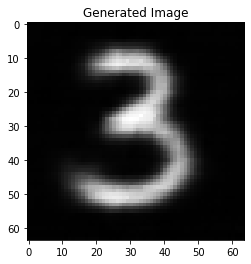

Epoch 112/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.30it/s]


Epoch [112/500], Loss: 72941.0938 (total loss), 69854.3594 (bce), 3086.7344 (kld)
Mu range: -2.3906161785125732 ~ 1.492394208908081, Logvar range: -5.6768903732299805 ~ -0.05778038501739502
tensor(5)


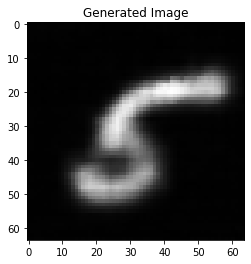

Epoch 113/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.31it/s]


Epoch [113/500], Loss: 72556.1016 (total loss), 69529.1016 (bce), 3027.0015 (kld)
Mu range: -1.8422789573669434 ~ 1.3894968032836914, Logvar range: -5.756311416625977 ~ -0.030017629265785217
tensor(6)


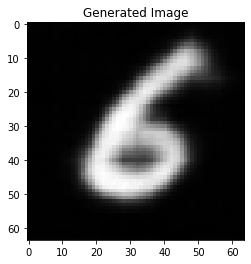

Epoch 114/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.10it/s]

Epoch [114/500], Loss: 74002.4375 (total loss), 70987.5469 (bce), 3014.8911 (kld)
Mu range: -0.9102097749710083 ~ 1.6553131341934204, Logvar range: -5.629838943481445 ~ -0.04199273884296417
tensor(7)


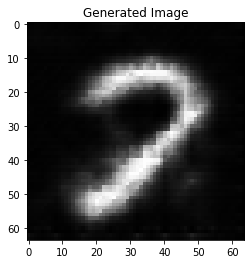

Epoch 115/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.26it/s]

Epoch [115/500], Loss: 73208.9844 (total loss), 70087.1562 (bce), 3121.8311 (kld)
Mu range: -0.3728253245353699 ~ 1.11526620388031, Logvar range: -4.245002746582031 ~ -0.19245874881744385
tensor(7)


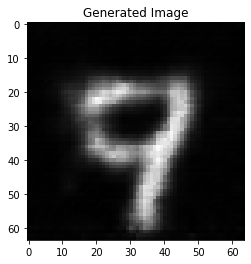

Epoch 116/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.51it/s]


Epoch [116/500], Loss: 72349.3359 (total loss), 69380.9062 (bce), 2968.4316 (kld)
Mu range: -2.8301076889038086 ~ 1.9358347654342651, Logvar range: -6.755123138427734 ~ -0.0013403892517089844
tensor(5)


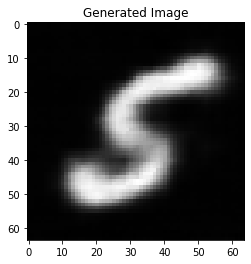

Epoch 117/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.27it/s]

Epoch [117/500], Loss: 69026.4766 (total loss), 65950.4453 (bce), 3076.0288 (kld)
Mu range: -1.8232624530792236 ~ 2.7739648818969727, Logvar range: -6.113646507263184 ~ -0.07396401464939117
tensor(7)


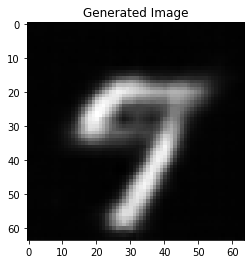

Epoch 118/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.25it/s]


Epoch [118/500], Loss: 74599.9531 (total loss), 71395.2344 (bce), 3204.7200 (kld)
Mu range: -0.8261250257492065 ~ 0.704689621925354, Logvar range: -3.6641218662261963 ~ -0.19243879616260529
tensor(8)


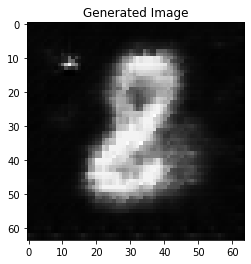

Epoch 119/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.40it/s]

Epoch [119/500], Loss: 70839.4219 (total loss), 67944.3281 (bce), 2895.0906 (kld)
Mu range: -1.3719918727874756 ~ 1.840643286705017, Logvar range: -5.117074966430664 ~ -0.0810406506061554
tensor(9)


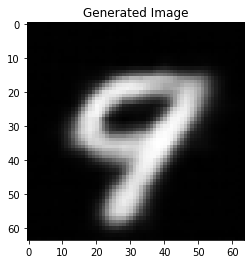

Epoch 120/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.48it/s]

Epoch [120/500], Loss: 72112.9375 (total loss), 69085.2500 (bce), 3027.6836 (kld)
Mu range: -2.6143908500671387 ~ 2.2998368740081787, Logvar range: -7.887335777282715 ~ 0.049974143505096436
tensor(6)


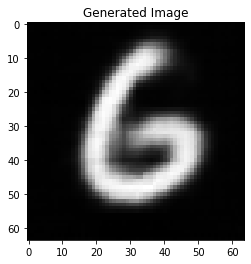

Epoch 121/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.34it/s]


Epoch [121/500], Loss: 74202.2266 (total loss), 71236.9141 (bce), 2965.3132 (kld)
Mu range: -1.043644905090332 ~ 1.6347148418426514, Logvar range: -5.816664695739746 ~ 0.03447240591049194
tensor(8)


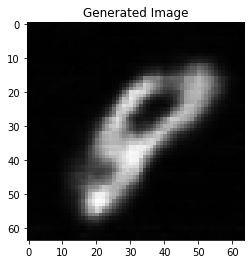

Epoch 122/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.22it/s]


Epoch [122/500], Loss: 72269.0469 (total loss), 69269.5078 (bce), 2999.5396 (kld)
Mu range: -0.8906422853469849 ~ 0.4266306757926941, Logvar range: -4.306106090545654 ~ -0.17994214594364166
tensor(5)


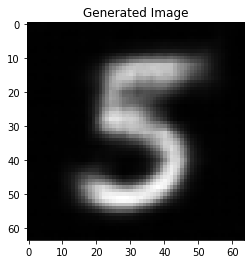

Epoch 123/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]


Epoch [123/500], Loss: 70599.0781 (total loss), 67554.4062 (bce), 3044.6738 (kld)
Mu range: -2.5885088443756104 ~ 3.7107274532318115, Logvar range: -6.605093002319336 ~ -0.18634477257728577
tensor(7)


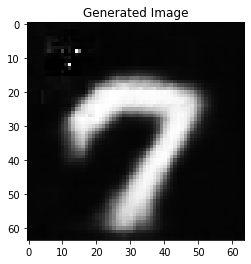

Epoch 124/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.46it/s]


Epoch [124/500], Loss: 72016.6562 (total loss), 69084.6406 (bce), 2932.0195 (kld)
Mu range: -4.123890399932861 ~ 3.39461612701416, Logvar range: -9.827178955078125 ~ 0.1436999887228012
tensor(1)


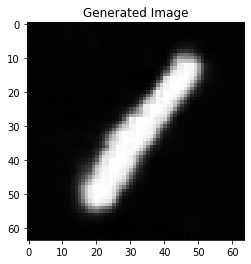

Epoch 125/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.17it/s]


Epoch [125/500], Loss: 73940.6094 (total loss), 70872.0156 (bce), 3068.5977 (kld)
Mu range: -1.1138941049575806 ~ 1.1695046424865723, Logvar range: -4.911477565765381 ~ -0.10470897704362869
tensor(5)


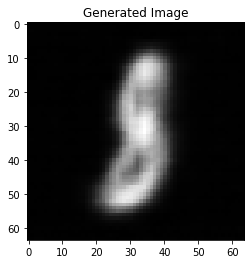

Epoch 126/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.15it/s]

Epoch [126/500], Loss: 71449.5234 (total loss), 68544.7656 (bce), 2904.7607 (kld)
Mu range: -2.0208778381347656 ~ 1.671499490737915, Logvar range: -6.602789402008057 ~ 0.004808709025382996
tensor(8)


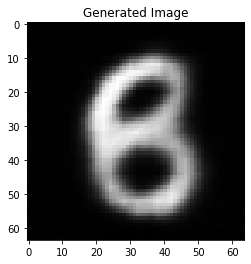

Epoch 127/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.13it/s]


Epoch [127/500], Loss: 71708.5625 (total loss), 68660.1406 (bce), 3048.4243 (kld)
Mu range: -2.9348762035369873 ~ 3.9188315868377686, Logvar range: -8.768495559692383 ~ 0.04723440110683441
tensor(0)


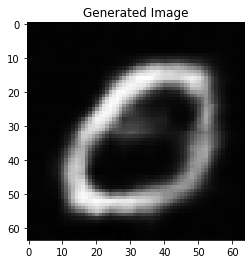

Epoch 128/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.29it/s]


Epoch [128/500], Loss: 73463.8906 (total loss), 70371.3281 (bce), 3092.5654 (kld)
Mu range: -1.4479188919067383 ~ 1.0884547233581543, Logvar range: -5.106224060058594 ~ -0.09211728721857071
tensor(4)


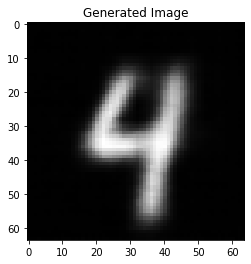

Epoch 129/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.34it/s]


Epoch [129/500], Loss: 70714.1094 (total loss), 67693.6719 (bce), 3020.4404 (kld)
Mu range: -3.091017484664917 ~ 2.4360671043395996, Logvar range: -7.621050834655762 ~ -0.06742188334465027
tensor(3)


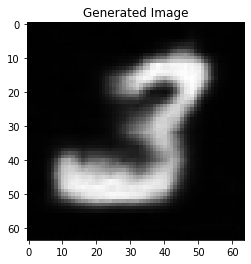

Epoch 130/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.30it/s]

Epoch [130/500], Loss: 70060.8750 (total loss), 66834.8594 (bce), 3226.0142 (kld)
Mu range: -4.04827880859375 ~ 2.0610575675964355, Logvar range: -9.343334197998047 ~ 0.01975978910923004
tensor(5)


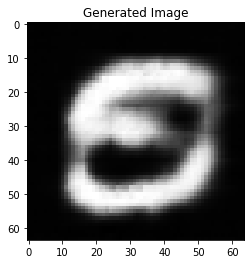

Epoch 131/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.23it/s]

Epoch [131/500], Loss: 84995.0781 (total loss), 81938.9766 (bce), 3056.0977 (kld)
Mu range: -0.9935659170150757 ~ 0.8013502359390259, Logvar range: -5.842915058135986 ~ -0.10277075320482254
tensor(8)


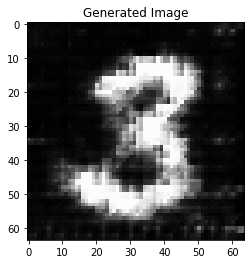

Epoch 132/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.15it/s]


Epoch [132/500], Loss: 70991.6484 (total loss), 67875.3438 (bce), 3116.3081 (kld)
Mu range: -1.7756413221359253 ~ 1.4622019529342651, Logvar range: -5.300490379333496 ~ -0.03200414776802063
tensor(3)


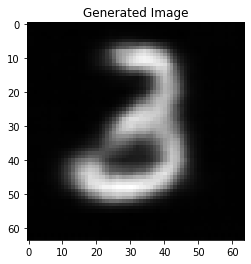

Epoch 133/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.19it/s]


Epoch [133/500], Loss: 70592.0859 (total loss), 67454.0938 (bce), 3137.9932 (kld)
Mu range: -1.799951434135437 ~ 0.9256339073181152, Logvar range: -5.036703109741211 ~ -0.09182950109243393
tensor(2)


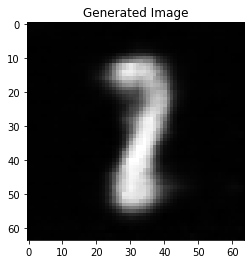

Epoch 134/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.51it/s]

Epoch [134/500], Loss: 76017.3359 (total loss), 73048.7109 (bce), 2968.6248 (kld)
Mu range: -0.8684567809104919 ~ 0.8237094283103943, Logvar range: -4.255407333374023 ~ -0.13074520230293274
tensor(8)


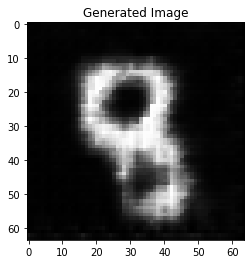

Epoch 135/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.38it/s]

Epoch [135/500], Loss: 78652.7969 (total loss), 75546.7969 (bce), 3106.0020 (kld)
Mu range: -2.0198559761047363 ~ 1.4260292053222656, Logvar range: -7.869523048400879 ~ 0.12490189075469971
tensor(5)


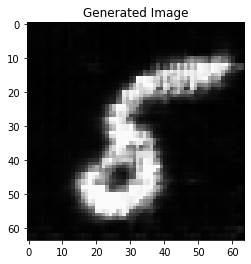

Epoch 136/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.45it/s]


Epoch [136/500], Loss: 72303.4922 (total loss), 69284.2500 (bce), 3019.2446 (kld)
Mu range: -0.8836284875869751 ~ 1.3004202842712402, Logvar range: -3.8126134872436523 ~ -0.2117474228143692
tensor(2)


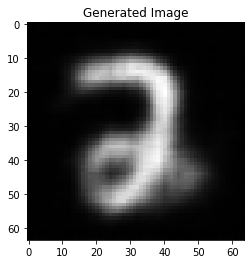

Epoch 137/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.16it/s]

Epoch [137/500], Loss: 76291.0156 (total loss), 73262.8281 (bce), 3028.1870 (kld)
Mu range: -2.100538969039917 ~ 0.8540563583374023, Logvar range: -5.4561920166015625 ~ -0.1012703999876976
tensor(8)


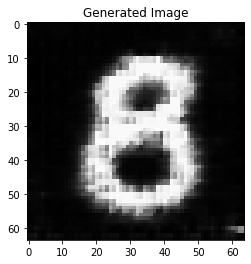

Epoch 138/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.29it/s]

Epoch [138/500], Loss: 71152.4062 (total loss), 68009.0000 (bce), 3143.4067 (kld)
Mu range: -0.9865915179252625 ~ 1.839046597480774, Logvar range: -4.508413314819336 ~ -0.09895245730876923
tensor(2)


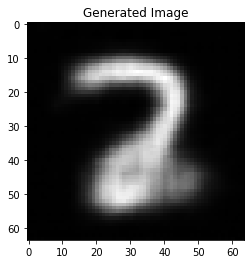

Epoch 139/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]

Epoch [139/500], Loss: 69170.4375 (total loss), 66066.6875 (bce), 3103.7495 (kld)
Mu range: -2.7978267669677734 ~ 3.662245750427246, Logvar range: -7.8304243087768555 ~ -0.05349418520927429
tensor(8)


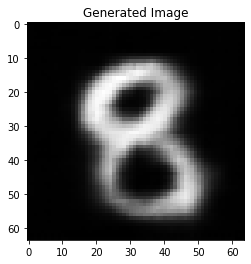

Epoch 140/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.36it/s]


Epoch [140/500], Loss: 70290.3594 (total loss), 67288.0625 (bce), 3002.2944 (kld)
Mu range: -0.6509585380554199 ~ 1.3592487573623657, Logvar range: -5.781955718994141 ~ -0.012329474091529846
tensor(9)


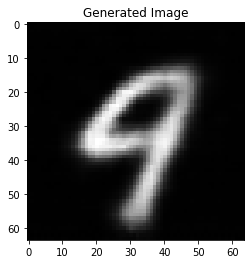

Epoch 141/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.45it/s]

Epoch [141/500], Loss: 70986.8516 (total loss), 67938.9141 (bce), 3047.9360 (kld)
Mu range: -2.867310047149658 ~ 2.6646087169647217, Logvar range: -6.8857269287109375 ~ 0.08018073439598083
tensor(7)


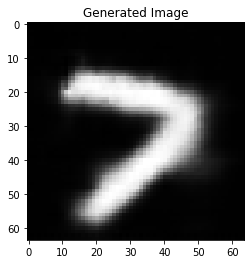

Epoch 142/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.32it/s]


Epoch [142/500], Loss: 71870.3984 (total loss), 68870.3750 (bce), 3000.0205 (kld)
Mu range: -2.888563394546509 ~ 2.9874329566955566, Logvar range: -6.265543460845947 ~ 0.02201947569847107
tensor(4)


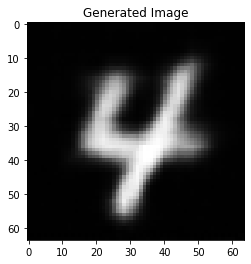

Epoch 143/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.33it/s]

Epoch [143/500], Loss: 69185.3750 (total loss), 66175.0703 (bce), 3010.3083 (kld)
Mu range: -1.995367169380188 ~ 1.3423418998718262, Logvar range: -4.894003868103027 ~ -0.11602161079645157
tensor(6)


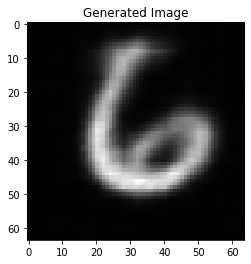

Epoch 144/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.47it/s]


Epoch [144/500], Loss: 68244.3672 (total loss), 65164.8281 (bce), 3079.5417 (kld)
Mu range: -3.5531864166259766 ~ 3.1559903621673584, Logvar range: -8.165203094482422 ~ 0.02766658365726471
tensor(7)


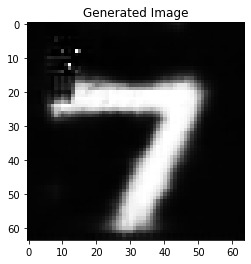

Epoch 145/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.34it/s]


Epoch [145/500], Loss: 67118.9766 (total loss), 63995.9453 (bce), 3123.0312 (kld)
Mu range: -1.6109352111816406 ~ 3.1960251331329346, Logvar range: -5.305171012878418 ~ -0.08518591523170471
tensor(7)


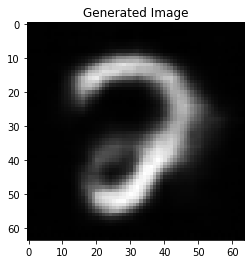

Epoch 146/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.30it/s]


Epoch [146/500], Loss: 72793.3672 (total loss), 69712.3047 (bce), 3081.0632 (kld)
Mu range: -1.9153095483779907 ~ 2.744278907775879, Logvar range: -7.250429153442383 ~ 0.20980620384216309
tensor(0)


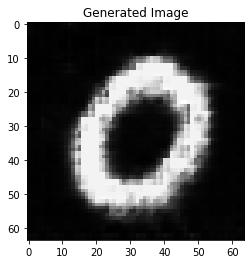

Epoch 147/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.25it/s]

Epoch [147/500], Loss: 70360.7031 (total loss), 67261.6875 (bce), 3099.0173 (kld)
Mu range: -2.0614101886749268 ~ 2.726227283477783, Logvar range: -5.972975730895996 ~ -0.008917927742004395
tensor(2)


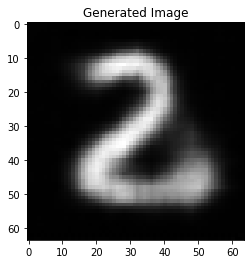

Epoch 148/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.13it/s]


Epoch [148/500], Loss: 73073.0703 (total loss), 69981.9531 (bce), 3091.1206 (kld)
Mu range: -2.5550925731658936 ~ 3.6943893432617188, Logvar range: -7.608788013458252 ~ -0.12634575366973877
tensor(0)


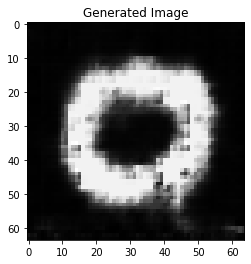

Epoch 149/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]

Epoch [149/500], Loss: 79493.0859 (total loss), 76509.0938 (bce), 2983.9951 (kld)
Mu range: -1.994426965713501 ~ 1.8023898601531982, Logvar range: -6.432305812835693 ~ -0.004511415958404541
tensor(0)


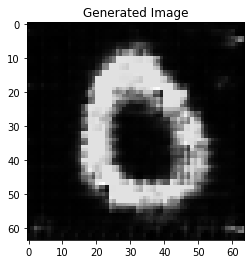

Epoch 150/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.32it/s]

Epoch [150/500], Loss: 71462.4688 (total loss), 68386.4062 (bce), 3076.0640 (kld)
Mu range: -1.1849316358566284 ~ 2.7353830337524414, Logvar range: -5.496267318725586 ~ 0.006832197308540344
tensor(0)


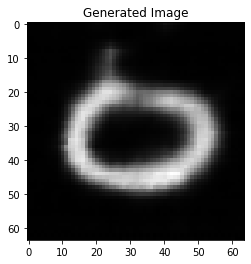

Epoch 151/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.08it/s]


Epoch [151/500], Loss: 69265.0469 (total loss), 66244.3594 (bce), 3020.6841 (kld)
Mu range: -2.021792411804199 ~ 0.7386795282363892, Logvar range: -5.6171064376831055 ~ -0.09223340451717377
tensor(5)


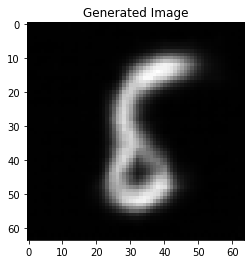

Epoch 152/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.20it/s]


Epoch [152/500], Loss: 65760.7500 (total loss), 62749.5273 (bce), 3011.2227 (kld)
Mu range: -1.822007417678833 ~ 1.5252618789672852, Logvar range: -6.262415885925293 ~ -0.04071547091007233
tensor(1)


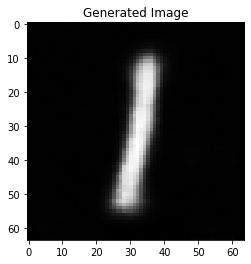

Epoch 153/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.50it/s]

Epoch [153/500], Loss: 67780.5234 (total loss), 64711.7422 (bce), 3068.7800 (kld)
Mu range: -3.474472999572754 ~ 0.3962531089782715, Logvar range: -8.41260051727295 ~ -0.02583657205104828
tensor(2)


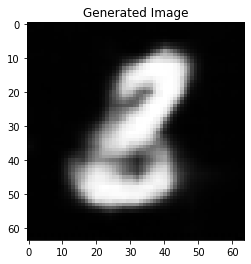

Epoch 154/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.08it/s]


Epoch [154/500], Loss: 71495.7656 (total loss), 68523.9219 (bce), 2971.8433 (kld)
Mu range: -0.7574210166931152 ~ 0.7653843760490417, Logvar range: -6.308778762817383 ~ -0.055388279259204865
tensor(8)


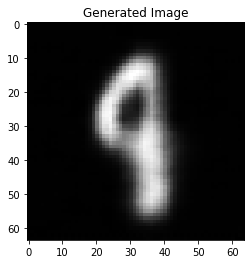

Epoch 155/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.31it/s]


Epoch [155/500], Loss: 67688.8047 (total loss), 64658.9688 (bce), 3029.8337 (kld)
Mu range: -1.452478289604187 ~ 1.0896178483963013, Logvar range: -5.398942947387695 ~ -0.05494198948144913
tensor(3)


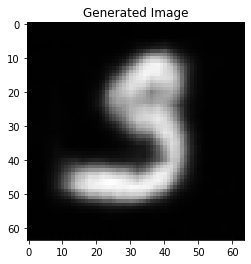

Epoch 156/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.64it/s]


Epoch [156/500], Loss: 71594.4141 (total loss), 68456.1875 (bce), 3138.2285 (kld)
Mu range: -1.7620575428009033 ~ 1.027780294418335, Logvar range: -6.048309326171875 ~ -0.04722662270069122
tensor(7)


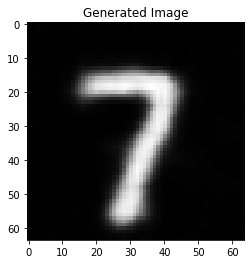

Epoch 157/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.25it/s]

Epoch [157/500], Loss: 66712.0391 (total loss), 63656.9531 (bce), 3055.0845 (kld)
Mu range: -2.898834705352783 ~ 1.4606523513793945, Logvar range: -8.147510528564453 ~ 0.022752627730369568
tensor(8)


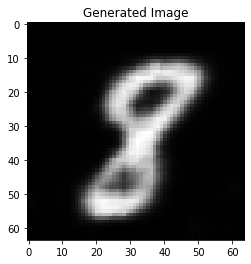

Epoch 158/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.58it/s]

Epoch [158/500], Loss: 65436.9844 (total loss), 62498.4062 (bce), 2938.5781 (kld)
Mu range: -3.4642624855041504 ~ 1.834230899810791, Logvar range: -6.193567276000977 ~ -0.05647501349449158
tensor(3)


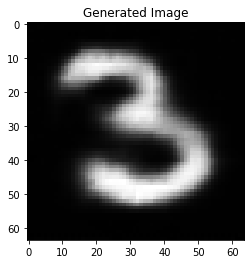

Epoch 159/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.63it/s]

Epoch [159/500], Loss: 76302.2344 (total loss), 73345.4219 (bce), 2956.8132 (kld)
Mu range: -0.6989054679870605 ~ 1.3183882236480713, Logvar range: -4.229372501373291 ~ -0.12685774266719818
tensor(7)


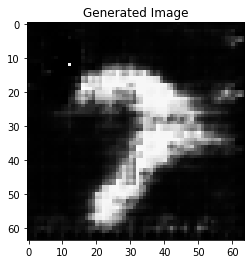

Epoch 160/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.20it/s]


Epoch [160/500], Loss: 70664.3438 (total loss), 67597.3281 (bce), 3067.0186 (kld)
Mu range: -1.236074447631836 ~ 0.7365964651107788, Logvar range: -4.748027324676514 ~ -0.08829006552696228
tensor(8)


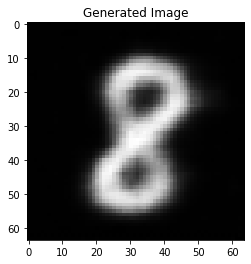

Epoch 161/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.33it/s]


Epoch [161/500], Loss: 65356.1484 (total loss), 62260.0859 (bce), 3096.0630 (kld)
Mu range: -1.620802879333496 ~ 0.4504772424697876, Logvar range: -5.723415374755859 ~ -0.07912467420101166
tensor(3)


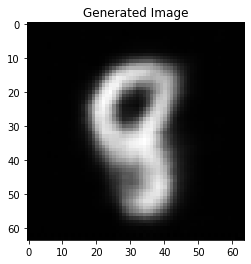

Epoch 162/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.36it/s]


Epoch [162/500], Loss: 70622.7422 (total loss), 67660.1719 (bce), 2962.5728 (kld)
Mu range: -0.8715513348579407 ~ 1.4158265590667725, Logvar range: -6.3335113525390625 ~ -0.06886819005012512
tensor(9)


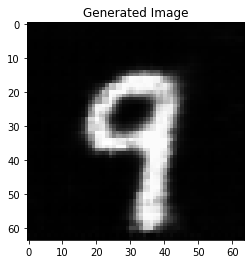

Epoch 163/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.58it/s]

Epoch [163/500], Loss: 68807.2422 (total loss), 65631.8516 (bce), 3175.3896 (kld)
Mu range: -1.3992505073547363 ~ 2.0426642894744873, Logvar range: -7.5132293701171875 ~ 0.07450589537620544
tensor(8)


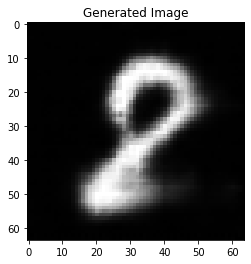

Epoch 164/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.77it/s]


Epoch [164/500], Loss: 66119.3438 (total loss), 63004.8750 (bce), 3114.4702 (kld)
Mu range: -1.0083935260772705 ~ 1.058690071105957, Logvar range: -4.656675338745117 ~ -0.09963005036115646
tensor(5)


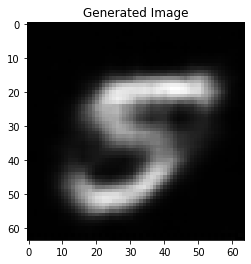

Epoch 165/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.20it/s]


Epoch [165/500], Loss: 64772.0703 (total loss), 61742.7500 (bce), 3029.3201 (kld)
Mu range: -2.4558393955230713 ~ 3.276609182357788, Logvar range: -7.732650279998779 ~ 0.04587149620056152
tensor(0)


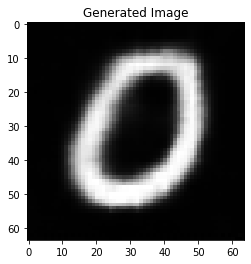

Epoch 166/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.97it/s]


Epoch [166/500], Loss: 67347.6016 (total loss), 64246.0781 (bce), 3101.5208 (kld)
Mu range: -2.3601224422454834 ~ 1.463471531867981, Logvar range: -6.008388042449951 ~ -0.01686718314886093
tensor(6)


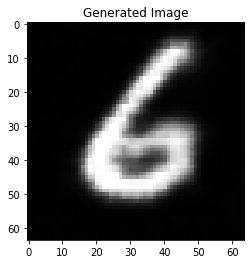

Epoch 167/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.35it/s]

Epoch [167/500], Loss: 68554.5469 (total loss), 65422.6172 (bce), 3131.9336 (kld)
Mu range: -0.922359049320221 ~ 0.7471686005592346, Logvar range: -5.049449920654297 ~ -0.06233996897935867
tensor(9)


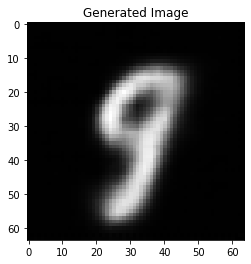

Epoch 168/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.41it/s]


Epoch [168/500], Loss: 67974.9609 (total loss), 64955.8164 (bce), 3019.1465 (kld)
Mu range: -1.6871672868728638 ~ 0.9853199124336243, Logvar range: -6.4655070304870605 ~ -0.032540418207645416
tensor(1)


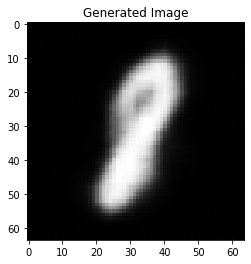

Epoch 169/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]


Epoch [169/500], Loss: 66413.3984 (total loss), 63373.9102 (bce), 3039.4893 (kld)
Mu range: -1.5082799196243286 ~ 1.17936372756958, Logvar range: -6.706897735595703 ~ -0.039683811366558075
tensor(7)


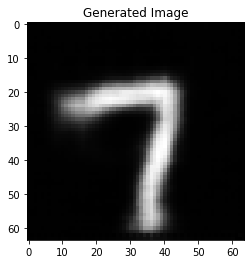

Epoch 170/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.15it/s]

Epoch [170/500], Loss: 74513.5078 (total loss), 71482.8594 (bce), 3030.6516 (kld)
Mu range: -1.3738906383514404 ~ 1.6486618518829346, Logvar range: -6.577188491821289 ~ -0.049143776297569275
tensor(1)


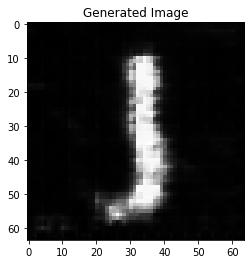

Epoch 171/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.08it/s]


Epoch [171/500], Loss: 67490.3516 (total loss), 64320.7422 (bce), 3169.6104 (kld)
Mu range: -3.9524710178375244 ~ 2.5448455810546875, Logvar range: -6.660163879394531 ~ 0.19422760605812073
tensor(4)


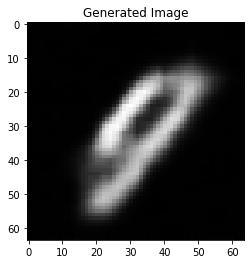

Epoch 172/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.01it/s]


Epoch [172/500], Loss: 66545.9062 (total loss), 63371.7695 (bce), 3174.1333 (kld)
Mu range: -1.28865647315979 ~ 1.4998431205749512, Logvar range: -4.841604232788086 ~ -0.058715179562568665
tensor(4)


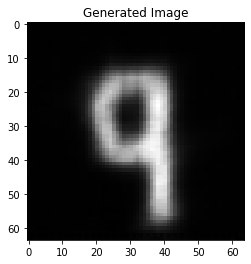

Epoch 173/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.24it/s]


Epoch [173/500], Loss: 65065.1172 (total loss), 62040.3203 (bce), 3024.7964 (kld)
Mu range: -2.5398128032684326 ~ 1.6668901443481445, Logvar range: -7.128740310668945 ~ 0.10617625713348389
tensor(1)


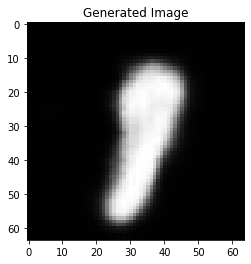

Epoch 174/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.08it/s]


Epoch [174/500], Loss: 67236.3516 (total loss), 64045.9766 (bce), 3190.3721 (kld)
Mu range: -1.9187850952148438 ~ 0.7310810685157776, Logvar range: -6.195093154907227 ~ -0.05726752430200577
tensor(2)


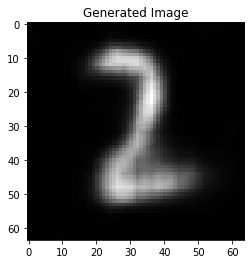

Epoch 175/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]

Epoch [175/500], Loss: 69636.3750 (total loss), 66669.4844 (bce), 2966.8916 (kld)
Mu range: -1.0912983417510986 ~ 1.8795030117034912, Logvar range: -5.3057966232299805 ~ -0.06267410516738892
tensor(2)


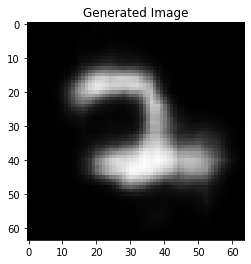

Epoch 176/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]

Epoch [176/500], Loss: 64433.3555 (total loss), 61482.7539 (bce), 2950.6006 (kld)
Mu range: -2.0380492210388184 ~ 1.0970131158828735, Logvar range: -5.762816429138184 ~ -0.003398485481739044
tensor(1)


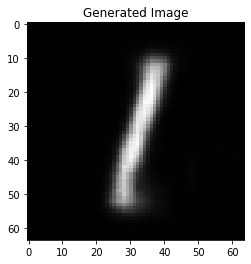

Epoch 177/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.15it/s]


Epoch [177/500], Loss: 67288.2500 (total loss), 64160.3477 (bce), 3127.9028 (kld)
Mu range: -3.255809783935547 ~ 1.888762354850769, Logvar range: -6.82758903503418 ~ 0.02532614767551422
tensor(0)


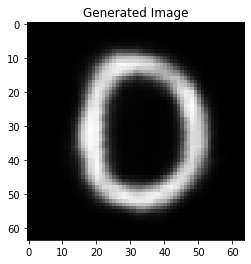

Epoch 178/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.15it/s]

Epoch [178/500], Loss: 67071.9844 (total loss), 63998.7266 (bce), 3073.2588 (kld)
Mu range: -2.128598928451538 ~ 1.3731677532196045, Logvar range: -6.155942440032959 ~ -0.02443452924489975
tensor(0)


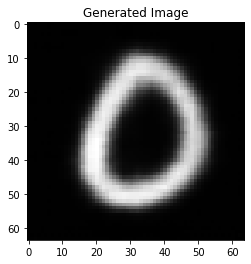

Epoch 179/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.91it/s]

Epoch [179/500], Loss: 65735.0156 (total loss), 62627.5938 (bce), 3107.4180 (kld)
Mu range: -2.2498412132263184 ~ 1.4390980005264282, Logvar range: -5.857870101928711 ~ -0.034285515546798706
tensor(9)


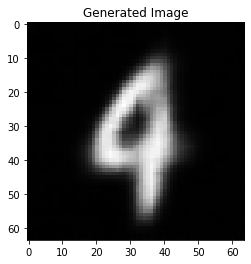

Epoch 180/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.02it/s]


Epoch [180/500], Loss: 76451.8828 (total loss), 73260.8125 (bce), 3191.0691 (kld)
Mu range: -1.7543710470199585 ~ 1.7638548612594604, Logvar range: -6.354047775268555 ~ -0.024070538580417633
tensor(1)


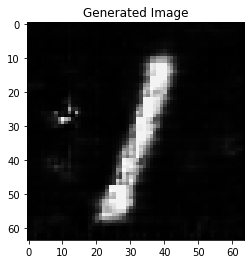

Epoch 181/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.20it/s]


Epoch [181/500], Loss: 65947.3906 (total loss), 62629.9297 (bce), 3317.4624 (kld)
Mu range: -1.408522367477417 ~ 1.6029109954833984, Logvar range: -5.384730815887451 ~ -0.012002326548099518
tensor(0)


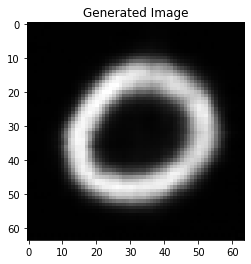

Epoch 182/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.45it/s]


Epoch [182/500], Loss: 70847.2109 (total loss), 67693.2344 (bce), 3153.9792 (kld)
Mu range: -3.052926540374756 ~ 1.6710032224655151, Logvar range: -6.165121078491211 ~ 0.1366811841726303
tensor(1)


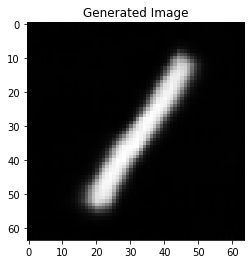

Epoch 183/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.25it/s]


Epoch [183/500], Loss: 74116.3125 (total loss), 71120.5625 (bce), 2995.7476 (kld)
Mu range: -1.3164254426956177 ~ 0.45420321822166443, Logvar range: -6.038459300994873 ~ -0.04115297272801399
tensor(5)


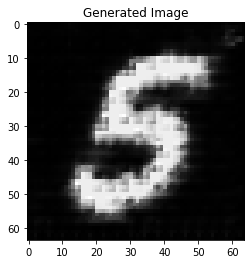

Epoch 184/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.41it/s]


Epoch [184/500], Loss: 70118.8672 (total loss), 66970.6094 (bce), 3148.2551 (kld)
Mu range: -2.8847572803497314 ~ 1.3246649503707886, Logvar range: -5.289469242095947 ~ -0.008785799145698547
tensor(5)


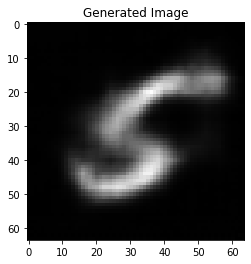

Epoch 185/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.47it/s]


Epoch [185/500], Loss: 67186.5938 (total loss), 64203.4492 (bce), 2983.1421 (kld)
Mu range: -1.6769367456436157 ~ 1.6846976280212402, Logvar range: -5.554884910583496 ~ -0.051963772624731064
tensor(1)


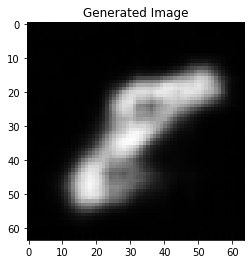

Epoch 186/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.52it/s]


Epoch [186/500], Loss: 69063.0312 (total loss), 65983.4688 (bce), 3079.5654 (kld)
Mu range: -1.7310577630996704 ~ 1.4247066974639893, Logvar range: -6.300934791564941 ~ -0.0038528218865394592
tensor(1)


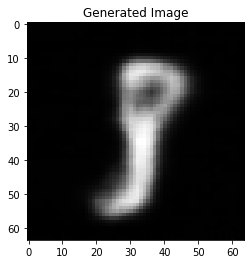

Epoch 187/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.23it/s]

Epoch [187/500], Loss: 67196.4062 (total loss), 64140.2031 (bce), 3056.2051 (kld)
Mu range: -1.469555139541626 ~ 0.6366028785705566, Logvar range: -4.7648515701293945 ~ -0.04188888520002365
tensor(6)


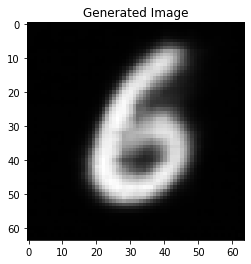

Epoch 188/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.07it/s]

Epoch [188/500], Loss: 68094.4141 (total loss), 64953.1328 (bce), 3141.2847 (kld)
Mu range: -0.8381301164627075 ~ 1.092509388923645, Logvar range: -4.723088264465332 ~ -0.023217424750328064
tensor(7)


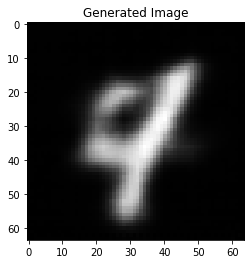

Epoch 189/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.20it/s]


Epoch [189/500], Loss: 70043.4922 (total loss), 66819.1875 (bce), 3224.3027 (kld)
Mu range: -2.338071346282959 ~ 1.1958136558532715, Logvar range: -6.24017333984375 ~ 0.01240319013595581
tensor(6)


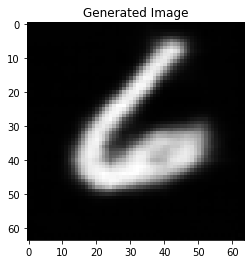

Epoch 190/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.20it/s]

Epoch [190/500], Loss: 70692.7188 (total loss), 67537.6875 (bce), 3155.0317 (kld)
Mu range: -3.374084234237671 ~ 3.396925449371338, Logvar range: -6.436166763305664 ~ 0.034408241510391235
tensor(2)


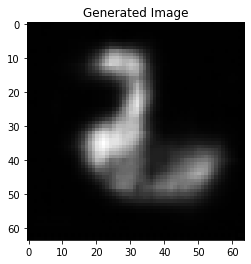

Epoch 191/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.15it/s]


Epoch [191/500], Loss: 67120.2656 (total loss), 63937.0391 (bce), 3183.2258 (kld)
Mu range: -1.4190787076950073 ~ 0.7989718317985535, Logvar range: -5.551951885223389 ~ -0.015406399965286255
tensor(4)


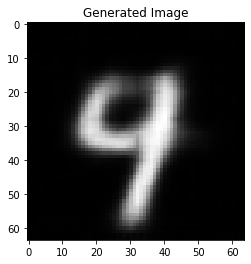

Epoch 192/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]

Epoch [192/500], Loss: 70388.3516 (total loss), 67252.2422 (bce), 3136.1106 (kld)
Mu range: -1.199852705001831 ~ 2.416921615600586, Logvar range: -6.598639488220215 ~ -0.021561436355113983
tensor(4)


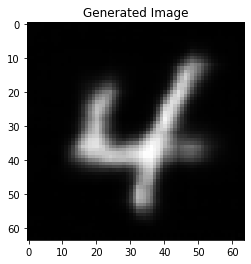

Epoch 193/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.45it/s]


Epoch [193/500], Loss: 66709.0391 (total loss), 63624.0508 (bce), 3084.9917 (kld)
Mu range: -1.456457257270813 ~ 1.2828402519226074, Logvar range: -6.28903865814209 ~ -0.05965316295623779
tensor(8)


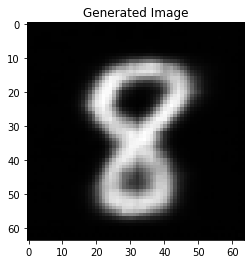

Epoch 194/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.91it/s]


Epoch [194/500], Loss: 62409.8594 (total loss), 59489.5156 (bce), 2920.3428 (kld)
Mu range: -1.3703298568725586 ~ 2.122138261795044, Logvar range: -6.8774614334106445 ~ 0.04206573963165283
tensor(6)


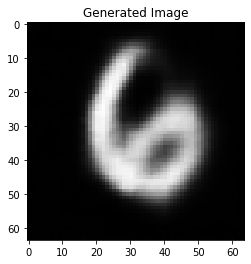

Epoch 195/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.21it/s]


Epoch [195/500], Loss: 67046.9922 (total loss), 64021.2109 (bce), 3025.7793 (kld)
Mu range: -2.2694852352142334 ~ 0.796919047832489, Logvar range: -6.957583427429199 ~ -0.013731628656387329
tensor(8)


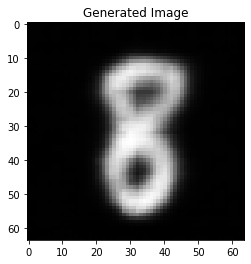

Epoch 196/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.18it/s]


Epoch [196/500], Loss: 72849.3828 (total loss), 69749.3203 (bce), 3100.0608 (kld)
Mu range: -1.5497920513153076 ~ 1.594346046447754, Logvar range: -6.245019912719727 ~ -0.003308594226837158
tensor(8)


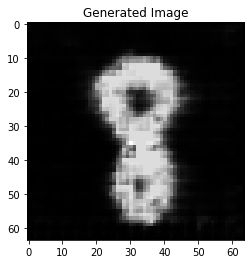

Epoch 197/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.43it/s]


Epoch [197/500], Loss: 65833.0547 (total loss), 62811.0156 (bce), 3022.0405 (kld)
Mu range: -1.1825298070907593 ~ 1.0473458766937256, Logvar range: -5.507806301116943 ~ -0.037242185324430466
tensor(8)


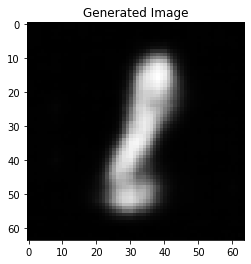

Epoch 198/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]

Epoch [198/500], Loss: 67417.9922 (total loss), 64357.5195 (bce), 3060.4712 (kld)
Mu range: -0.8518301844596863 ~ 1.5837271213531494, Logvar range: -5.795919418334961 ~ -0.03744666278362274
tensor(9)


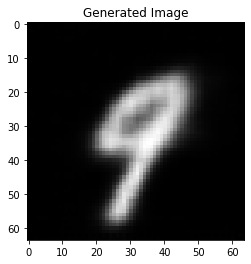

Epoch 199/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.03it/s]


Epoch [199/500], Loss: 67115.2891 (total loss), 64130.4609 (bce), 2984.8252 (kld)
Mu range: -2.0970895290374756 ~ 1.3414771556854248, Logvar range: -5.7813873291015625 ~ -0.022559765726327896
tensor(6)


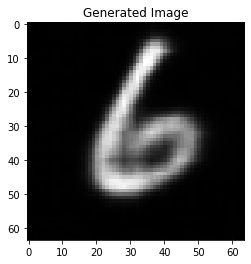

Epoch 200/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]


Epoch [200/500], Loss: 65728.4453 (total loss), 62557.6836 (bce), 3170.7644 (kld)
Mu range: -1.5223519802093506 ~ 2.0943682193756104, Logvar range: -6.31032133102417 ~ -0.018973995000123978
tensor(9)


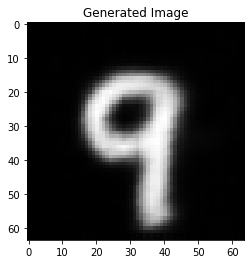

Epoch 201/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.15it/s]

Epoch [201/500], Loss: 63251.2422 (total loss), 60167.8672 (bce), 3083.3743 (kld)
Mu range: -0.5036009550094604 ~ 1.4478687047958374, Logvar range: -5.41285514831543 ~ -0.0881173238158226
tensor(9)


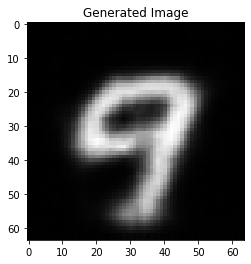

Epoch 202/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.00it/s]

Epoch [202/500], Loss: 66973.4922 (total loss), 63833.7578 (bce), 3139.7351 (kld)
Mu range: -0.7308320999145508 ~ 2.239293336868286, Logvar range: -7.473221778869629 ~ -0.03894960135221481
tensor(9)


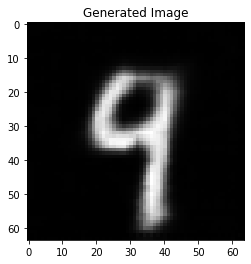

Epoch 203/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.09it/s]


Epoch [203/500], Loss: 66203.4922 (total loss), 63149.3906 (bce), 3054.1011 (kld)
Mu range: -3.0010082721710205 ~ 1.7557274103164673, Logvar range: -7.504643440246582 ~ 0.014936089515686035
tensor(6)


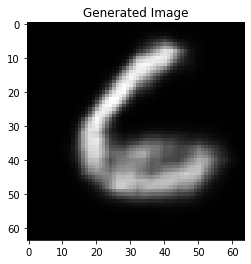

Epoch 204/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.29it/s]


Epoch [204/500], Loss: 64518.6758 (total loss), 61342.2656 (bce), 3176.4092 (kld)
Mu range: -3.4409468173980713 ~ 3.76198673248291, Logvar range: -7.203737258911133 ~ 0.2629261612892151
tensor(0)


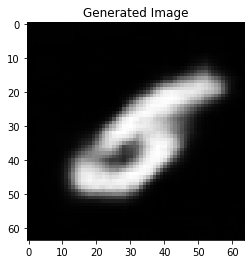

Epoch 205/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.13it/s]

Epoch [205/500], Loss: 67578.9297 (total loss), 64486.9141 (bce), 3092.0132 (kld)
Mu range: -1.1951136589050293 ~ 2.9791808128356934, Logvar range: -7.348114490509033 ~ -0.007549382746219635
tensor(2)


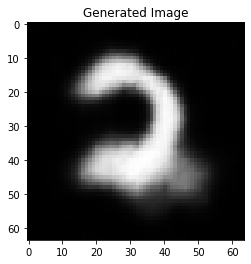

Epoch 206/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.95it/s]

Epoch [206/500], Loss: 63349.9609 (total loss), 60240.4141 (bce), 3109.5479 (kld)
Mu range: -1.7047815322875977 ~ 2.924583673477173, Logvar range: -6.1576619148254395 ~ 0.06904521584510803
tensor(7)


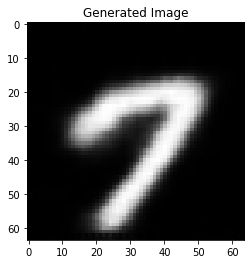

Epoch 207/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.73it/s]


Epoch [207/500], Loss: 64338.6719 (total loss), 61239.9609 (bce), 3098.7100 (kld)
Mu range: -1.7127976417541504 ~ 1.2257335186004639, Logvar range: -5.891735076904297 ~ -0.027319233864545822
tensor(4)


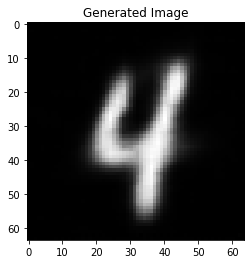

Epoch 208/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.12it/s]


Epoch [208/500], Loss: 70763.1641 (total loss), 67810.6797 (bce), 2952.4817 (kld)
Mu range: -1.182673692703247 ~ 2.1381828784942627, Logvar range: -7.439420700073242 ~ -0.007700059562921524
tensor(9)


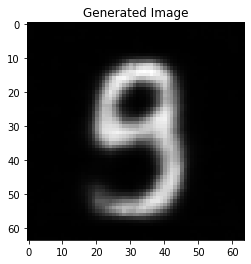

Epoch 209/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.13it/s]


Epoch [209/500], Loss: 66388.4531 (total loss), 63440.0781 (bce), 2948.3743 (kld)
Mu range: -3.8076322078704834 ~ 3.333350896835327, Logvar range: -8.166680335998535 ~ -0.036450181156396866
tensor(4)


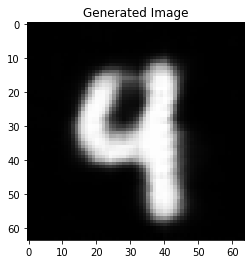

Epoch 210/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.18it/s]


Epoch [210/500], Loss: 65775.5547 (total loss), 62703.5508 (bce), 3072.0015 (kld)
Mu range: -1.685388445854187 ~ 0.94451504945755, Logvar range: -5.140183448791504 ~ -0.02345079928636551
tensor(8)


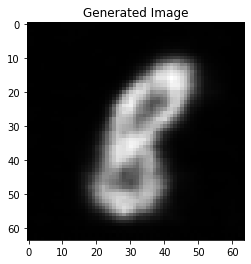

Epoch 211/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.04it/s]


Epoch [211/500], Loss: 70910.8438 (total loss), 67855.3281 (bce), 3055.5142 (kld)
Mu range: -1.9037877321243286 ~ 0.8803099393844604, Logvar range: -6.8362650871276855 ~ 0.025899197906255722
tensor(1)


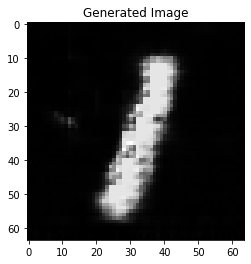

Epoch 212/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.20it/s]


Epoch [212/500], Loss: 68503.0391 (total loss), 65232.4375 (bce), 3270.5989 (kld)
Mu range: -2.6343140602111816 ~ 2.9816102981567383, Logvar range: -6.928319931030273 ~ 0.0167107991874218
tensor(7)


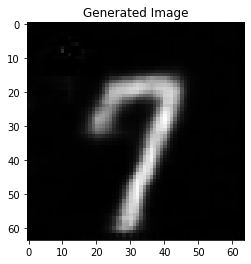

Epoch 213/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.98it/s]

Epoch [213/500], Loss: 64242.2070 (total loss), 61218.0781 (bce), 3024.1279 (kld)
Mu range: -0.5753117799758911 ~ 1.5502750873565674, Logvar range: -6.122239112854004 ~ -0.06338480114936829
tensor(4)


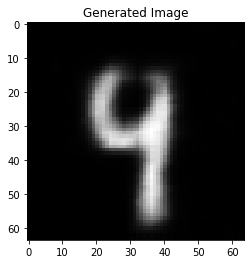

Epoch 214/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.24it/s]

Epoch [214/500], Loss: 70167.4688 (total loss), 67111.6016 (bce), 3055.8711 (kld)
Mu range: -2.799809217453003 ~ 2.682466506958008, Logvar range: -7.071732521057129 ~ 0.2004772126674652
tensor(2)


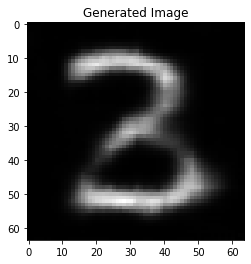

Epoch 215/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.32it/s]

Epoch [215/500], Loss: 68479.1328 (total loss), 65235.2031 (bce), 3243.9333 (kld)
Mu range: -2.1055333614349365 ~ 2.62503719329834, Logvar range: -7.620412349700928 ~ 0.04344204068183899
tensor(4)


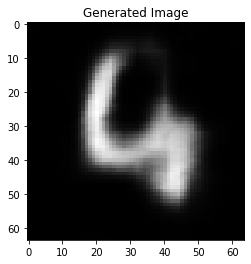

Epoch 216/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.18it/s]


Epoch [216/500], Loss: 67516.4141 (total loss), 64437.0898 (bce), 3079.3276 (kld)
Mu range: -1.2092639207839966 ~ 1.8404605388641357, Logvar range: -7.103239059448242 ~ -0.026167791336774826
tensor(5)


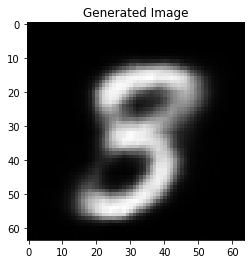

Epoch 217/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.08it/s]

Epoch [217/500], Loss: 64664.6445 (total loss), 61604.0938 (bce), 3060.5508 (kld)
Mu range: -0.4180319607257843 ~ 1.1292299032211304, Logvar range: -5.686377048492432 ~ -0.024979867041110992
tensor(9)


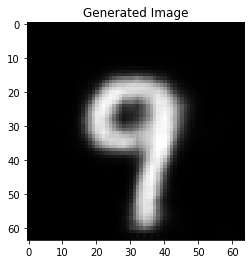

Epoch 218/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.39it/s]


Epoch [218/500], Loss: 66183.2969 (total loss), 63119.1836 (bce), 3064.1162 (kld)
Mu range: -2.337050199508667 ~ 1.5024677515029907, Logvar range: -6.712080001831055 ~ -0.04064265638589859
tensor(4)


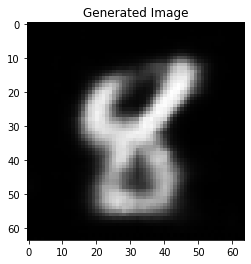

Epoch 219/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.89it/s]


Epoch [219/500], Loss: 66833.7656 (total loss), 63738.4023 (bce), 3095.3611 (kld)
Mu range: -2.4483675956726074 ~ 2.5985846519470215, Logvar range: -7.025845050811768 ~ -0.05041138827800751
tensor(7)


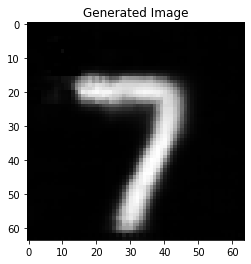

Epoch 220/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.03it/s]


Epoch [220/500], Loss: 61381.3711 (total loss), 58230.9258 (bce), 3150.4448 (kld)
Mu range: -3.1516852378845215 ~ 1.9676107168197632, Logvar range: -7.764930725097656 ~ 0.3746068477630615
tensor(1)


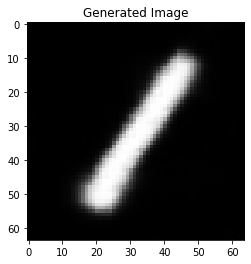

Epoch 221/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.78it/s]


Epoch [221/500], Loss: 69505.5469 (total loss), 66315.5625 (bce), 3189.9863 (kld)
Mu range: -1.9659684896469116 ~ 1.9905680418014526, Logvar range: -7.065545558929443 ~ 0.03932696580886841
tensor(6)


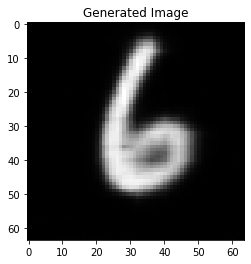

Epoch 222/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.44it/s]


Epoch [222/500], Loss: 65992.8125 (total loss), 62885.1172 (bce), 3107.6960 (kld)
Mu range: -2.4931209087371826 ~ 1.1920924186706543, Logvar range: -5.750284671783447 ~ -0.02913499064743519
tensor(0)


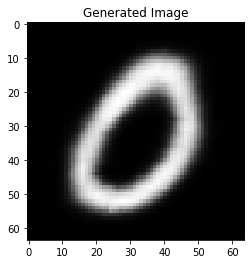

Epoch 223/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.54it/s]


Epoch [223/500], Loss: 70004.1250 (total loss), 66832.8828 (bce), 3171.2383 (kld)
Mu range: -4.430893421173096 ~ 4.809683322906494, Logvar range: -7.000030517578125 ~ 0.05356296896934509
tensor(2)


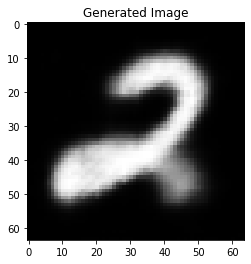

Epoch 224/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.52it/s]


Epoch [224/500], Loss: 66090.0625 (total loss), 62904.6484 (bce), 3185.4116 (kld)
Mu range: -1.9568203687667847 ~ 2.2162270545959473, Logvar range: -6.336087226867676 ~ -0.04188206419348717
tensor(0)


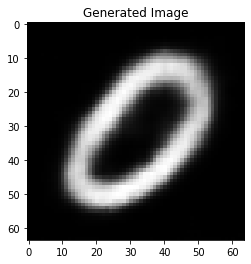

Epoch 225/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.85it/s]


Epoch [225/500], Loss: 68139.2500 (total loss), 64982.6211 (bce), 3156.6265 (kld)
Mu range: -1.2815409898757935 ~ 0.8021311163902283, Logvar range: -4.9405012130737305 ~ -0.015828393399715424
tensor(9)


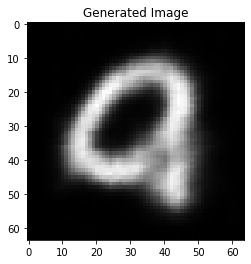

Epoch 226/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.28it/s]


Epoch [226/500], Loss: 65570.2656 (total loss), 62426.5547 (bce), 3143.7114 (kld)
Mu range: -3.0703327655792236 ~ 1.1439052820205688, Logvar range: -7.151281356811523 ~ -0.0030008554458618164
tensor(8)


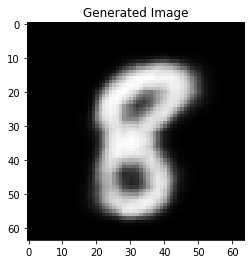

Epoch 227/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.39it/s]

Epoch [227/500], Loss: 70777.5859 (total loss), 67535.7734 (bce), 3241.8149 (kld)
Mu range: -0.8294447064399719 ~ 1.2840397357940674, Logvar range: -5.631251335144043 ~ -0.03409696742892265
tensor(7)


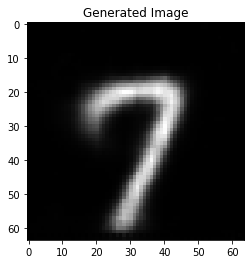

Epoch 228/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.56it/s]

Epoch [228/500], Loss: 64084.0312 (total loss), 60914.7578 (bce), 3169.2729 (kld)
Mu range: -1.5467289686203003 ~ 1.5860636234283447, Logvar range: -6.502553462982178 ~ 0.049455493688583374
tensor(6)


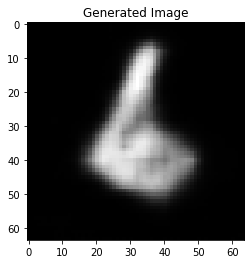

Epoch 229/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.44it/s]


Epoch [229/500], Loss: 64397.4688 (total loss), 61121.3398 (bce), 3276.1304 (kld)
Mu range: -1.5921889543533325 ~ 2.1461362838745117, Logvar range: -7.458932876586914 ~ 0.048273615539073944
tensor(1)


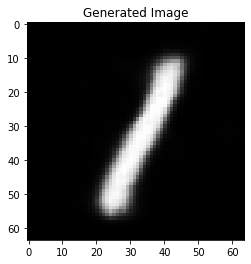

Epoch 230/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.46it/s]

Epoch [230/500], Loss: 64786.2422 (total loss), 61765.2500 (bce), 3020.9912 (kld)
Mu range: -1.0206528902053833 ~ 1.9542675018310547, Logvar range: -6.334951400756836 ~ -0.008584193885326385
tensor(9)


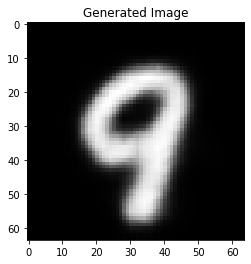

Epoch 231/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.09it/s]

Epoch [231/500], Loss: 66637.0000 (total loss), 63546.1328 (bce), 3090.8647 (kld)
Mu range: -2.021523952484131 ~ 1.7362748384475708, Logvar range: -6.532676696777344 ~ 0.006762567907571793
tensor(1)


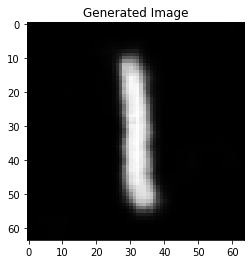

Epoch 232/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.25it/s]


Epoch [232/500], Loss: 68672.3984 (total loss), 65516.3984 (bce), 3156.0029 (kld)
Mu range: -2.2889175415039062 ~ 2.0544357299804688, Logvar range: -6.1419548988342285 ~ -0.04927099496126175
tensor(0)


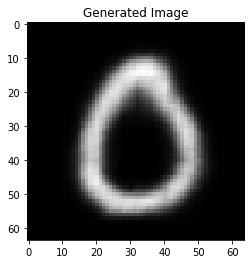

Epoch 233/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.14it/s]


Epoch [233/500], Loss: 67518.5781 (total loss), 64493.0469 (bce), 3025.5315 (kld)
Mu range: -1.8145861625671387 ~ 1.5129456520080566, Logvar range: -6.639045238494873 ~ 0.025199297815561295
tensor(4)


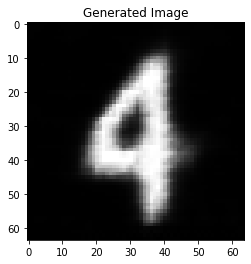

Epoch 234/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.32it/s]

Epoch [234/500], Loss: 67800.3281 (total loss), 64584.7344 (bce), 3215.5903 (kld)
Mu range: -1.2238361835479736 ~ 1.1401128768920898, Logvar range: -6.4084882736206055 ~ -0.036910220980644226
tensor(1)


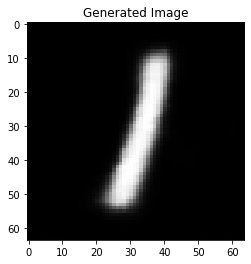

Epoch 235/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.12it/s]


Epoch [235/500], Loss: 68092.8203 (total loss), 65069.2734 (bce), 3023.5503 (kld)
Mu range: -1.7247234582901 ~ 2.4300343990325928, Logvar range: -8.140249252319336 ~ 0.031229514628648758
tensor(7)


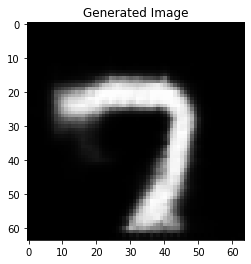

Epoch 236/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.19it/s]

Epoch [236/500], Loss: 63002.4453 (total loss), 59925.1719 (bce), 3077.2747 (kld)
Mu range: -1.1617703437805176 ~ 2.0581436157226562, Logvar range: -5.718621730804443 ~ 0.021304000169038773
tensor(1)


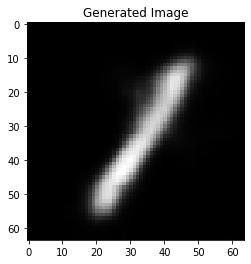

Epoch 237/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.06it/s]

Epoch [237/500], Loss: 68180.0547 (total loss), 65108.0586 (bce), 3071.9968 (kld)
Mu range: -2.857360363006592 ~ 1.8393590450286865, Logvar range: -6.448919296264648 ~ -0.001113012433052063
tensor(2)


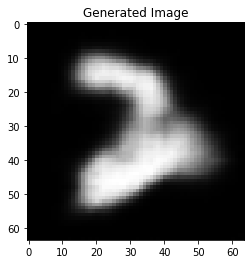

Epoch 238/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.16it/s]

Epoch [238/500], Loss: 66529.6250 (total loss), 63418.1758 (bce), 3111.4502 (kld)
Mu range: -1.984561562538147 ~ 0.7531912922859192, Logvar range: -5.547212600708008 ~ -0.02029101736843586
tensor(6)


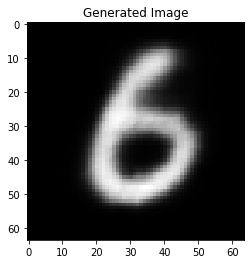

Epoch 239/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.00it/s]


Epoch [239/500], Loss: 65852.9844 (total loss), 62714.6758 (bce), 3138.3062 (kld)
Mu range: -0.7662752866744995 ~ 1.073656678199768, Logvar range: -5.821559429168701 ~ -0.0431017205119133
tensor(7)


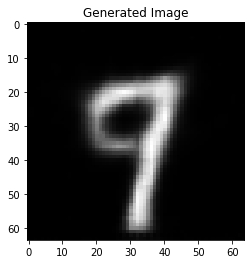

Epoch 240/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.36it/s]


Epoch [240/500], Loss: 66351.4219 (total loss), 63258.9766 (bce), 3092.4443 (kld)
Mu range: -0.6891775131225586 ~ 1.0186163187026978, Logvar range: -5.893904209136963 ~ -0.023757539689540863
tensor(9)


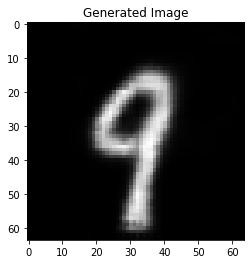

Epoch 241/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.33it/s]

Epoch [241/500], Loss: 67765.7266 (total loss), 64579.8633 (bce), 3185.8652 (kld)
Mu range: -0.8380849361419678 ~ 0.9642135500907898, Logvar range: -6.14727783203125 ~ -0.026681382209062576
tensor(0)


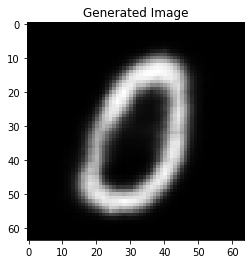

Epoch 242/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.18it/s]

Epoch [242/500], Loss: 66376.9062 (total loss), 63250.4844 (bce), 3126.4187 (kld)
Mu range: -2.4836583137512207 ~ 2.862253189086914, Logvar range: -7.425210952758789 ~ -0.012340489774942398
tensor(9)


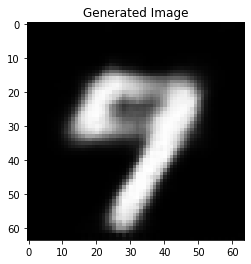

Epoch 243/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.51it/s]


Epoch [243/500], Loss: 64581.7969 (total loss), 61453.4648 (bce), 3128.3311 (kld)
Mu range: -1.2020248174667358 ~ 1.306100845336914, Logvar range: -6.380012512207031 ~ -0.025301527231931686
tensor(2)


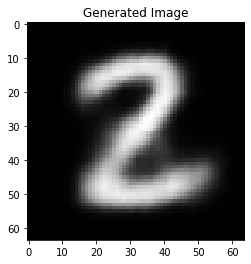

Epoch 244/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.31it/s]


Epoch [244/500], Loss: 65165.0859 (total loss), 61930.7539 (bce), 3234.3323 (kld)
Mu range: -1.9529898166656494 ~ 2.3337490558624268, Logvar range: -6.491987705230713 ~ -0.029768329113721848
tensor(2)


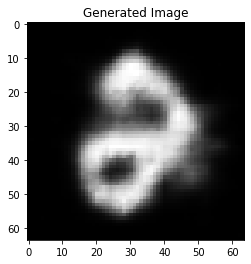

Epoch 245/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.38it/s]


Epoch [245/500], Loss: 63764.7188 (total loss), 60594.5820 (bce), 3170.1384 (kld)
Mu range: -3.651906967163086 ~ 1.497436761856079, Logvar range: -7.520500183105469 ~ 0.09009444713592529
tensor(4)


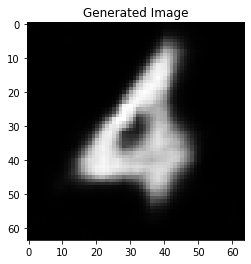

Epoch 246/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.17it/s]

Epoch [246/500], Loss: 69415.9766 (total loss), 66241.0000 (bce), 3174.9785 (kld)
Mu range: -1.8828507661819458 ~ 1.0362528562545776, Logvar range: -7.767055988311768 ~ 0.0038651227951049805
tensor(3)


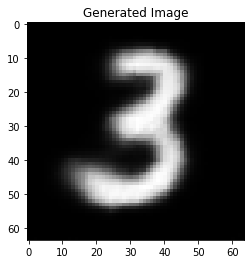

Epoch 247/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.21it/s]

Epoch [247/500], Loss: 66663.5156 (total loss), 63514.6172 (bce), 3148.8960 (kld)
Mu range: -1.2310222387313843 ~ 0.40575650334358215, Logvar range: -5.52882719039917 ~ -0.03292050585150719
tensor(3)


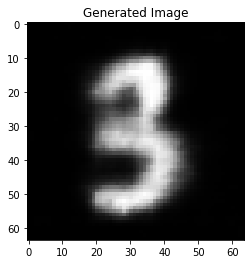

Epoch 248/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.29it/s]


Epoch [248/500], Loss: 64590.1992 (total loss), 61525.4922 (bce), 3064.7073 (kld)
Mu range: -1.6074544191360474 ~ 2.6039953231811523, Logvar range: -7.473513603210449 ~ 0.002309858798980713
tensor(9)


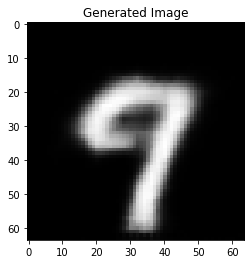

Epoch 249/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.41it/s]


Epoch [249/500], Loss: 65834.1562 (total loss), 62853.3750 (bce), 2980.7852 (kld)
Mu range: -2.9704833030700684 ~ 3.1479852199554443, Logvar range: -7.9413886070251465 ~ 0.05673626437783241
tensor(4)


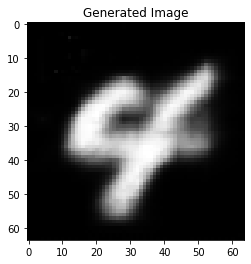

Epoch 250/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.31it/s]

Epoch [250/500], Loss: 63802.4648 (total loss), 60630.3242 (bce), 3172.1396 (kld)
Mu range: -0.843133807182312 ~ 1.6396328210830688, Logvar range: -5.90999174118042 ~ -0.023391269147396088
tensor(8)


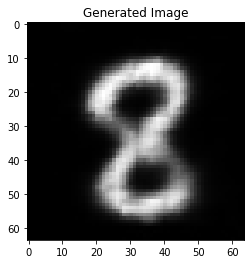

Epoch 251/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.50it/s]


Epoch [251/500], Loss: 65572.6484 (total loss), 62425.8867 (bce), 3146.7642 (kld)
Mu range: -1.9023760557174683 ~ 2.4131009578704834, Logvar range: -8.966188430786133 ~ 0.017232686281204224
tensor(3)


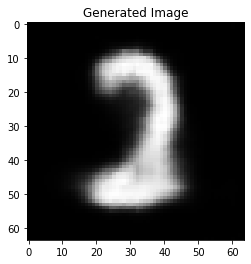

Epoch 252/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.35it/s]

Epoch [252/500], Loss: 66356.6016 (total loss), 63274.4727 (bce), 3082.1323 (kld)
Mu range: -1.6730098724365234 ~ 1.2240581512451172, Logvar range: -5.99675989151001 ~ -0.027997422963380814
tensor(9)


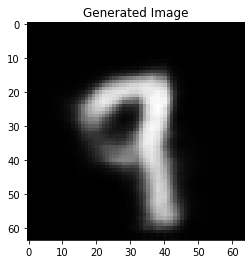

Epoch 253/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]


Epoch [253/500], Loss: 65466.3203 (total loss), 62349.7734 (bce), 3116.5459 (kld)
Mu range: -2.0496442317962646 ~ 1.3249542713165283, Logvar range: -6.139634132385254 ~ -0.0046648625284433365
tensor(0)


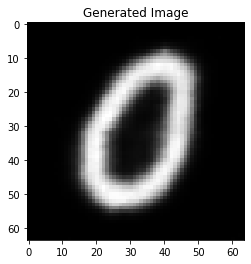

Epoch 254/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.27it/s]


Epoch [254/500], Loss: 65714.1094 (total loss), 62556.5625 (bce), 3157.5447 (kld)
Mu range: -1.398268222808838 ~ 1.046250343322754, Logvar range: -5.820290565490723 ~ 0.008077703416347504
tensor(4)


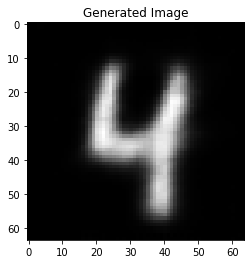

Epoch 255/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.06it/s]


Epoch [255/500], Loss: 65716.8516 (total loss), 62608.5234 (bce), 3108.3318 (kld)
Mu range: -1.9193086624145508 ~ 1.8869260549545288, Logvar range: -5.469056129455566 ~ -0.007021330296993256
tensor(2)


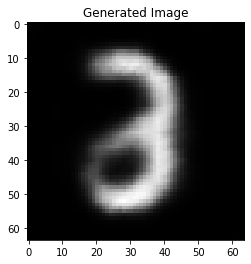

Epoch 256/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.76it/s]


Epoch [256/500], Loss: 64928.6172 (total loss), 61743.8984 (bce), 3184.7168 (kld)
Mu range: -1.41240656375885 ~ 1.0960628986358643, Logvar range: -5.52583122253418 ~ -0.02071481943130493
tensor(7)


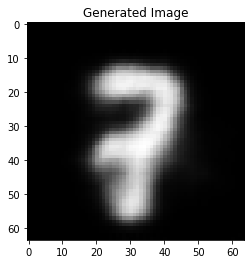

Epoch 257/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]


Epoch [257/500], Loss: 74062.1484 (total loss), 70962.5000 (bce), 3099.6458 (kld)
Mu range: -1.297509789466858 ~ 2.6797049045562744, Logvar range: -6.882424354553223 ~ 0.02012057974934578
tensor(2)


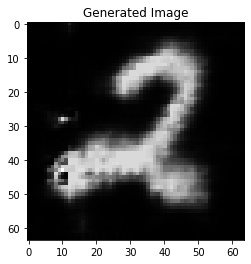

Epoch 258/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.25it/s]


Epoch [258/500], Loss: 65311.5820 (total loss), 62212.3555 (bce), 3099.2261 (kld)
Mu range: -1.4558563232421875 ~ 1.4597904682159424, Logvar range: -6.2503509521484375 ~ 0.06343373656272888
tensor(6)


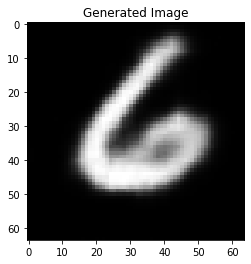

Epoch 259/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.14it/s]


Epoch [259/500], Loss: 63804.0898 (total loss), 60634.7500 (bce), 3169.3416 (kld)
Mu range: -1.4038187265396118 ~ 1.7490463256835938, Logvar range: -7.371240615844727 ~ -0.017043888568878174
tensor(1)


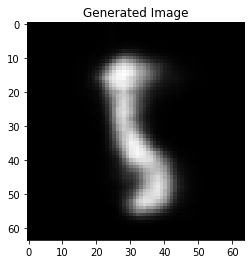

Epoch 260/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.53it/s]


Epoch [260/500], Loss: 70463.0938 (total loss), 67255.6953 (bce), 3207.3948 (kld)
Mu range: -2.7488558292388916 ~ 2.8812315464019775, Logvar range: -7.499578475952148 ~ 0.034893304109573364
tensor(2)


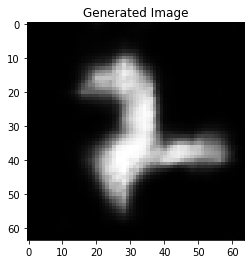

Epoch 261/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.58it/s]


Epoch [261/500], Loss: 68087.7656 (total loss), 64967.2734 (bce), 3120.4937 (kld)
Mu range: -5.06567907333374 ~ 3.978142499923706, Logvar range: -7.443881034851074 ~ 0.1062154769897461
tensor(0)


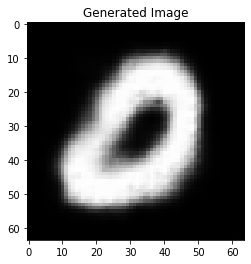

Epoch 262/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.32it/s]

Epoch [262/500], Loss: 61932.0156 (total loss), 58884.6289 (bce), 3047.3850 (kld)
Mu range: -0.6258264183998108 ~ 1.6515474319458008, Logvar range: -5.859870910644531 ~ -0.014259151183068752
tensor(4)


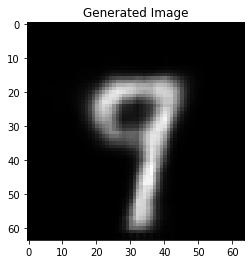

Epoch 263/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.48it/s]


Epoch [263/500], Loss: 68881.3672 (total loss), 65862.9062 (bce), 3018.4612 (kld)
Mu range: -1.4587920904159546 ~ 1.2231961488723755, Logvar range: -5.027942657470703 ~ -0.009226903319358826
tensor(6)


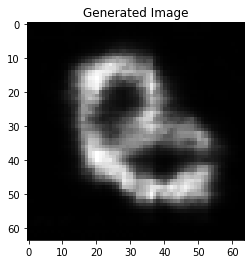

Epoch 264/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.56it/s]


Epoch [264/500], Loss: 65427.2773 (total loss), 62328.6797 (bce), 3098.5986 (kld)
Mu range: -1.4851932525634766 ~ 2.3319852352142334, Logvar range: -6.40897274017334 ~ 0.0030465740710496902
tensor(3)


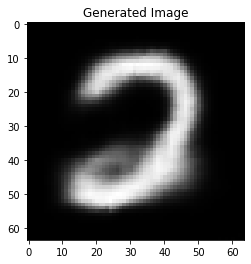

Epoch 265/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.64it/s]


Epoch [265/500], Loss: 63850.7852 (total loss), 60743.8281 (bce), 3106.9570 (kld)
Mu range: -1.5297324657440186 ~ 0.8333075046539307, Logvar range: -6.732810020446777 ~ -0.004009028896689415
tensor(3)


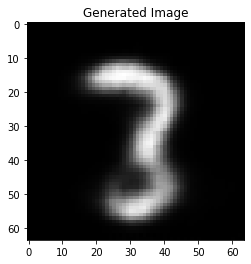

Epoch 266/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.66it/s]


Epoch [266/500], Loss: 66585.4531 (total loss), 63434.6562 (bce), 3150.7954 (kld)
Mu range: -0.8880331516265869 ~ 1.063227891921997, Logvar range: -5.461762428283691 ~ -0.03380613401532173
tensor(7)


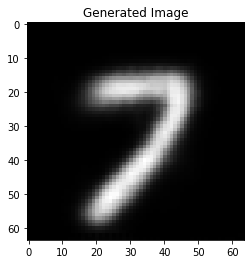

Epoch 267/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.59it/s]


Epoch [267/500], Loss: 64531.0469 (total loss), 61523.7188 (bce), 3007.3296 (kld)
Mu range: -0.8429038524627686 ~ 2.0902035236358643, Logvar range: -5.583853721618652 ~ -0.01792031340301037
tensor(9)


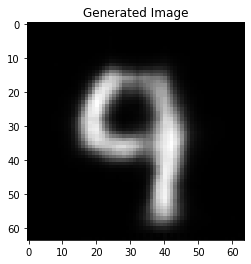

Epoch 268/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]

Epoch [268/500], Loss: 67017.6484 (total loss), 63949.4961 (bce), 3068.1487 (kld)
Mu range: -1.1098923683166504 ~ 0.6513416171073914, Logvar range: -4.8431878089904785 ~ -0.011504394933581352
tensor(9)


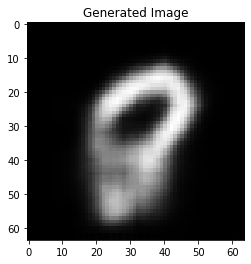

Epoch 269/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.36it/s]

Epoch [269/500], Loss: 70203.7109 (total loss), 66913.8516 (bce), 3289.8560 (kld)
Mu range: -2.0016298294067383 ~ 3.0750627517700195, Logvar range: -6.743352890014648 ~ -0.03688542917370796
tensor(3)


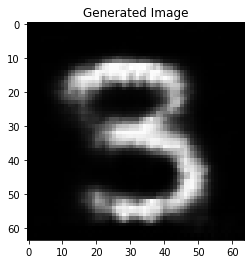

Epoch 270/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.37it/s]


Epoch [270/500], Loss: 66596.1641 (total loss), 63502.0508 (bce), 3094.1157 (kld)
Mu range: -1.1102954149246216 ~ 1.4011117219924927, Logvar range: -6.0562286376953125 ~ 0.003607099875807762
tensor(2)


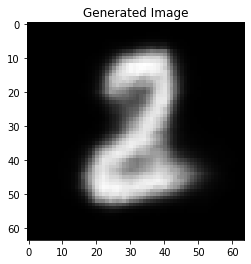

Epoch 271/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.47it/s]

Epoch [271/500], Loss: 69298.6641 (total loss), 66172.7344 (bce), 3125.9302 (kld)
Mu range: -1.9255874156951904 ~ 2.006459951400757, Logvar range: -6.39797306060791 ~ -0.00908881425857544
tensor(4)


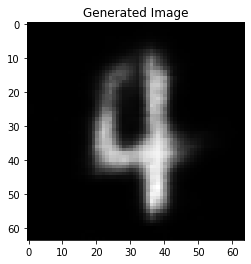

Epoch 272/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.22it/s]

Epoch [272/500], Loss: 66603.3594 (total loss), 63434.7188 (bce), 3168.6392 (kld)
Mu range: -1.7791316509246826 ~ 2.429896116256714, Logvar range: -4.930799961090088 ~ -0.006799273192882538
tensor(2)


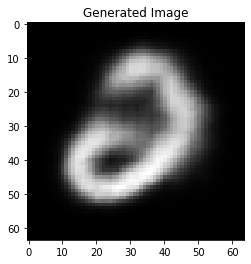

Epoch 273/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]


Epoch [273/500], Loss: 65632.6484 (total loss), 62568.9375 (bce), 3063.7083 (kld)
Mu range: -1.455022931098938 ~ 0.9160051345825195, Logvar range: -5.751395225524902 ~ -0.03214886039495468
tensor(4)


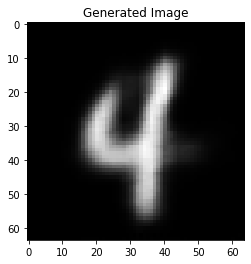

Epoch 274/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.20it/s]

Epoch [274/500], Loss: 69982.6172 (total loss), 66826.2344 (bce), 3156.3821 (kld)
Mu range: -2.314846992492676 ~ 2.125148296356201, Logvar range: -8.28390884399414 ~ 0.06227979063987732
tensor(6)


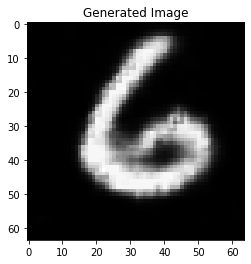

Epoch 275/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.55it/s]


Epoch [275/500], Loss: 67521.8516 (total loss), 64383.9961 (bce), 3137.8577 (kld)
Mu range: -2.6491293907165527 ~ 1.6515737771987915, Logvar range: -7.009039878845215 ~ -0.0007302463054656982
tensor(1)


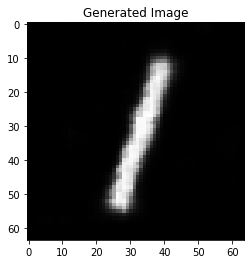

Epoch 276/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.58it/s]

Epoch [276/500], Loss: 66627.7031 (total loss), 63351.1641 (bce), 3276.5425 (kld)
Mu range: -2.967546224594116 ~ 2.782327651977539, Logvar range: -6.858967304229736 ~ -0.02392573282122612
tensor(2)


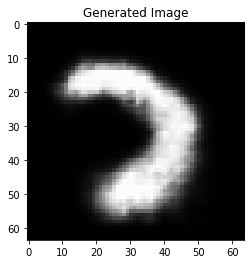

Epoch 277/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.41it/s]

Epoch [277/500], Loss: 65231.8750 (total loss), 62050.0938 (bce), 3181.7805 (kld)
Mu range: -2.32069993019104 ~ 0.634676456451416, Logvar range: -6.418003082275391 ~ 0.0025939475744962692
tensor(1)


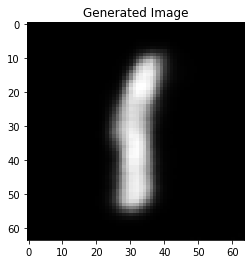

Epoch 278/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.35it/s]

Epoch [278/500], Loss: 66042.5469 (total loss), 62884.5156 (bce), 3158.0298 (kld)
Mu range: -1.1195752620697021 ~ 1.4942445755004883, Logvar range: -5.9916276931762695 ~ 0.0071973614394664764
tensor(0)


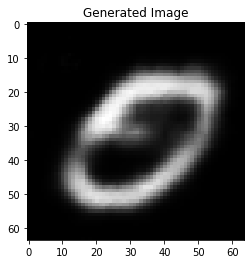

Epoch 279/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.25it/s]


Epoch [279/500], Loss: 68258.5312 (total loss), 65021.9258 (bce), 3236.6021 (kld)
Mu range: -2.3727564811706543 ~ 1.4041802883148193, Logvar range: -7.208027362823486 ~ 0.06301844120025635
tensor(8)


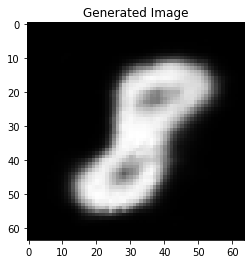

Epoch 280/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.07it/s]

Epoch [280/500], Loss: 64731.9336 (total loss), 61554.7188 (bce), 3177.2148 (kld)
Mu range: -1.3671679496765137 ~ 0.6988388895988464, Logvar range: -6.053134441375732 ~ -0.012198817916214466
tensor(2)


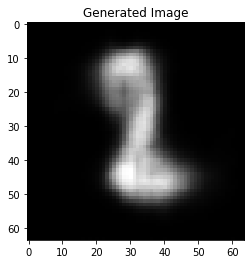

Epoch 281/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.27it/s]

Epoch [281/500], Loss: 64839.5781 (total loss), 61635.7031 (bce), 3203.8755 (kld)
Mu range: -1.1146835088729858 ~ 1.5755903720855713, Logvar range: -5.70562744140625 ~ -0.02816208079457283
tensor(4)


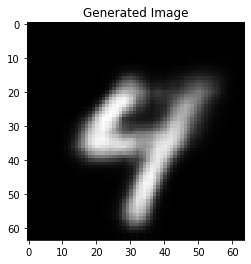

Epoch 282/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.35it/s]


Epoch [282/500], Loss: 63474.5000 (total loss), 60238.8828 (bce), 3235.6191 (kld)
Mu range: -1.3561018705368042 ~ 2.0594518184661865, Logvar range: -7.054477691650391 ~ -0.007682599127292633
tensor(9)


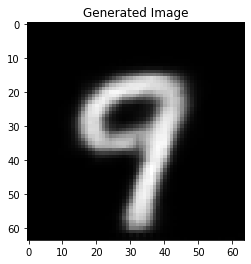

Epoch 283/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.18it/s]

Epoch [283/500], Loss: 64360.9219 (total loss), 61264.7773 (bce), 3096.1426 (kld)
Mu range: -1.461064338684082 ~ 1.5349870920181274, Logvar range: -5.159548282623291 ~ -0.009081598371267319
tensor(5)


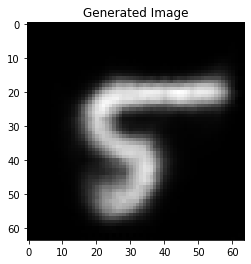

Epoch 284/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.44it/s]

Epoch [284/500], Loss: 65887.9141 (total loss), 62721.3945 (bce), 3166.5215 (kld)
Mu range: -2.021287441253662 ~ 0.6484248638153076, Logvar range: -5.49613618850708 ~ 0.007030028849840164
tensor(6)


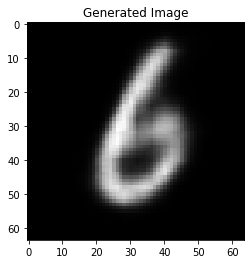

Epoch 285/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.34it/s]


Epoch [285/500], Loss: 63938.1211 (total loss), 60826.3906 (bce), 3111.7305 (kld)
Mu range: -2.5261402130126953 ~ 1.3121323585510254, Logvar range: -6.060560703277588 ~ 0.02915394864976406
tensor(3)


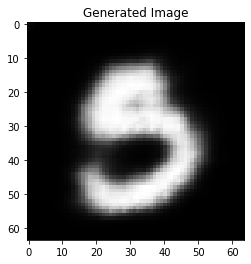

Epoch 286/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.41it/s]


Epoch [286/500], Loss: 65245.9375 (total loss), 62196.0703 (bce), 3049.8691 (kld)
Mu range: -1.590965747833252 ~ 1.750543475151062, Logvar range: -5.893444061279297 ~ 0.0006634071469306946
tensor(0)


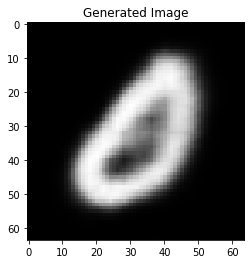

Epoch 287/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.70it/s]

Epoch [287/500], Loss: 65219.0469 (total loss), 62044.8750 (bce), 3174.1726 (kld)
Mu range: -0.7744196057319641 ~ 0.9233777523040771, Logvar range: -5.055507183074951 ~ -0.015456867404282093
tensor(2)


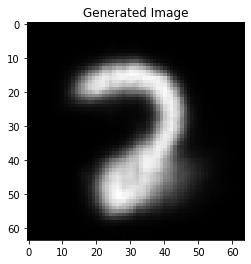

Epoch 288/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.20it/s]


Epoch [288/500], Loss: 68757.3047 (total loss), 65693.3906 (bce), 3063.9116 (kld)
Mu range: -1.6607987880706787 ~ 1.8595789670944214, Logvar range: -6.847238540649414 ~ 0.008084733039140701
tensor(3)


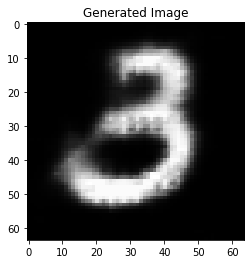

Epoch 289/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.99it/s]

Epoch [289/500], Loss: 67239.2500 (total loss), 64129.6719 (bce), 3109.5801 (kld)
Mu range: -0.5480644702911377 ~ 0.6241097450256348, Logvar range: -5.2917351722717285 ~ -0.013992680236697197
tensor(8)


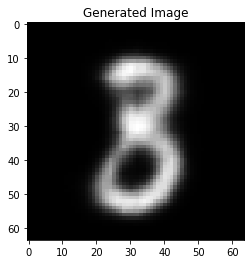

Epoch 290/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.18it/s]


Epoch [290/500], Loss: 69366.1875 (total loss), 66127.4297 (bce), 3238.7578 (kld)
Mu range: -0.7670036554336548 ~ 1.1732779741287231, Logvar range: -5.358730792999268 ~ -0.017620278522372246
tensor(5)


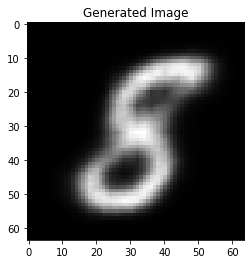

Epoch 291/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.30it/s]


Epoch [291/500], Loss: 68518.2656 (total loss), 65320.5430 (bce), 3197.7190 (kld)
Mu range: -2.153503179550171 ~ 0.8556531071662903, Logvar range: -6.619684219360352 ~ 0.00669512152671814
tensor(8)


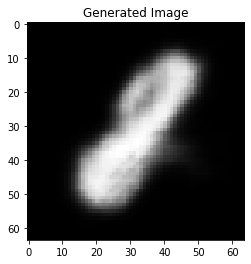

Epoch 292/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.26it/s]


Epoch [292/500], Loss: 66566.9688 (total loss), 63487.2266 (bce), 3079.7402 (kld)
Mu range: -2.7642972469329834 ~ 0.5383726358413696, Logvar range: -6.991808891296387 ~ -0.0024782326072454453
tensor(6)


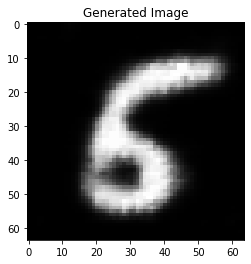

Epoch 293/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.40it/s]


Epoch [293/500], Loss: 68546.2109 (total loss), 65517.7383 (bce), 3028.4753 (kld)
Mu range: -2.0843701362609863 ~ 2.4213216304779053, Logvar range: -6.816118240356445 ~ -0.017887944355607033
tensor(7)


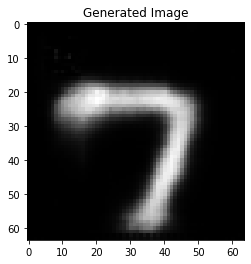

Epoch 294/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.34it/s]


Epoch [294/500], Loss: 67330.4766 (total loss), 64062.0117 (bce), 3268.4617 (kld)
Mu range: -2.5408551692962646 ~ 1.449858546257019, Logvar range: -7.218621253967285 ~ 0.0459565669298172
tensor(6)


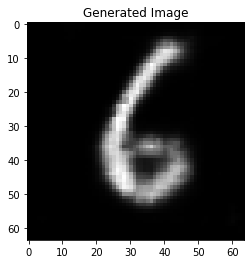

Epoch 295/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.14it/s]

Epoch [295/500], Loss: 68766.1406 (total loss), 65570.2266 (bce), 3195.9175 (kld)
Mu range: -2.3941662311553955 ~ 2.8470823764801025, Logvar range: -7.140334129333496 ~ 0.012538885697722435
tensor(6)


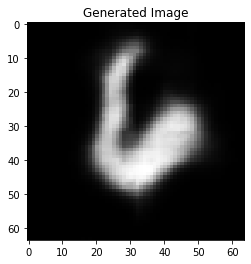

Epoch 296/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.30it/s]

Epoch [296/500], Loss: 65275.3672 (total loss), 62110.2227 (bce), 3165.1465 (kld)
Mu range: -1.8242496252059937 ~ 0.8793496489524841, Logvar range: -5.490158557891846 ~ -0.004309883341193199
tensor(4)


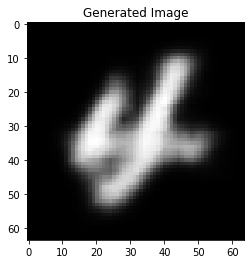

Epoch 297/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.38it/s]


Epoch [297/500], Loss: 65243.7578 (total loss), 62111.1133 (bce), 3132.6448 (kld)
Mu range: -2.6449191570281982 ~ 1.5205470323562622, Logvar range: -7.0293684005737305 ~ -0.008935868740081787
tensor(5)


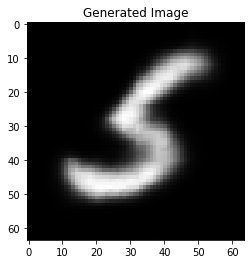

Epoch 298/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]


Epoch [298/500], Loss: 63539.8828 (total loss), 60306.2812 (bce), 3233.5996 (kld)
Mu range: -2.1145827770233154 ~ 1.9117650985717773, Logvar range: -6.912310600280762 ~ -0.0027068722993135452
tensor(5)


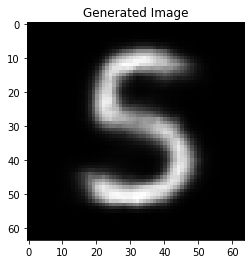

Epoch 299/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.41it/s]


Epoch [299/500], Loss: 67353.9141 (total loss), 64206.0586 (bce), 3147.8525 (kld)
Mu range: -1.5506929159164429 ~ 1.7516552209854126, Logvar range: -7.167233467102051 ~ -0.02350548841059208
tensor(2)


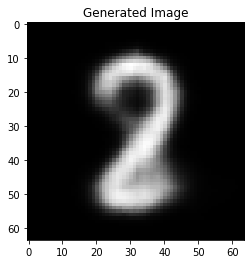

Epoch 300/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.51it/s]


Epoch [300/500], Loss: 71538.9453 (total loss), 68426.3281 (bce), 3112.6143 (kld)
Mu range: -2.5484061241149902 ~ 2.4705159664154053, Logvar range: -7.909334182739258 ~ 0.04989689588546753
tensor(5)


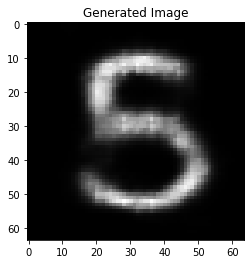

Epoch 301/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.29it/s]

Epoch [301/500], Loss: 63967.7305 (total loss), 60812.6367 (bce), 3155.0952 (kld)
Mu range: -2.8253278732299805 ~ 2.309187650680542, Logvar range: -6.017883777618408 ~ -0.018102537840604782
tensor(3)


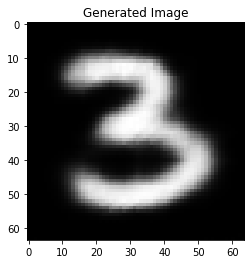

Epoch 302/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.30it/s]

Epoch [302/500], Loss: 67054.6484 (total loss), 64008.3477 (bce), 3046.2971 (kld)
Mu range: -2.6784842014312744 ~ 1.6846116781234741, Logvar range: -7.3389692306518555 ~ 0.08302533626556396
tensor(1)


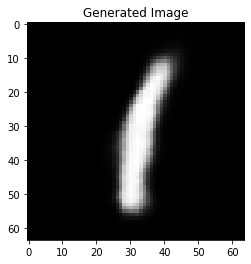

Epoch 303/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.40it/s]


Epoch [303/500], Loss: 65203.7305 (total loss), 61991.3828 (bce), 3212.3472 (kld)
Mu range: -2.4113686084747314 ~ 1.5293904542922974, Logvar range: -7.391265869140625 ~ -0.002147957682609558
tensor(9)


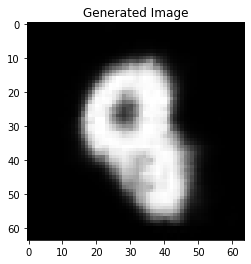

Epoch 304/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.47it/s]


Epoch [304/500], Loss: 64204.5820 (total loss), 60899.9844 (bce), 3304.5984 (kld)
Mu range: -1.3047853708267212 ~ 0.327023983001709, Logvar range: -6.605048179626465 ~ -0.022255705669522285
tensor(3)


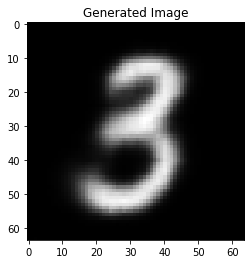

Epoch 305/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.38it/s]

Epoch [305/500], Loss: 65078.0078 (total loss), 61972.8906 (bce), 3105.1172 (kld)
Mu range: -2.1956722736358643 ~ 2.5917413234710693, Logvar range: -5.389322280883789 ~ -0.015783876180648804
tensor(8)


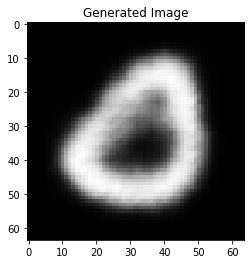

Epoch 306/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.37it/s]


Epoch [306/500], Loss: 63621.1523 (total loss), 60490.8984 (bce), 3130.2529 (kld)
Mu range: -1.6644972562789917 ~ 3.551602363586426, Logvar range: -7.557941436767578 ~ 0.10083743929862976
tensor(2)


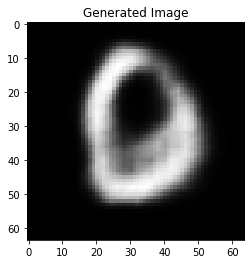

Epoch 307/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]

Epoch [307/500], Loss: 65718.7812 (total loss), 62704.5703 (bce), 3014.2122 (kld)
Mu range: -2.7724087238311768 ~ 3.868065595626831, Logvar range: -5.705334186553955 ~ -0.014083150774240494
tensor(0)


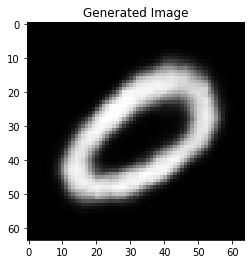

Epoch 308/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.16it/s]

Epoch [308/500], Loss: 66001.2188 (total loss), 62916.0742 (bce), 3085.1406 (kld)
Mu range: -1.3874973058700562 ~ 0.9540141820907593, Logvar range: -5.823955535888672 ~ -0.007109168916940689
tensor(4)


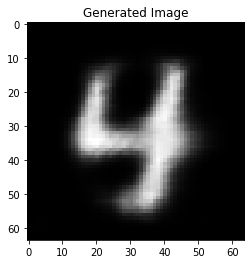

Epoch 309/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.06it/s]


Epoch [309/500], Loss: 65274.0859 (total loss), 62142.8750 (bce), 3131.2119 (kld)
Mu range: -0.9568653702735901 ~ 1.4786196947097778, Logvar range: -6.392398357391357 ~ 0.008595839142799377
tensor(4)


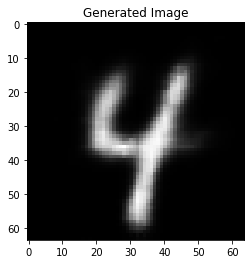

Epoch 310/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]

Epoch [310/500], Loss: 64791.2969 (total loss), 61539.0781 (bce), 3252.2178 (kld)
Mu range: -1.942388653755188 ~ 0.07753142714500427, Logvar range: -7.308492183685303 ~ 0.02239537239074707
tensor(2)


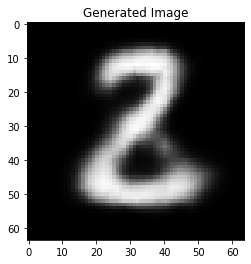

Epoch 311/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.52it/s]


Epoch [311/500], Loss: 66526.8984 (total loss), 63373.8047 (bce), 3153.0911 (kld)
Mu range: -1.6757768392562866 ~ 3.4055581092834473, Logvar range: -7.115942478179932 ~ -0.013658365234732628
tensor(4)


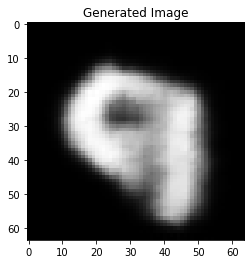

Epoch 312/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.43it/s]

Epoch [312/500], Loss: 67732.4453 (total loss), 64548.8086 (bce), 3183.6370 (kld)
Mu range: -2.3536770343780518 ~ 1.8791625499725342, Logvar range: -6.310651779174805 ~ -0.004501565359532833
tensor(4)


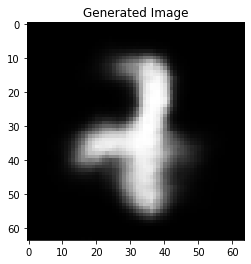

Epoch 313/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.31it/s]


Epoch [313/500], Loss: 66766.8672 (total loss), 63568.5938 (bce), 3198.2705 (kld)
Mu range: -1.5556424856185913 ~ 1.1030389070510864, Logvar range: -6.349824905395508 ~ -0.03700679540634155
tensor(1)


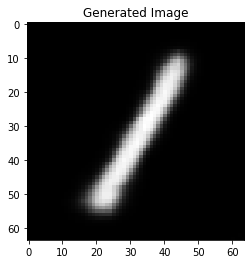

Epoch 314/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.16it/s]


Epoch [314/500], Loss: 67600.5938 (total loss), 64421.8359 (bce), 3178.7554 (kld)
Mu range: -1.0632730722427368 ~ 2.02315616607666, Logvar range: -5.865685939788818 ~ 0.026424845680594444
tensor(0)


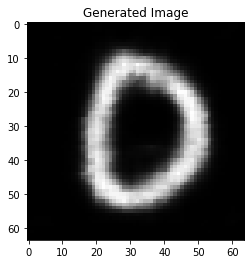

Epoch 315/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.20it/s]

Epoch [315/500], Loss: 63795.9453 (total loss), 60710.7148 (bce), 3085.2314 (kld)
Mu range: -1.8269264698028564 ~ 0.8567567467689514, Logvar range: -6.56556510925293 ~ 0.008149061352014542
tensor(8)


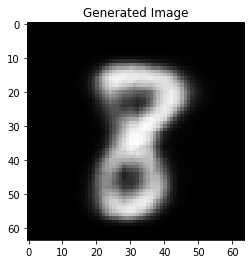

Epoch 316/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.22it/s]

Epoch [316/500], Loss: 62716.4648 (total loss), 59572.9883 (bce), 3143.4763 (kld)
Mu range: -3.173604965209961 ~ 1.944931149482727, Logvar range: -6.626735687255859 ~ 0.0441305935382843
tensor(3)


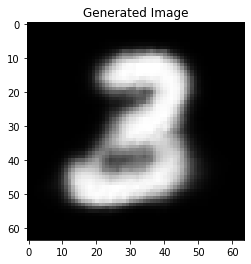

Epoch 317/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.36it/s]

Epoch [317/500], Loss: 63730.7891 (total loss), 60450.2969 (bce), 3280.4941 (kld)
Mu range: -2.1424338817596436 ~ 2.831103801727295, Logvar range: -7.3909454345703125 ~ -0.006100943312048912
tensor(3)


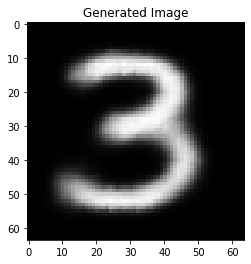

Epoch 318/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.22it/s]


Epoch [318/500], Loss: 63749.1445 (total loss), 60656.6562 (bce), 3092.4873 (kld)
Mu range: -1.9790602922439575 ~ 1.642163872718811, Logvar range: -5.869065284729004 ~ 0.007749328389763832
tensor(0)


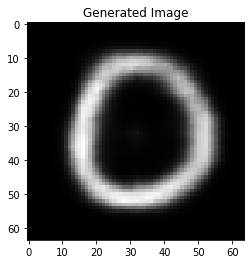

Epoch 319/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.53it/s]


Epoch [319/500], Loss: 65618.6875 (total loss), 62490.7734 (bce), 3127.9114 (kld)
Mu range: -0.9172039031982422 ~ 2.034839391708374, Logvar range: -6.542283058166504 ~ -0.01189088448882103
tensor(4)


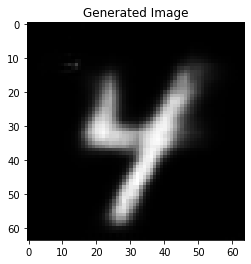

Epoch 320/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.47it/s]


Epoch [320/500], Loss: 62768.6289 (total loss), 59489.2109 (bce), 3279.4194 (kld)
Mu range: -2.018890619277954 ~ 1.6291556358337402, Logvar range: -6.932524681091309 ~ -0.004024578258395195
tensor(3)


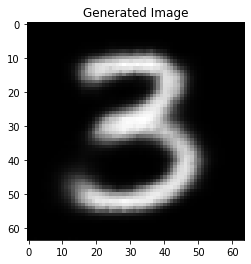

Epoch 321/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.37it/s]

Epoch [321/500], Loss: 63661.0703 (total loss), 60549.7266 (bce), 3111.3423 (kld)
Mu range: -1.386544108390808 ~ 1.4562838077545166, Logvar range: -6.383632659912109 ~ 0.01584039442241192
tensor(2)


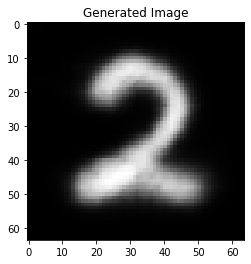

Epoch 322/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.54it/s]


Epoch [322/500], Loss: 62540.4531 (total loss), 59393.3672 (bce), 3147.0869 (kld)
Mu range: -3.2235007286071777 ~ 1.8768411874771118, Logvar range: -8.08265495300293 ~ 0.05559465289115906
tensor(6)


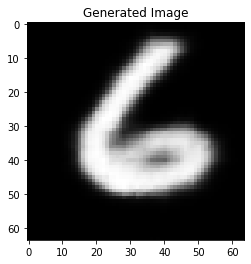

Epoch 323/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.30it/s]


Epoch [323/500], Loss: 69102.6172 (total loss), 65805.1953 (bce), 3297.4253 (kld)
Mu range: -1.933210015296936 ~ 2.2833492755889893, Logvar range: -5.885868072509766 ~ -0.015030796639621258
tensor(3)


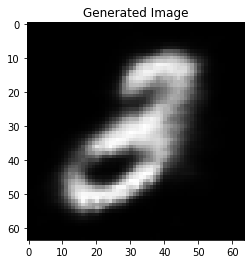

Epoch 324/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.13it/s]

Epoch [324/500], Loss: 66030.3125 (total loss), 62858.4062 (bce), 3171.9036 (kld)
Mu range: -1.2698441743850708 ~ 0.767579972743988, Logvar range: -5.623183250427246 ~ 0.0013503879308700562
tensor(8)


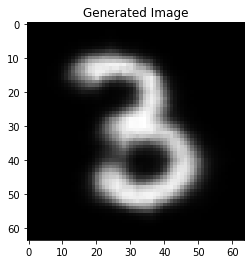

Epoch 325/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.27it/s]

Epoch [325/500], Loss: 68306.3125 (total loss), 65078.4180 (bce), 3227.8960 (kld)
Mu range: -0.7492949366569519 ~ 0.6384011507034302, Logvar range: -5.259310722351074 ~ -0.004646729677915573
tensor(6)


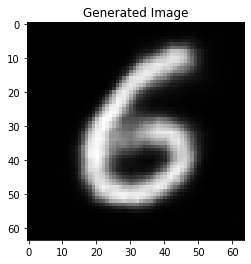

Epoch 326/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.40it/s]

Epoch [326/500], Loss: 68842.1406 (total loss), 65753.6875 (bce), 3088.4561 (kld)
Mu range: -1.1829004287719727 ~ 2.409693717956543, Logvar range: -6.172417640686035 ~ -0.018700823187828064
tensor(4)


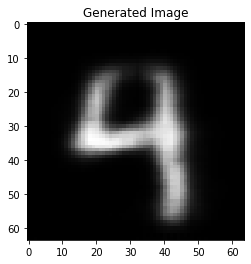

Epoch 327/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.33it/s]

Epoch [327/500], Loss: 64972.3203 (total loss), 61818.0703 (bce), 3154.2498 (kld)
Mu range: -2.420865535736084 ~ 1.076515793800354, Logvar range: -7.172595977783203 ~ 0.0008526891469955444
tensor(6)


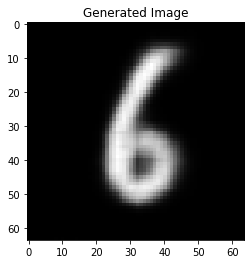

Epoch 328/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.31it/s]


Epoch [328/500], Loss: 65884.0078 (total loss), 62756.3789 (bce), 3127.6313 (kld)
Mu range: -3.3874781131744385 ~ 2.228691339492798, Logvar range: -6.99323844909668 ~ 0.026662128046154976
tensor(5)


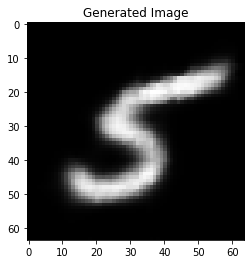

Epoch 329/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.43it/s]


Epoch [329/500], Loss: 64676.3086 (total loss), 61516.4688 (bce), 3159.8406 (kld)
Mu range: -1.0356502532958984 ~ 2.0870063304901123, Logvar range: -6.523284912109375 ~ -0.02552807331085205
tensor(7)


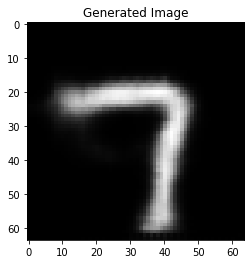

Epoch 330/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.16it/s]

Epoch [330/500], Loss: 66897.5469 (total loss), 63795.6445 (bce), 3101.9028 (kld)
Mu range: -1.1840449571609497 ~ 1.0779207944869995, Logvar range: -5.868705749511719 ~ -0.0007959399372339249
tensor(8)


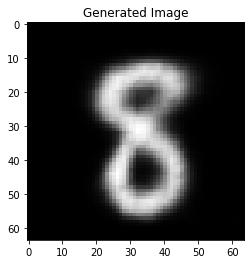

Epoch 331/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]


Epoch [331/500], Loss: 67183.8047 (total loss), 64113.1016 (bce), 3070.6997 (kld)
Mu range: -2.3589930534362793 ~ 1.373285174369812, Logvar range: -5.537474155426025 ~ -0.006019418127834797
tensor(9)


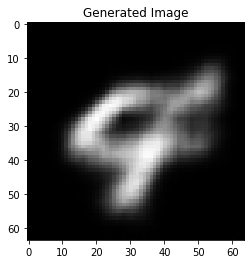

Epoch 332/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.26it/s]


Epoch [332/500], Loss: 63918.5703 (total loss), 60666.1172 (bce), 3252.4529 (kld)
Mu range: -1.910194993019104 ~ 1.6614981889724731, Logvar range: -6.882414817810059 ~ 0.008143899962306023
tensor(7)


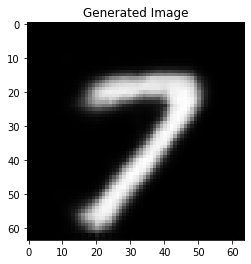

Epoch 333/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.67it/s]

Epoch [333/500], Loss: 65855.2969 (total loss), 62683.8086 (bce), 3171.4897 (kld)
Mu range: -1.1705098152160645 ~ 1.1910946369171143, Logvar range: -6.5800700187683105 ~ 0.0014111064374446869
tensor(7)


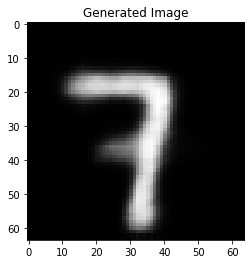

Epoch 334/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.18it/s]


Epoch [334/500], Loss: 64438.1641 (total loss), 61307.5117 (bce), 3130.6519 (kld)
Mu range: -1.049462914466858 ~ 1.8936744928359985, Logvar range: -6.0504350662231445 ~ -0.011720791459083557
tensor(4)


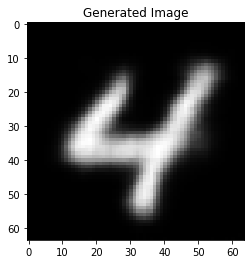

Epoch 335/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.30it/s]


Epoch [335/500], Loss: 63855.6055 (total loss), 60661.4023 (bce), 3194.2031 (kld)
Mu range: -1.0057231187820435 ~ 1.6552001237869263, Logvar range: -5.625049591064453 ~ 0.005051886662840843
tensor(0)


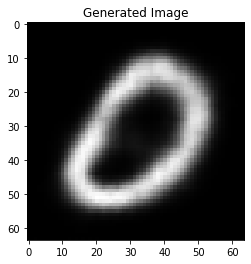

Epoch 336/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.19it/s]


Epoch [336/500], Loss: 65314.5820 (total loss), 62155.6406 (bce), 3158.9429 (kld)
Mu range: -3.783142328262329 ~ 1.070812463760376, Logvar range: -7.991829872131348 ~ 0.02269279956817627
tensor(6)


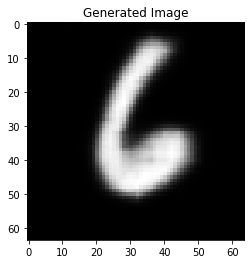

Epoch 337/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]

Epoch [337/500], Loss: 66751.5312 (total loss), 63587.2188 (bce), 3164.3120 (kld)
Mu range: -2.7492618560791016 ~ 1.4143340587615967, Logvar range: -7.7669267654418945 ~ 0.017147749662399292
tensor(6)


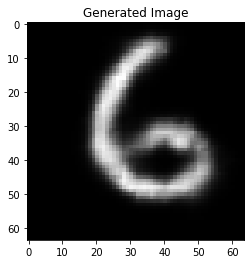

Epoch 338/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.37it/s]


Epoch [338/500], Loss: 68059.6484 (total loss), 64970.9453 (bce), 3088.7019 (kld)
Mu range: -1.444814682006836 ~ 3.0616328716278076, Logvar range: -6.232353687286377 ~ -0.01446723286062479
tensor(0)


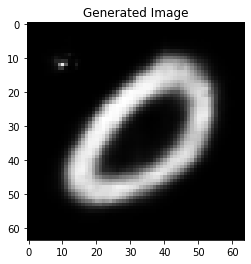

Epoch 339/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.93it/s]

Epoch [339/500], Loss: 62925.7539 (total loss), 59693.8516 (bce), 3231.9023 (kld)
Mu range: -1.0558432340621948 ~ 2.215034246444702, Logvar range: -6.726003646850586 ~ 0.0109340138733387
tensor(9)


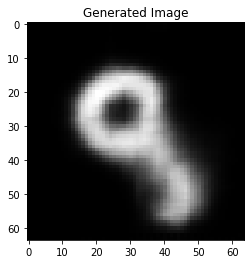

Epoch 340/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.11it/s]


Epoch [340/500], Loss: 63425.4609 (total loss), 60322.2578 (bce), 3103.2046 (kld)
Mu range: -2.043153762817383 ~ 2.085296154022217, Logvar range: -6.271521091461182 ~ 0.013061659410595894
tensor(1)


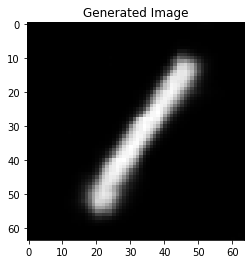

Epoch 341/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.05it/s]

Epoch [341/500], Loss: 63625.3047 (total loss), 60515.7305 (bce), 3109.5752 (kld)
Mu range: -3.443821668624878 ~ 2.4966700077056885, Logvar range: -7.316082954406738 ~ -0.028281474485993385
tensor(7)


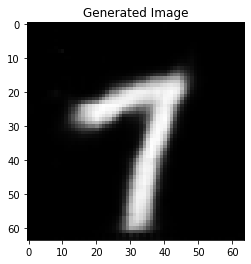

Epoch 342/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.34it/s]

Epoch [342/500], Loss: 64353.2344 (total loss), 61248.5508 (bce), 3104.6846 (kld)
Mu range: -1.71834397315979 ~ 2.2159533500671387, Logvar range: -6.75754976272583 ~ -0.01735779270529747
tensor(9)


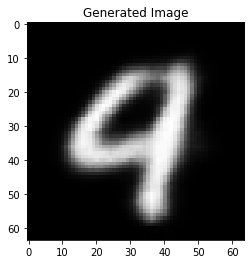

Epoch 343/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]

Epoch [343/500], Loss: 64889.3242 (total loss), 61763.4336 (bce), 3125.8889 (kld)
Mu range: -3.1176493167877197 ~ 1.7372710704803467, Logvar range: -6.222597122192383 ~ -0.014146153815090656
tensor(1)


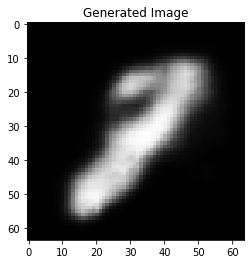

Epoch 344/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.35it/s]

Epoch [344/500], Loss: 66576.6562 (total loss), 63286.7188 (bce), 3289.9404 (kld)
Mu range: -1.6917883157730103 ~ 1.9216200113296509, Logvar range: -7.207239627838135 ~ -0.0060188258066773415
tensor(2)


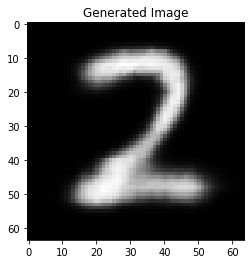

Epoch 345/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.19it/s]

Epoch [345/500], Loss: 65927.8828 (total loss), 62828.1172 (bce), 3099.7673 (kld)
Mu range: -1.5090235471725464 ~ 2.1984500885009766, Logvar range: -6.742951393127441 ~ -0.03129486367106438
tensor(4)


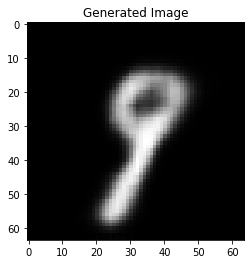

Epoch 346/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]


Epoch [346/500], Loss: 64366.7695 (total loss), 61240.7695 (bce), 3126.0005 (kld)
Mu range: -1.7709568738937378 ~ 1.7518377304077148, Logvar range: -7.704133987426758 ~ -0.0020787175744771957
tensor(4)


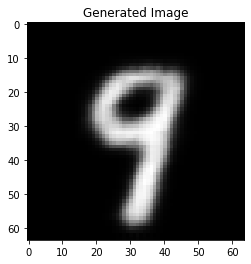

Epoch 347/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.97it/s]

Epoch [347/500], Loss: 65898.4766 (total loss), 62704.4688 (bce), 3194.0115 (kld)
Mu range: -2.4737465381622314 ~ 1.2328559160232544, Logvar range: -6.386580467224121 ~ 0.003364921547472477
tensor(3)


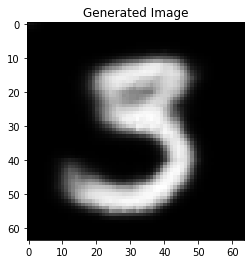

Epoch 348/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.24it/s]


Epoch [348/500], Loss: 66305.4219 (total loss), 63089.5703 (bce), 3215.8491 (kld)
Mu range: -1.1911406517028809 ~ 1.0848784446716309, Logvar range: -6.828518867492676 ~ 0.01092197373509407
tensor(1)


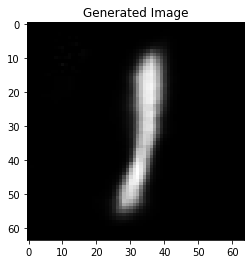

Epoch 349/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.32it/s]

Epoch [349/500], Loss: 66255.5078 (total loss), 63092.1250 (bce), 3163.3821 (kld)
Mu range: -2.2264556884765625 ~ 0.18848079442977905, Logvar range: -7.146140098571777 ~ -0.013370213098824024
tensor(5)


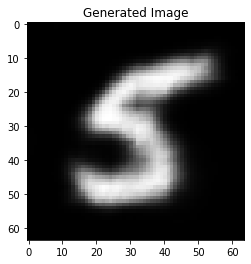

Epoch 350/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.35it/s]

Epoch [350/500], Loss: 65005.1797 (total loss), 61916.3242 (bce), 3088.8535 (kld)
Mu range: -1.4120177030563354 ~ 1.1830044984817505, Logvar range: -5.962648391723633 ~ 0.005924951285123825
tensor(6)


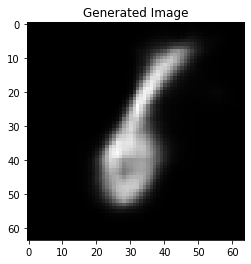

Epoch 351/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.33it/s]


Epoch [351/500], Loss: 66780.1172 (total loss), 63674.2383 (bce), 3105.8779 (kld)
Mu range: -0.9558061957359314 ~ 3.4213621616363525, Logvar range: -6.301723957061768 ~ 0.01599128544330597
tensor(4)


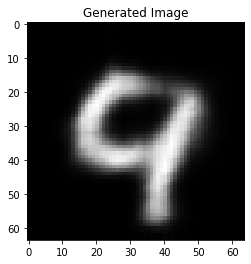

Epoch 352/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.86it/s]


Epoch [352/500], Loss: 64815.1406 (total loss), 61526.8711 (bce), 3288.2715 (kld)
Mu range: -2.540844678878784 ~ 3.1861817836761475, Logvar range: -5.683565616607666 ~ -0.006218185648322105
tensor(3)


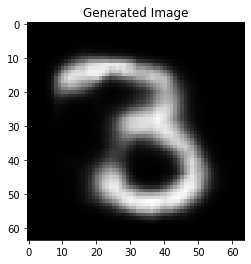

Epoch 353/500: 100%|██████████████████████████| 118/118 [00:13<00:00,  8.90it/s]


Epoch [353/500], Loss: 64882.4102 (total loss), 61813.8047 (bce), 3068.6050 (kld)
Mu range: -2.366278886795044 ~ 2.528179407119751, Logvar range: -6.5663557052612305 ~ 0.016876980662345886
tensor(7)


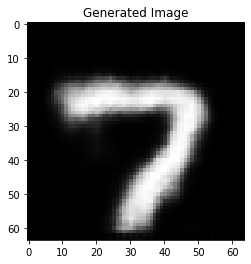

Epoch 354/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.64it/s]


Epoch [354/500], Loss: 68454.0938 (total loss), 65371.2070 (bce), 3082.8870 (kld)
Mu range: -1.5010164976119995 ~ 1.1239604949951172, Logvar range: -6.658339977264404 ~ -0.00188406091183424
tensor(1)


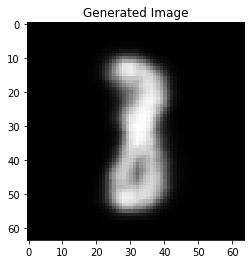

Epoch 355/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.36it/s]


Epoch [355/500], Loss: 66111.6094 (total loss), 62948.9805 (bce), 3162.6262 (kld)
Mu range: -1.8251783847808838 ~ 2.268961191177368, Logvar range: -6.778310775756836 ~ -0.00025798194110393524
tensor(7)


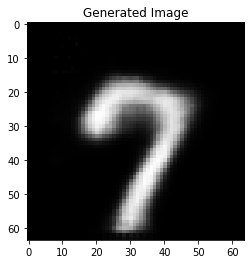

Epoch 356/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.58it/s]


Epoch [356/500], Loss: 66673.3125 (total loss), 63490.1953 (bce), 3183.1208 (kld)
Mu range: -2.058492660522461 ~ 2.136373281478882, Logvar range: -6.624478340148926 ~ 0.005479589104652405
tensor(6)


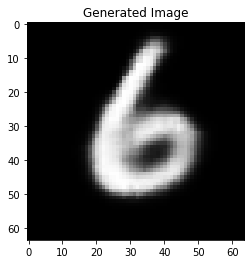

Epoch 357/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.19it/s]


Epoch [357/500], Loss: 62867.9414 (total loss), 59731.8828 (bce), 3136.0601 (kld)
Mu range: -1.695544958114624 ~ 2.6993038654327393, Logvar range: -6.181277751922607 ~ 0.006551861763000488
tensor(7)


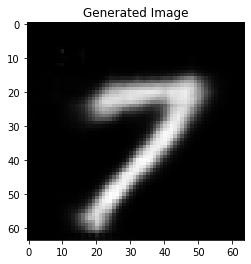

Epoch 358/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.40it/s]


Epoch [358/500], Loss: 66508.6641 (total loss), 63349.9062 (bce), 3158.7598 (kld)
Mu range: -0.9932588338851929 ~ 1.15553617477417, Logvar range: -6.474642276763916 ~ -0.010464103892445564
tensor(8)


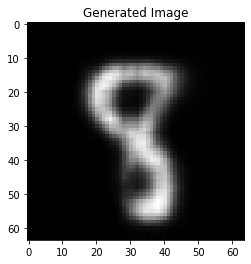

Epoch 359/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.38it/s]


Epoch [359/500], Loss: 63963.1094 (total loss), 60715.6602 (bce), 3247.4492 (kld)
Mu range: -1.515650749206543 ~ 1.4042072296142578, Logvar range: -5.947550296783447 ~ -0.016709808260202408
tensor(6)


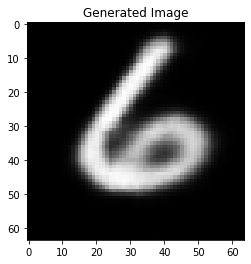

Epoch 360/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.59it/s]


Epoch [360/500], Loss: 61615.5039 (total loss), 58475.8086 (bce), 3139.6941 (kld)
Mu range: -2.544954299926758 ~ 3.124523639678955, Logvar range: -6.032968044281006 ~ -0.03046819567680359
tensor(0)


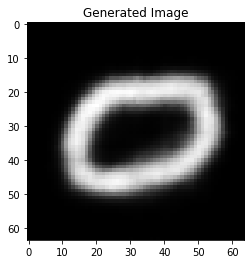

Epoch 361/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.94it/s]


Epoch [361/500], Loss: 63596.7031 (total loss), 60511.1914 (bce), 3085.5122 (kld)
Mu range: -2.257936716079712 ~ 2.0405068397521973, Logvar range: -6.162171840667725 ~ 0.060916975140571594
tensor(6)


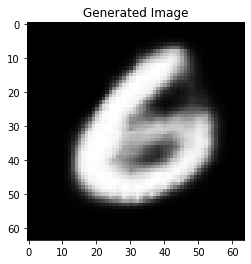

Epoch 362/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.43it/s]


Epoch [362/500], Loss: 71459.7266 (total loss), 68305.9688 (bce), 3153.7559 (kld)
Mu range: -1.5124526023864746 ~ 0.3703264892101288, Logvar range: -6.008789539337158 ~ -0.006357324309647083
tensor(6)


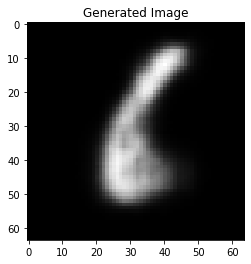

Epoch 363/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.21it/s]


Epoch [363/500], Loss: 62808.9375 (total loss), 59639.0234 (bce), 3169.9133 (kld)
Mu range: -1.6186741590499878 ~ 1.500114917755127, Logvar range: -7.29097843170166 ~ -0.004376605153083801
tensor(9)


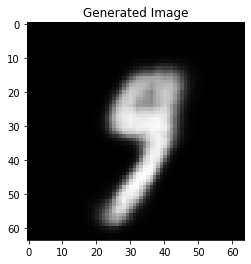

Epoch 364/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.96it/s]

Epoch [364/500], Loss: 66757.2656 (total loss), 63451.5859 (bce), 3305.6777 (kld)
Mu range: -4.682875633239746 ~ 1.4431865215301514, Logvar range: -6.7144694328308105 ~ 0.0600314736366272
tensor(6)


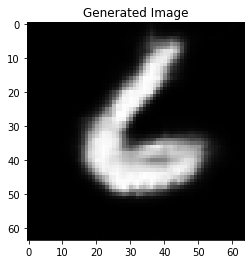

Epoch 365/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.91it/s]

Epoch [365/500], Loss: 68622.3047 (total loss), 65405.1758 (bce), 3217.1284 (kld)
Mu range: -1.2439894676208496 ~ 2.224330186843872, Logvar range: -6.6257195472717285 ~ 0.005426373332738876
tensor(9)


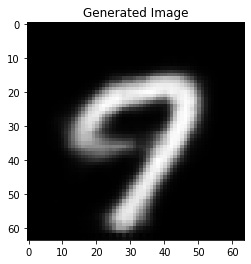

Epoch 366/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.40it/s]


Epoch [366/500], Loss: 66650.0391 (total loss), 63465.2812 (bce), 3184.7559 (kld)
Mu range: -2.774094581604004 ~ 2.0956740379333496, Logvar range: -7.024938583374023 ~ -0.01525811292231083
tensor(3)


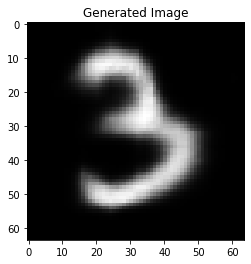

Epoch 367/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.24it/s]


Epoch [367/500], Loss: 62896.8242 (total loss), 59796.7656 (bce), 3100.0603 (kld)
Mu range: -1.9217114448547363 ~ 3.252264976501465, Logvar range: -6.357401371002197 ~ 0.01601117104291916
tensor(4)


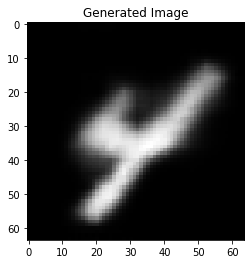

Epoch 368/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.08it/s]

Epoch [368/500], Loss: 65707.2500 (total loss), 62581.7773 (bce), 3125.4697 (kld)
Mu range: -0.9418935775756836 ~ 1.6669617891311646, Logvar range: -6.116597652435303 ~ -0.01526576466858387
tensor(7)


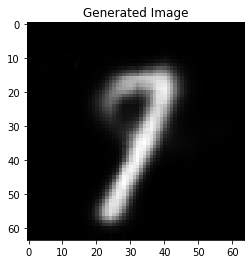

Epoch 369/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.31it/s]


Epoch [369/500], Loss: 63747.8359 (total loss), 60580.8828 (bce), 3166.9541 (kld)
Mu range: -1.6599204540252686 ~ 0.6388016939163208, Logvar range: -5.949910640716553 ~ -0.005694798193871975
tensor(6)


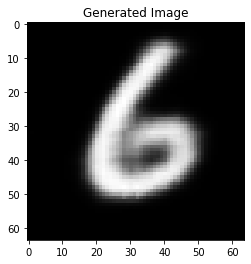

Epoch 370/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.44it/s]


Epoch [370/500], Loss: 63572.3984 (total loss), 60342.8828 (bce), 3229.5154 (kld)
Mu range: -1.7712754011154175 ~ 1.964412808418274, Logvar range: -6.81566047668457 ~ 0.03176112473011017
tensor(8)


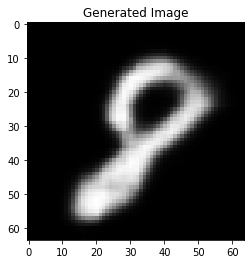

Epoch 371/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.04it/s]


Epoch [371/500], Loss: 63369.6953 (total loss), 60151.1445 (bce), 3218.5527 (kld)
Mu range: -2.780801773071289 ~ 1.5870068073272705, Logvar range: -7.142707824707031 ~ 0.0037280069664120674
tensor(6)


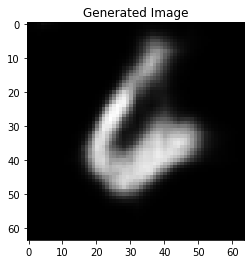

Epoch 372/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.37it/s]

Epoch [372/500], Loss: 66320.7109 (total loss), 62998.7109 (bce), 3321.9985 (kld)
Mu range: -1.7015067338943481 ~ 1.586629867553711, Logvar range: -6.071413516998291 ~ 0.014214843511581421
tensor(9)


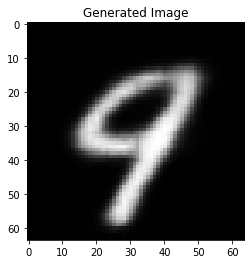

Epoch 373/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.41it/s]


Epoch [373/500], Loss: 66321.5938 (total loss), 63246.5273 (bce), 3075.0640 (kld)
Mu range: -1.6065866947174072 ~ 1.3743512630462646, Logvar range: -6.227334022521973 ~ 0.013871356844902039
tensor(1)


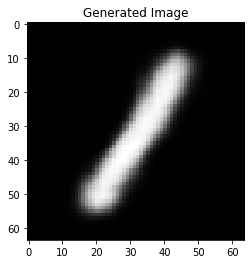

Epoch 374/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.14it/s]

Epoch [374/500], Loss: 63292.2031 (total loss), 60163.7109 (bce), 3128.4937 (kld)
Mu range: -1.5719563961029053 ~ 1.5751680135726929, Logvar range: -5.485580921173096 ~ -0.02787907049059868
tensor(4)


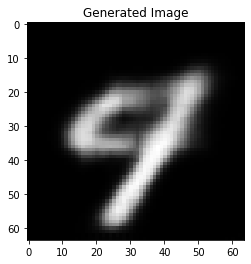

Epoch 375/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.38it/s]


Epoch [375/500], Loss: 66364.3906 (total loss), 63179.1875 (bce), 3185.2031 (kld)
Mu range: -1.7601351737976074 ~ 0.9759275913238525, Logvar range: -5.712827682495117 ~ -0.027881361544132233
tensor(6)


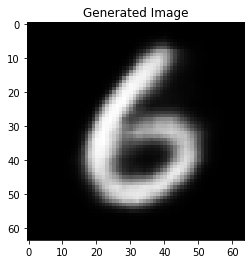

Epoch 376/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.99it/s]

Epoch [376/500], Loss: 67085.4766 (total loss), 64070.2969 (bce), 3015.1831 (kld)
Mu range: -0.8743185997009277 ~ 2.1097989082336426, Logvar range: -5.822551250457764 ~ -0.005400191992521286
tensor(2)


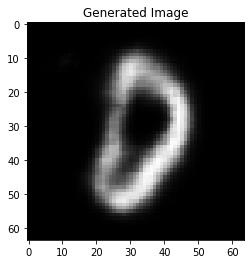

Epoch 377/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.97it/s]

Epoch [377/500], Loss: 66278.3516 (total loss), 63131.5586 (bce), 3146.7937 (kld)
Mu range: -2.855663537979126 ~ 4.474711894989014, Logvar range: -6.955782413482666 ~ -0.007547291461378336
tensor(8)


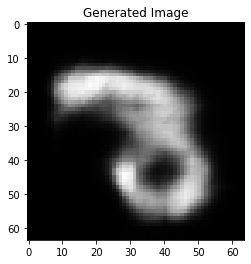

Epoch 378/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.22it/s]

Epoch [378/500], Loss: 66124.0234 (total loss), 62983.3984 (bce), 3140.6235 (kld)
Mu range: -2.7954792976379395 ~ 6.04619836807251, Logvar range: -6.805774688720703 ~ 0.16842710971832275
tensor(0)


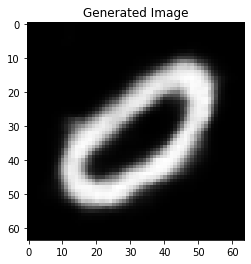

Epoch 379/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.35it/s]


Epoch [379/500], Loss: 66879.4922 (total loss), 63761.2422 (bce), 3118.2490 (kld)
Mu range: -1.312479019165039 ~ 0.8510086536407471, Logvar range: -5.9646782875061035 ~ -0.006344971247017384
tensor(1)


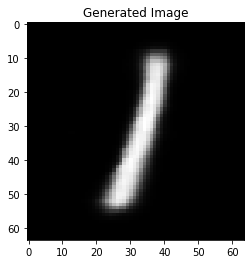

Epoch 380/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.36it/s]


Epoch [380/500], Loss: 64640.2070 (total loss), 61483.8438 (bce), 3156.3628 (kld)
Mu range: -0.93778395652771 ~ 1.5118221044540405, Logvar range: -6.2899580001831055 ~ -0.003777729347348213
tensor(8)


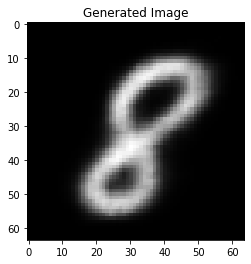

Epoch 381/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.34it/s]


Epoch [381/500], Loss: 64936.6289 (total loss), 61716.9258 (bce), 3219.7046 (kld)
Mu range: -1.4124974012374878 ~ 1.8265581130981445, Logvar range: -6.469369888305664 ~ 0.002700173296034336
tensor(4)


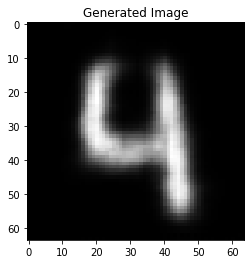

Epoch 382/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.63it/s]

Epoch [382/500], Loss: 68637.0703 (total loss), 65460.4922 (bce), 3176.5786 (kld)
Mu range: -1.8365442752838135 ~ 1.5805453062057495, Logvar range: -6.408987045288086 ~ -0.008594853803515434
tensor(3)


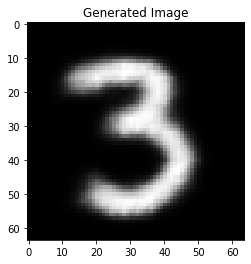

Epoch 383/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.10it/s]


Epoch [383/500], Loss: 63974.4727 (total loss), 60819.0352 (bce), 3155.4375 (kld)
Mu range: -1.3446781635284424 ~ 4.2114105224609375, Logvar range: -6.224505424499512 ~ 0.007670718245208263
tensor(4)


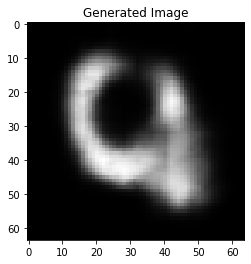

Epoch 384/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.49it/s]

Epoch [384/500], Loss: 66232.9766 (total loss), 63064.9102 (bce), 3168.0654 (kld)
Mu range: -1.1057531833648682 ~ 0.5162882804870605, Logvar range: -5.9978508949279785 ~ -0.0018890826031565666
tensor(1)


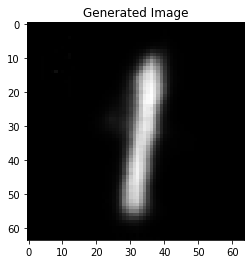

Epoch 385/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.26it/s]


Epoch [385/500], Loss: 65437.5703 (total loss), 62305.7148 (bce), 3131.8555 (kld)
Mu range: -1.5538315773010254 ~ 2.929131031036377, Logvar range: -7.729752063751221 ~ 0.026430854573845863
tensor(4)


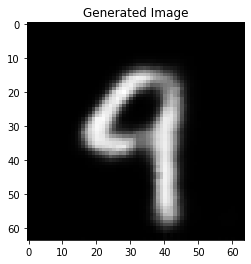

Epoch 386/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.15it/s]


Epoch [386/500], Loss: 68135.2266 (total loss), 65033.6055 (bce), 3101.6201 (kld)
Mu range: -1.7003414630889893 ~ 3.1364879608154297, Logvar range: -6.9069318771362305 ~ 0.004067521542310715
tensor(0)


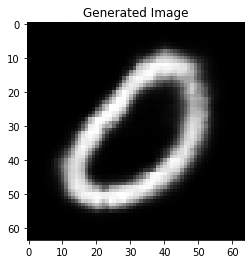

Epoch 387/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.31it/s]


Epoch [387/500], Loss: 66425.9688 (total loss), 63165.4219 (bce), 3260.5469 (kld)
Mu range: -0.9597965478897095 ~ 2.013248920440674, Logvar range: -6.116500377655029 ~ -0.01199768390506506
tensor(6)


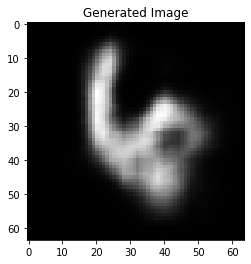

Epoch 388/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.60it/s]


Epoch [388/500], Loss: 68495.1016 (total loss), 65269.6484 (bce), 3225.4563 (kld)
Mu range: -3.7624404430389404 ~ 1.868051290512085, Logvar range: -7.064155578613281 ~ 0.13070301711559296
tensor(1)


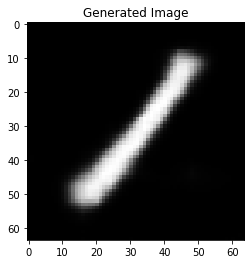

Epoch 389/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.41it/s]

Epoch [389/500], Loss: 64400.3047 (total loss), 61211.6211 (bce), 3188.6816 (kld)
Mu range: -2.206347703933716 ~ 2.4444127082824707, Logvar range: -7.361478805541992 ~ -0.01129169762134552
tensor(4)


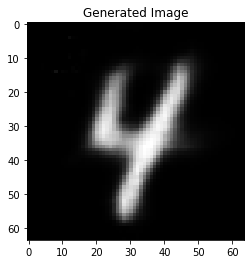

Epoch 390/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.33it/s]

Epoch [390/500], Loss: 66559.4141 (total loss), 63454.8555 (bce), 3104.5601 (kld)
Mu range: -3.814309597015381 ~ 2.1206676959991455, Logvar range: -6.952946662902832 ~ 0.017147719860076904
tensor(6)


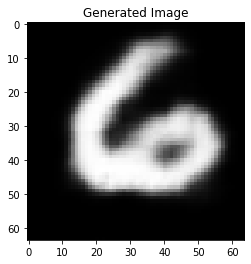

Epoch 391/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.71it/s]


Epoch [391/500], Loss: 65020.2422 (total loss), 61863.0117 (bce), 3157.2305 (kld)
Mu range: -2.177643299102783 ~ 4.187867641448975, Logvar range: -8.020121574401855 ~ 0.015700893476605415
tensor(7)


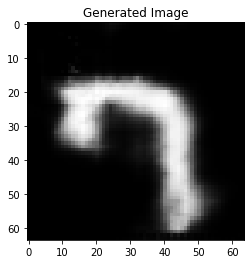

Epoch 392/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.82it/s]


Epoch [392/500], Loss: 64652.8945 (total loss), 61574.2266 (bce), 3078.6687 (kld)
Mu range: -1.7402533292770386 ~ 1.6952651739120483, Logvar range: -5.872736930847168 ~ -0.0073561398312449455
tensor(2)


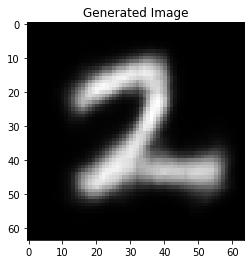

Epoch 393/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.34it/s]


Epoch [393/500], Loss: 63649.5859 (total loss), 60429.7266 (bce), 3219.8574 (kld)
Mu range: -1.7606521844863892 ~ 0.8222935199737549, Logvar range: -6.787521839141846 ~ -0.003407874144613743
tensor(1)


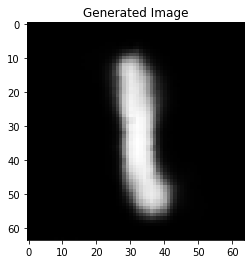

Epoch 394/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]


Epoch [394/500], Loss: 64327.0898 (total loss), 61224.0898 (bce), 3103.0012 (kld)
Mu range: -2.393537998199463 ~ 3.887247085571289, Logvar range: -8.350921630859375 ~ 0.062457963824272156
tensor(7)


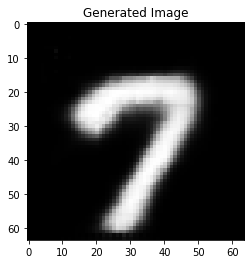

Epoch 395/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.46it/s]


Epoch [395/500], Loss: 66912.5000 (total loss), 63770.4336 (bce), 3142.0647 (kld)
Mu range: -1.4751288890838623 ~ 0.9828460812568665, Logvar range: -6.374145984649658 ~ -0.002654528245329857
tensor(1)


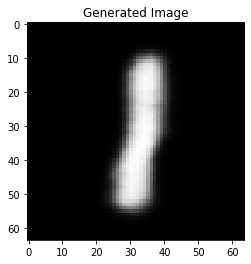

Epoch 396/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]


Epoch [396/500], Loss: 65696.0781 (total loss), 62541.6875 (bce), 3154.3887 (kld)
Mu range: -1.7704896926879883 ~ 1.2223871946334839, Logvar range: -6.4680328369140625 ~ 0.013438180088996887
tensor(1)


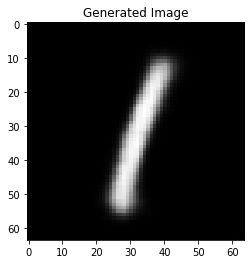

Epoch 397/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.32it/s]

Epoch [397/500], Loss: 65607.7500 (total loss), 62464.4453 (bce), 3143.3076 (kld)
Mu range: -0.5814739465713501 ~ 0.5207126140594482, Logvar range: -5.863893032073975 ~ -0.0060473158955574036
tensor(3)


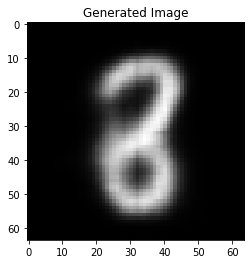

Epoch 398/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.24it/s]


Epoch [398/500], Loss: 65343.9297 (total loss), 62081.4258 (bce), 3262.5032 (kld)
Mu range: -1.2769811153411865 ~ 2.1074352264404297, Logvar range: -6.23831844329834 ~ -0.001949450932443142
tensor(9)


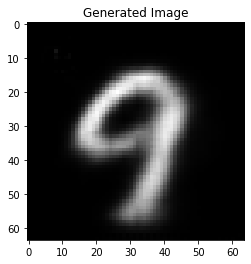

Epoch 399/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.12it/s]


Epoch [399/500], Loss: 64694.0742 (total loss), 61523.5195 (bce), 3170.5530 (kld)
Mu range: -4.234517574310303 ~ 3.0496325492858887, Logvar range: -7.261146545410156 ~ 0.04534024000167847
tensor(5)


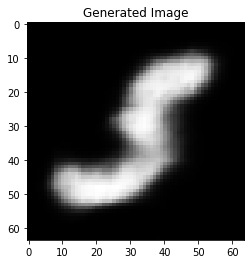

Epoch 400/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.66it/s]

Epoch [400/500], Loss: 66212.1094 (total loss), 63011.1953 (bce), 3200.9109 (kld)
Mu range: -2.4827091693878174 ~ 2.792742967605591, Logvar range: -6.169114589691162 ~ 0.02612951397895813
tensor(4)


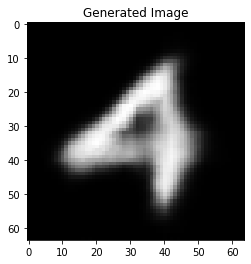

Epoch 401/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.68it/s]


Epoch [401/500], Loss: 62968.0703 (total loss), 59680.1914 (bce), 3287.8779 (kld)
Mu range: -2.49139142036438 ~ 1.3833873271942139, Logvar range: -6.441636085510254 ~ -0.007980403490364552
tensor(3)


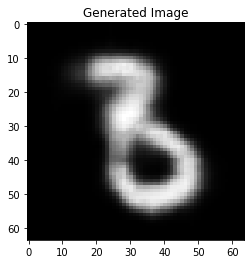

Epoch 402/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.31it/s]

Epoch [402/500], Loss: 60210.5742 (total loss), 57093.2266 (bce), 3117.3474 (kld)
Mu range: -1.5872530937194824 ~ 0.6265739798545837, Logvar range: -5.81140661239624 ~ -0.011566136963665485
tensor(2)


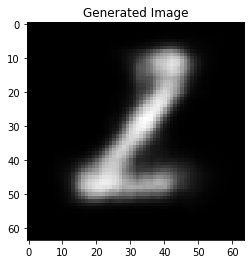

Epoch 403/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.49it/s]

Epoch [403/500], Loss: 65719.3984 (total loss), 62551.8906 (bce), 3167.5049 (kld)
Mu range: -2.451988935470581 ~ 2.563098430633545, Logvar range: -7.0603108406066895 ~ -0.01483309268951416
tensor(4)


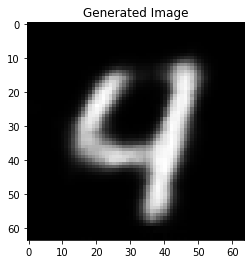

Epoch 404/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.59it/s]


Epoch [404/500], Loss: 64472.1406 (total loss), 61349.7812 (bce), 3122.3608 (kld)
Mu range: -2.1470260620117188 ~ 1.0575639009475708, Logvar range: -6.019669532775879 ~ -0.009328472428023815
tensor(6)


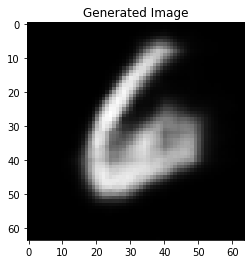

Epoch 405/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.77it/s]


Epoch [405/500], Loss: 69318.7109 (total loss), 66188.5078 (bce), 3130.2046 (kld)
Mu range: -2.042836904525757 ~ 2.6812100410461426, Logvar range: -6.639680862426758 ~ -0.004816877190023661
tensor(0)


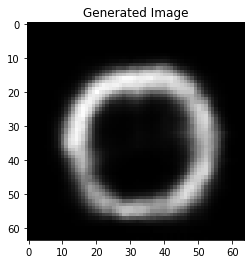

Epoch 406/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.93it/s]

Epoch [406/500], Loss: 64943.3242 (total loss), 61718.8125 (bce), 3224.5110 (kld)
Mu range: -0.6770673394203186 ~ 0.8296065330505371, Logvar range: -6.007101535797119 ~ -0.00887675117701292
tensor(7)


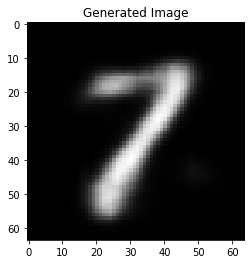

Epoch 407/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.41it/s]


Epoch [407/500], Loss: 65468.5703 (total loss), 62160.4766 (bce), 3308.0923 (kld)
Mu range: -2.3903751373291016 ~ 2.422584056854248, Logvar range: -7.905977725982666 ~ 0.13409462571144104
tensor(1)


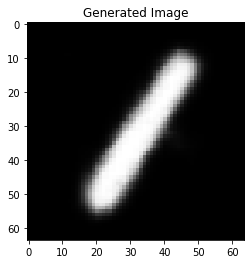

Epoch 408/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.24it/s]

Epoch [408/500], Loss: 63449.8477 (total loss), 60322.4961 (bce), 3127.3506 (kld)
Mu range: -0.9951356649398804 ~ 1.0644018650054932, Logvar range: -6.125102519989014 ~ 0.004710467532277107
tensor(8)


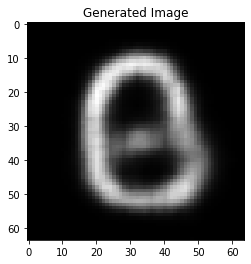

Epoch 409/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.34it/s]


Epoch [409/500], Loss: 67246.5625 (total loss), 64057.2578 (bce), 3189.3086 (kld)
Mu range: -1.245744228363037 ~ 1.634999394416809, Logvar range: -5.25501012802124 ~ 0.0050270333886146545
tensor(2)


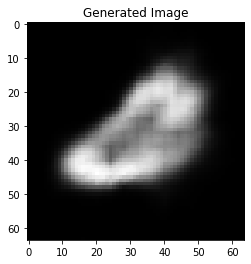

Epoch 410/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.60it/s]


Epoch [410/500], Loss: 66749.3828 (total loss), 63603.9766 (bce), 3145.4065 (kld)
Mu range: -0.9453246593475342 ~ 1.7314682006835938, Logvar range: -5.969666004180908 ~ -0.025712277740240097
tensor(4)


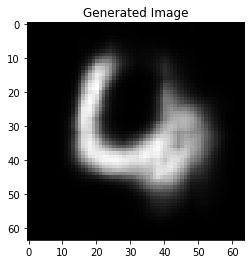

Epoch 411/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.62it/s]


Epoch [411/500], Loss: 68005.0625 (total loss), 64866.6719 (bce), 3138.3943 (kld)
Mu range: -1.1910759210586548 ~ 1.4468283653259277, Logvar range: -6.037778854370117 ~ -0.012976901605725288
tensor(7)


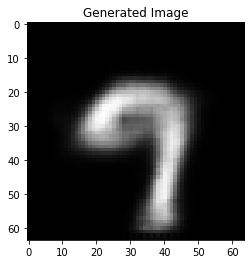

Epoch 412/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.48it/s]


Epoch [412/500], Loss: 65001.2500 (total loss), 61942.3711 (bce), 3058.8806 (kld)
Mu range: -1.3493129014968872 ~ 1.140514850616455, Logvar range: -5.70936393737793 ~ -0.02304403856396675
tensor(2)


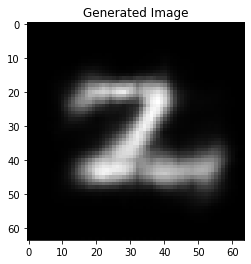

Epoch 413/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.41it/s]


Epoch [413/500], Loss: 70047.3516 (total loss), 66893.6719 (bce), 3153.6812 (kld)
Mu range: -1.1349108219146729 ~ 2.091508388519287, Logvar range: -5.914549827575684 ~ 0.014746516942977905
tensor(0)


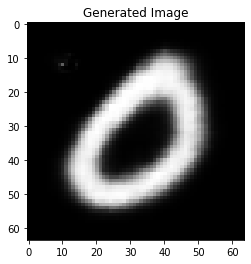

Epoch 414/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]


Epoch [414/500], Loss: 69013.2344 (total loss), 65713.2031 (bce), 3300.0337 (kld)
Mu range: -4.0132598876953125 ~ 2.6010801792144775, Logvar range: -6.297483444213867 ~ -0.008283091709017754
tensor(7)


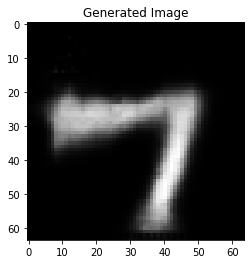

Epoch 415/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.41it/s]


Epoch [415/500], Loss: 65556.1172 (total loss), 62429.5312 (bce), 3126.5825 (kld)
Mu range: -1.4832944869995117 ~ 0.6571639776229858, Logvar range: -5.960702896118164 ~ -0.013115126639604568
tensor(1)


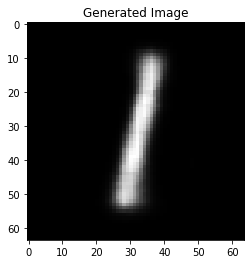

Epoch 416/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.12it/s]


Epoch [416/500], Loss: 66974.7344 (total loss), 63815.8281 (bce), 3158.9082 (kld)
Mu range: -2.391223430633545 ~ 2.7918386459350586, Logvar range: -6.170387268066406 ~ 0.010272443294525146
tensor(2)


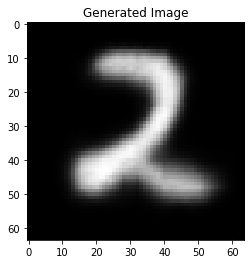

Epoch 417/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.56it/s]


Epoch [417/500], Loss: 63667.8594 (total loss), 60427.4453 (bce), 3240.4150 (kld)
Mu range: -0.6418079137802124 ~ 2.0751214027404785, Logvar range: -6.1234283447265625 ~ -0.0068267337046563625
tensor(4)


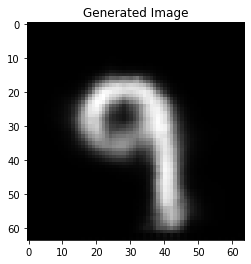

Epoch 418/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.43it/s]


Epoch [418/500], Loss: 67028.5859 (total loss), 63820.4297 (bce), 3208.1558 (kld)
Mu range: -0.9741405248641968 ~ 1.8782235383987427, Logvar range: -6.082149505615234 ~ -0.0098183024674654
tensor(7)


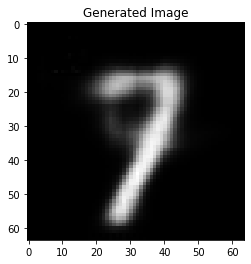

Epoch 419/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.33it/s]


Epoch [419/500], Loss: 63829.5938 (total loss), 60600.0391 (bce), 3229.5564 (kld)
Mu range: -1.6967743635177612 ~ 1.1232240200042725, Logvar range: -6.835134983062744 ~ 0.007440489716827869
tensor(3)


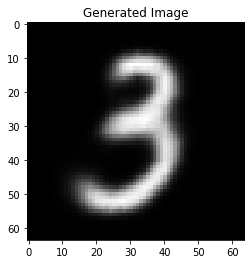

Epoch 420/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.21it/s]

Epoch [420/500], Loss: 64156.1797 (total loss), 60879.9883 (bce), 3276.1904 (kld)
Mu range: -1.1112688779830933 ~ 0.676405668258667, Logvar range: -5.873394012451172 ~ -0.0099404975771904
tensor(1)


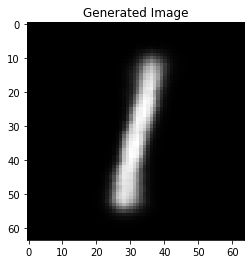

Epoch 421/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.59it/s]


Epoch [421/500], Loss: 62991.6602 (total loss), 59822.6641 (bce), 3168.9944 (kld)
Mu range: -1.9801256656646729 ~ 2.065670967102051, Logvar range: -6.763775825500488 ~ 0.003842470236122608
tensor(2)


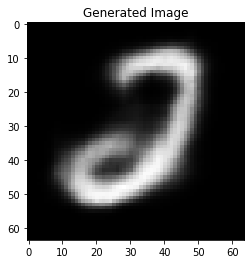

Epoch 422/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.04it/s]

Epoch [422/500], Loss: 66395.4453 (total loss), 63318.2148 (bce), 3077.2310 (kld)
Mu range: -1.254726767539978 ~ 1.5296883583068848, Logvar range: -6.441312789916992 ~ -0.023063819855451584
tensor(9)


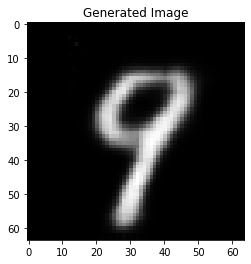

Epoch 423/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.26it/s]


Epoch [423/500], Loss: 63407.4297 (total loss), 60368.8945 (bce), 3038.5352 (kld)
Mu range: -3.4869260787963867 ~ 2.6680080890655518, Logvar range: -5.605985164642334 ~ 0.0031385142356157303
tensor(7)


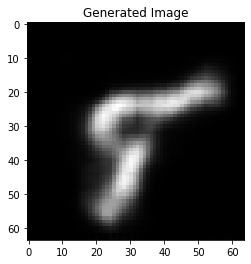

Epoch 424/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.38it/s]


Epoch [424/500], Loss: 67688.1641 (total loss), 64536.5977 (bce), 3151.5630 (kld)
Mu range: -2.677184820175171 ~ 1.8895621299743652, Logvar range: -7.312353134155273 ~ -0.0022701816633343697
tensor(3)


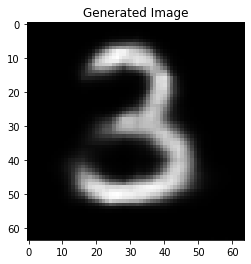

Epoch 425/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.13it/s]


Epoch [425/500], Loss: 65920.7109 (total loss), 62906.0273 (bce), 3014.6826 (kld)
Mu range: -2.9349007606506348 ~ 1.5804250240325928, Logvar range: -6.817231178283691 ~ 0.03421550989151001
tensor(1)


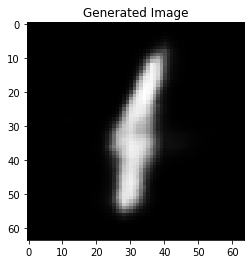

Epoch 426/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.21it/s]

Epoch [426/500], Loss: 61265.2656 (total loss), 58143.1641 (bce), 3122.1023 (kld)
Mu range: -3.576653003692627 ~ 1.2237803936004639, Logvar range: -7.333083629608154 ~ 0.06996913254261017
tensor(5)


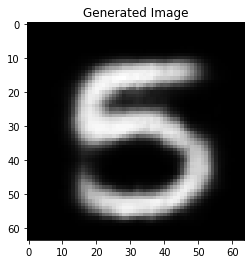

Epoch 427/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.30it/s]

Epoch [427/500], Loss: 64606.9219 (total loss), 61386.0547 (bce), 3220.8657 (kld)
Mu range: -2.032550573348999 ~ 2.3431644439697266, Logvar range: -7.459054946899414 ~ 0.008028457872569561
tensor(6)


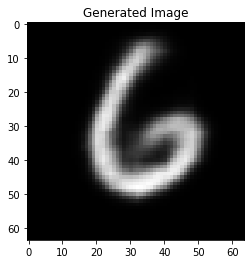

Epoch 428/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.16it/s]

Epoch [428/500], Loss: 61934.5859 (total loss), 58781.0977 (bce), 3153.4863 (kld)
Mu range: -2.240138053894043 ~ 1.9806089401245117, Logvar range: -6.999619483947754 ~ -0.01987738348543644
tensor(4)


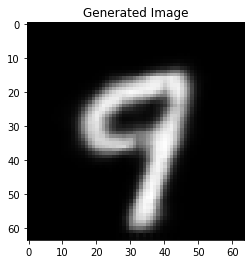

Epoch 429/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.61it/s]

Epoch [429/500], Loss: 64196.5508 (total loss), 60930.5234 (bce), 3266.0259 (kld)
Mu range: -1.208823561668396 ~ 2.0697882175445557, Logvar range: -5.78370475769043 ~ -0.00659557431936264
tensor(4)


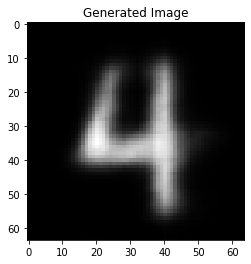

Epoch 430/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.24it/s]


Epoch [430/500], Loss: 66563.9453 (total loss), 63313.5781 (bce), 3250.3647 (kld)
Mu range: -2.34375 ~ 3.7719674110412598, Logvar range: -8.437352180480957 ~ 0.10409754514694214
tensor(8)


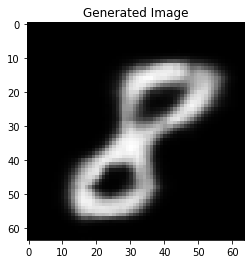

Epoch 431/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.40it/s]


Epoch [431/500], Loss: 66555.0469 (total loss), 63419.8320 (bce), 3135.2136 (kld)
Mu range: -2.0352325439453125 ~ 2.5015268325805664, Logvar range: -6.458436489105225 ~ 0.012184947729110718
tensor(0)


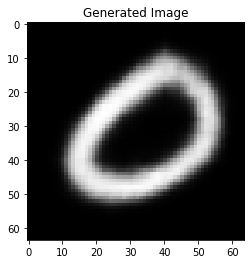

Epoch 432/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]

Epoch [432/500], Loss: 61743.9844 (total loss), 58480.3164 (bce), 3263.6670 (kld)
Mu range: -1.5645413398742676 ~ 0.30313193798065186, Logvar range: -6.152836799621582 ~ -0.007059554569423199
tensor(7)


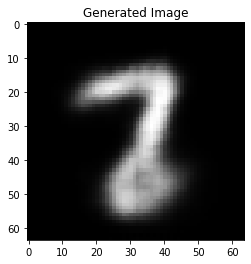

Epoch 433/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.14it/s]


Epoch [433/500], Loss: 67728.3594 (total loss), 64560.6250 (bce), 3167.7356 (kld)
Mu range: -2.3616867065429688 ~ 2.196617841720581, Logvar range: -7.293617248535156 ~ -0.01131833903491497
tensor(3)


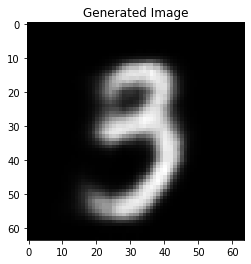

Epoch 434/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.22it/s]


Epoch [434/500], Loss: 66583.8516 (total loss), 63274.8711 (bce), 3308.9814 (kld)
Mu range: -0.9102190136909485 ~ 1.2202541828155518, Logvar range: -6.1789870262146 ~ -0.005233112722635269
tensor(3)


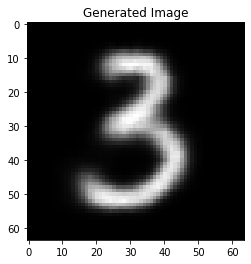

Epoch 435/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.90it/s]

Epoch [435/500], Loss: 67773.9688 (total loss), 64666.6406 (bce), 3107.3259 (kld)
Mu range: -2.2334532737731934 ~ 0.7350571155548096, Logvar range: -6.650274753570557 ~ -0.011620791628956795
tensor(5)


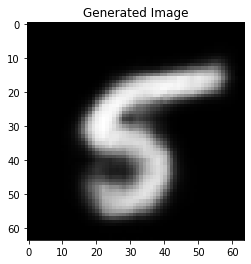

Epoch 436/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.99it/s]


Epoch [436/500], Loss: 65983.7500 (total loss), 62714.3438 (bce), 3269.4097 (kld)
Mu range: -1.368088722229004 ~ 2.9613473415374756, Logvar range: -6.512582778930664 ~ 0.007268153131008148
tensor(0)


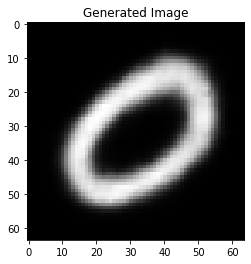

Epoch 437/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.06it/s]


Epoch [437/500], Loss: 67843.5000 (total loss), 64812.3281 (bce), 3031.1743 (kld)
Mu range: -1.0869919061660767 ~ 1.3402796983718872, Logvar range: -6.606673717498779 ~ -0.0023321695625782013
tensor(9)


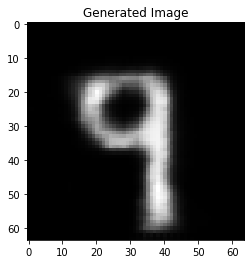

Epoch 438/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.43it/s]


Epoch [438/500], Loss: 64534.2891 (total loss), 61254.3047 (bce), 3279.9841 (kld)
Mu range: -1.6521302461624146 ~ 0.9417956471443176, Logvar range: -6.599684238433838 ~ 0.02337946742773056
tensor(1)


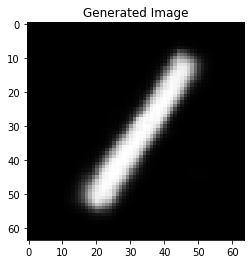

Epoch 439/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.85it/s]


Epoch [439/500], Loss: 64629.3438 (total loss), 61432.5664 (bce), 3196.7759 (kld)
Mu range: -2.054168939590454 ~ 2.3199007511138916, Logvar range: -7.228148460388184 ~ 0.004151105880737305
tensor(4)


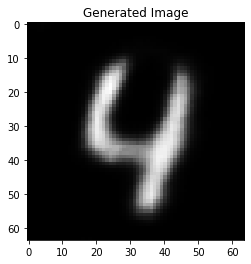

Epoch 440/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.78it/s]

Epoch [440/500], Loss: 63846.9336 (total loss), 60663.5352 (bce), 3183.3984 (kld)
Mu range: -1.7431706190109253 ~ 1.0968029499053955, Logvar range: -6.341883182525635 ~ -0.008788907900452614
tensor(4)


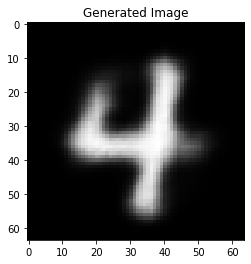

Epoch 441/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.89it/s]


Epoch [441/500], Loss: 64615.3516 (total loss), 61413.3672 (bce), 3201.9849 (kld)
Mu range: -2.756990432739258 ~ 3.4176039695739746, Logvar range: -7.610282897949219 ~ 0.04495374858379364
tensor(0)


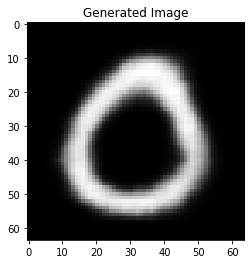

Epoch 442/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.78it/s]


Epoch [442/500], Loss: 66732.9531 (total loss), 63527.8164 (bce), 3205.1372 (kld)
Mu range: -0.9879779815673828 ~ 1.162323236465454, Logvar range: -5.286534786224365 ~ -0.012970179319381714
tensor(2)


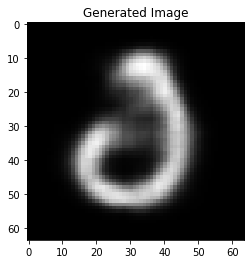

Epoch 443/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.56it/s]

Epoch [443/500], Loss: 66427.0859 (total loss), 63295.1250 (bce), 3131.9614 (kld)
Mu range: -1.4523824453353882 ~ 1.601999044418335, Logvar range: -6.934381484985352 ~ -0.013824127614498138
tensor(6)


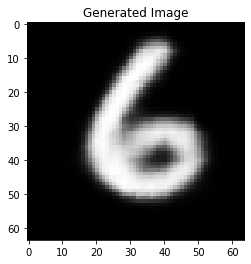

Epoch 444/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.13it/s]

Epoch [444/500], Loss: 67539.8672 (total loss), 64413.9180 (bce), 3125.9463 (kld)
Mu range: -1.9381661415100098 ~ 1.289878249168396, Logvar range: -6.154524803161621 ~ 0.009393595159053802
tensor(1)


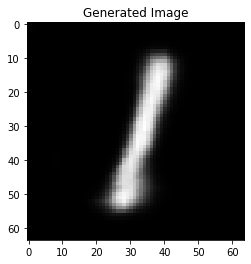

Epoch 445/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.62it/s]


Epoch [445/500], Loss: 61754.8672 (total loss), 58511.3984 (bce), 3243.4685 (kld)
Mu range: -4.141772270202637 ~ 3.7898306846618652, Logvar range: -6.691646575927734 ~ 0.03960113227367401
tensor(2)


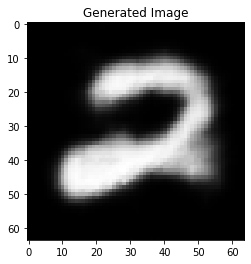

Epoch 446/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.19it/s]


Epoch [446/500], Loss: 67444.1797 (total loss), 64268.2422 (bce), 3175.9365 (kld)
Mu range: -2.7984585762023926 ~ 1.3950921297073364, Logvar range: -8.125996589660645 ~ 0.037267133593559265
tensor(8)


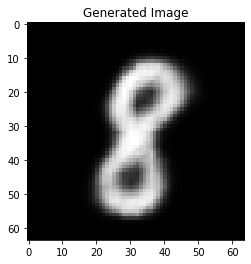

Epoch 447/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.23it/s]

Epoch [447/500], Loss: 63325.7031 (total loss), 60171.1250 (bce), 3154.5762 (kld)
Mu range: -1.1276805400848389 ~ 1.3704280853271484, Logvar range: -6.3694963455200195 ~ -0.00511830672621727
tensor(7)


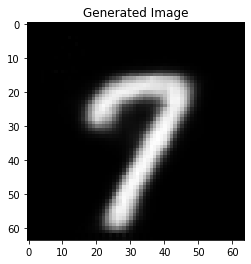

Epoch 448/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.14it/s]

Epoch [448/500], Loss: 67222.2578 (total loss), 64013.0156 (bce), 3209.2388 (kld)
Mu range: -1.8000589609146118 ~ 0.5232940316200256, Logvar range: -7.914737701416016 ~ 0.019003301858901978
tensor(5)


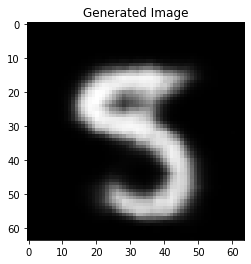

Epoch 449/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.27it/s]


Epoch [449/500], Loss: 63217.6250 (total loss), 60037.1992 (bce), 3180.4248 (kld)
Mu range: -1.795872688293457 ~ 1.656134843826294, Logvar range: -6.477410316467285 ~ 2.77860090136528e-05
tensor(4)


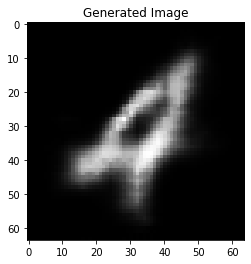

Epoch 450/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.27it/s]

Epoch [450/500], Loss: 64922.3047 (total loss), 61702.1758 (bce), 3220.1289 (kld)
Mu range: -2.3566975593566895 ~ 1.8017780780792236, Logvar range: -5.81901216506958 ~ -0.029974307864904404
tensor(5)


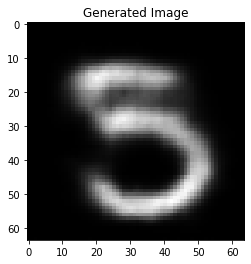

Epoch 451/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.23it/s]

Epoch [451/500], Loss: 66636.0156 (total loss), 63490.4141 (bce), 3145.6016 (kld)
Mu range: -1.203598976135254 ~ 0.9499697685241699, Logvar range: -6.078348159790039 ~ -0.007509052753448486
tensor(1)


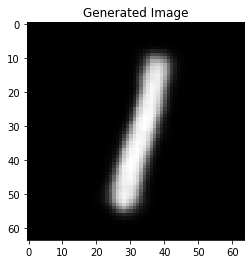

Epoch 452/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.24it/s]


Epoch [452/500], Loss: 69033.4062 (total loss), 65833.5156 (bce), 3199.8931 (kld)
Mu range: -2.288625955581665 ~ 1.1398273706436157, Logvar range: -7.721773147583008 ~ 0.03281758725643158
tensor(1)


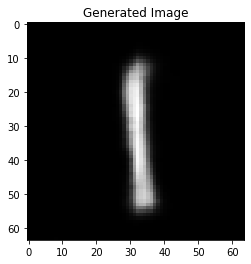

Epoch 453/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.70it/s]


Epoch [453/500], Loss: 67392.8438 (total loss), 64151.5156 (bce), 3241.3247 (kld)
Mu range: -1.5422337055206299 ~ 1.2063400745391846, Logvar range: -6.713812351226807 ~ -0.003973029553890228
tensor(9)


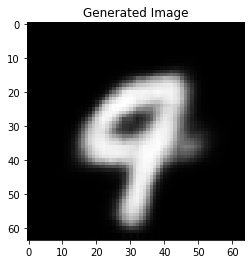

Epoch 454/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.52it/s]

Epoch [454/500], Loss: 66002.7812 (total loss), 62731.7148 (bce), 3271.0627 (kld)
Mu range: -1.8490241765975952 ~ 1.1815299987792969, Logvar range: -6.380948066711426 ~ 0.004382162354886532
tensor(1)


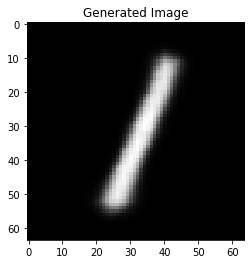

Epoch 455/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.60it/s]

Epoch [455/500], Loss: 66530.1562 (total loss), 63329.0156 (bce), 3201.1431 (kld)
Mu range: -2.603729724884033 ~ 2.9578194618225098, Logvar range: -6.312236785888672 ~ -0.0017675184644758701
tensor(4)


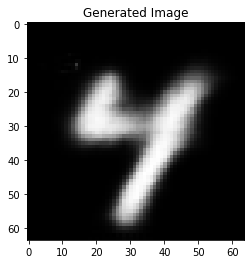

Epoch 456/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.64it/s]


Epoch [456/500], Loss: 66414.8516 (total loss), 63104.5977 (bce), 3310.2527 (kld)
Mu range: -1.7452502250671387 ~ 1.9280774593353271, Logvar range: -5.682133674621582 ~ -0.0011283941566944122
tensor(6)


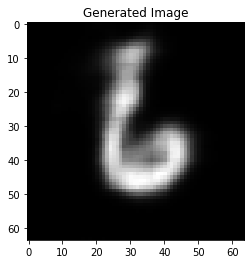

Epoch 457/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.79it/s]


Epoch [457/500], Loss: 64272.0000 (total loss), 61091.3750 (bce), 3180.6240 (kld)
Mu range: -1.3237521648406982 ~ 1.8861361742019653, Logvar range: -6.648928642272949 ~ -0.0016874028369784355
tensor(9)


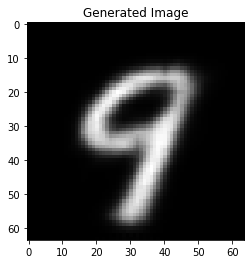

Epoch 458/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.43it/s]

Epoch [458/500], Loss: 66306.0703 (total loss), 63134.9453 (bce), 3171.1255 (kld)
Mu range: -2.406465768814087 ~ 2.1481425762176514, Logvar range: -6.970322608947754 ~ 0.012160463258624077
tensor(7)


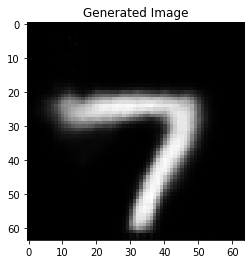

Epoch 459/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.36it/s]

Epoch [459/500], Loss: 62804.1250 (total loss), 59648.8633 (bce), 3155.2622 (kld)
Mu range: -2.3267858028411865 ~ 4.849205493927002, Logvar range: -6.489601135253906 ~ -0.024779019877314568
tensor(6)


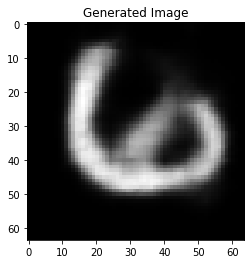

Epoch 460/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.63it/s]

Epoch [460/500], Loss: 67823.1094 (total loss), 64737.0508 (bce), 3086.0557 (kld)
Mu range: -1.3451976776123047 ~ 1.536990761756897, Logvar range: -6.62510871887207 ~ -0.005791156552731991
tensor(5)


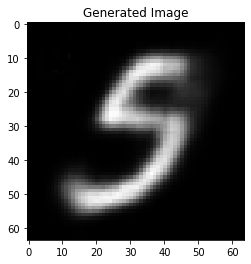

Epoch 461/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.58it/s]


Epoch [461/500], Loss: 63855.4492 (total loss), 60648.7852 (bce), 3206.6653 (kld)
Mu range: -0.9297963380813599 ~ 1.9824122190475464, Logvar range: -5.555733680725098 ~ -0.004300199914723635
tensor(8)


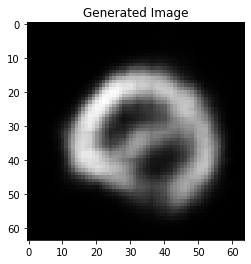

Epoch 462/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.69it/s]

Epoch [462/500], Loss: 65545.9766 (total loss), 62381.8984 (bce), 3164.0781 (kld)
Mu range: -2.9013595581054688 ~ 1.8439275026321411, Logvar range: -7.835270881652832 ~ 0.0484742671251297
tensor(6)


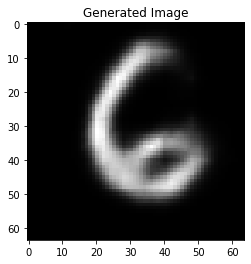

Epoch 463/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.60it/s]

Epoch [463/500], Loss: 64015.9180 (total loss), 60680.4297 (bce), 3335.4893 (kld)
Mu range: -1.296882152557373 ~ 1.0294647216796875, Logvar range: -6.878392696380615 ~ -0.006770789623260498
tensor(7)


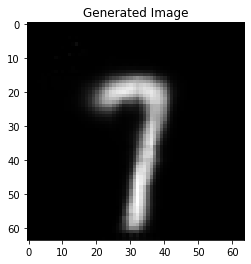

Epoch 464/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.36it/s]


Epoch [464/500], Loss: 64762.2188 (total loss), 61579.3125 (bce), 3182.9055 (kld)
Mu range: -1.5943870544433594 ~ 2.486748695373535, Logvar range: -6.57479190826416 ~ -0.0033129937946796417
tensor(2)


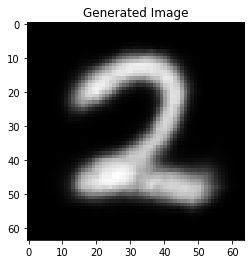

Epoch 465/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.40it/s]

Epoch [465/500], Loss: 66040.9453 (total loss), 62971.2070 (bce), 3069.7397 (kld)
Mu range: -2.0446114540100098 ~ 3.0218496322631836, Logvar range: -7.415128707885742 ~ 0.022727876901626587
tensor(2)


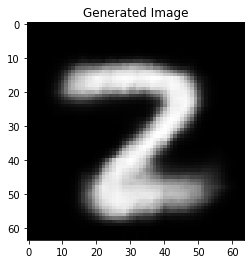

Epoch 466/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.30it/s]


Epoch [466/500], Loss: 66787.7109 (total loss), 63563.6055 (bce), 3224.1035 (kld)
Mu range: -1.5161924362182617 ~ 3.2701942920684814, Logvar range: -6.517212390899658 ~ 0.005073221400380135
tensor(4)


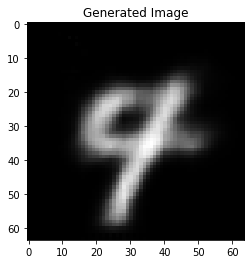

Epoch 467/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.24it/s]


Epoch [467/500], Loss: 65143.5430 (total loss), 61898.2734 (bce), 3245.2712 (kld)
Mu range: -1.3123873472213745 ~ 1.6305657625198364, Logvar range: -5.850778579711914 ~ -0.01661207526922226
tensor(3)


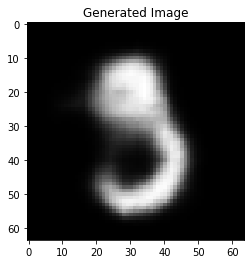

Epoch 468/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.36it/s]

Epoch [468/500], Loss: 61212.9141 (total loss), 58078.2812 (bce), 3134.6309 (kld)
Mu range: -1.5919671058654785 ~ 3.138603687286377, Logvar range: -6.557234764099121 ~ 0.01690366119146347
tensor(4)


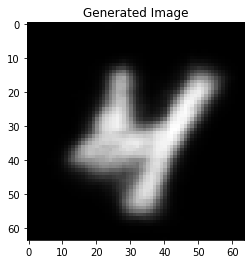

Epoch 469/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.33it/s]


Epoch [469/500], Loss: 64058.0508 (total loss), 60899.9727 (bce), 3158.0774 (kld)
Mu range: -1.5321193933486938 ~ 1.7495006322860718, Logvar range: -6.583659648895264 ~ 0.040492020547389984
tensor(1)


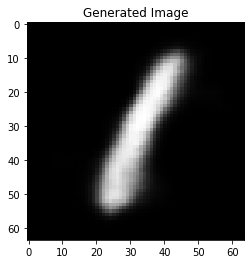

Epoch 470/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.18it/s]


Epoch [470/500], Loss: 65875.7422 (total loss), 62668.0469 (bce), 3207.6924 (kld)
Mu range: -1.7132023572921753 ~ 1.1191657781600952, Logvar range: -6.679129123687744 ~ -0.005338430404663086
tensor(5)


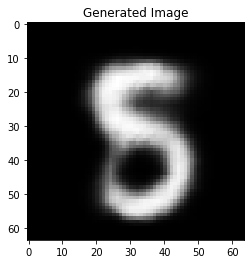

Epoch 471/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]


Epoch [471/500], Loss: 64431.8672 (total loss), 61345.9688 (bce), 3085.8997 (kld)
Mu range: -1.704495906829834 ~ 1.9966492652893066, Logvar range: -6.562982559204102 ~ 0.02928389608860016
tensor(4)


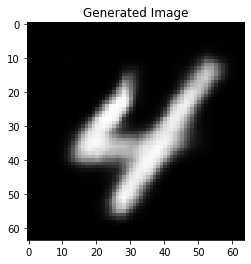

Epoch 472/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.44it/s]


Epoch [472/500], Loss: 67251.4062 (total loss), 64101.1172 (bce), 3150.2871 (kld)
Mu range: -0.9863988161087036 ~ 1.014493465423584, Logvar range: -5.981125354766846 ~ -0.009705677628517151
tensor(9)


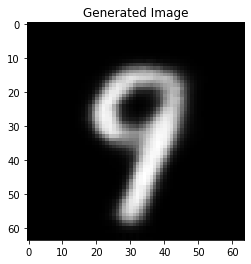

Epoch 473/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.41it/s]

Epoch [473/500], Loss: 63609.0703 (total loss), 60513.1680 (bce), 3095.9014 (kld)
Mu range: -2.406006336212158 ~ 2.048142910003662, Logvar range: -7.651368141174316 ~ -0.003447821829468012
tensor(5)


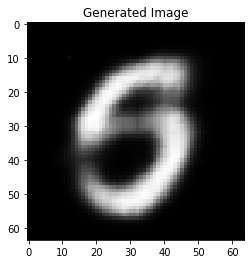

Epoch 474/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.33it/s]


Epoch [474/500], Loss: 67008.2188 (total loss), 63855.7070 (bce), 3152.5107 (kld)
Mu range: -2.1862847805023193 ~ 2.740877866744995, Logvar range: -7.368951797485352 ~ 0.017268642783164978
tensor(4)


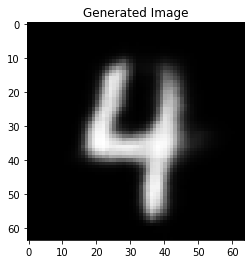

Epoch 475/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.64it/s]


Epoch [475/500], Loss: 63779.8164 (total loss), 60567.3828 (bce), 3212.4351 (kld)
Mu range: -1.0052427053451538 ~ 0.20614740252494812, Logvar range: -6.129908084869385 ~ -0.004041891545057297
tensor(5)


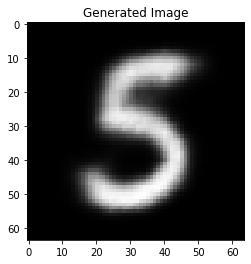

Epoch 476/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.62it/s]


Epoch [476/500], Loss: 61955.3867 (total loss), 58919.2812 (bce), 3036.1040 (kld)
Mu range: -1.7286514043807983 ~ 1.4342142343521118, Logvar range: -6.287816524505615 ~ -0.008693891577422619
tensor(0)


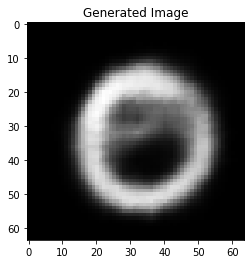

Epoch 477/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.17it/s]


Epoch [477/500], Loss: 64368.5352 (total loss), 61137.4609 (bce), 3231.0737 (kld)
Mu range: -2.156580686569214 ~ 4.557003021240234, Logvar range: -8.216167449951172 ~ 0.03267006576061249
tensor(4)


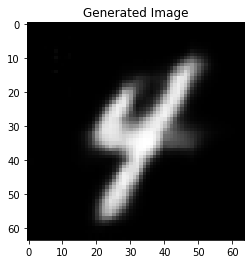

Epoch 478/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.72it/s]


Epoch [478/500], Loss: 64967.0039 (total loss), 61751.0898 (bce), 3215.9131 (kld)
Mu range: -0.9331332445144653 ~ 3.0978283882141113, Logvar range: -6.046467304229736 ~ -0.0050923824310302734
tensor(0)


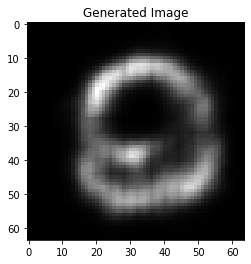

Epoch 479/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.54it/s]


Epoch [479/500], Loss: 66610.2188 (total loss), 63444.1406 (bce), 3166.0769 (kld)
Mu range: -1.324168086051941 ~ 0.9940924048423767, Logvar range: -5.975308895111084 ~ 0.0062558394856750965
tensor(0)


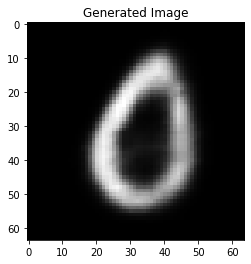

Epoch 480/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.28it/s]


Epoch [480/500], Loss: 63388.9062 (total loss), 60201.5352 (bce), 3187.3718 (kld)
Mu range: -2.065514087677002 ~ 1.5016720294952393, Logvar range: -6.088893890380859 ~ -0.015298143029212952
tensor(5)


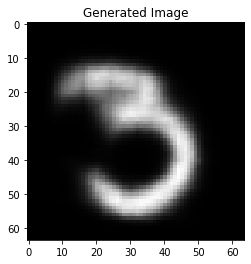

Epoch 481/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.88it/s]


Epoch [481/500], Loss: 66503.6875 (total loss), 63326.8867 (bce), 3176.8015 (kld)
Mu range: -0.4713570475578308 ~ 0.8479018211364746, Logvar range: -5.7504987716674805 ~ -0.005908749531954527
tensor(4)


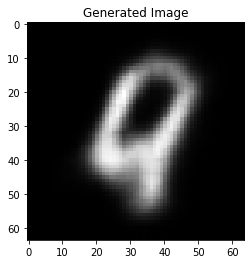

Epoch 482/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.49it/s]


Epoch [482/500], Loss: 65074.3867 (total loss), 61865.2539 (bce), 3209.1321 (kld)
Mu range: -2.1776041984558105 ~ 2.0448391437530518, Logvar range: -6.88771915435791 ~ 0.008085571229457855
tensor(6)


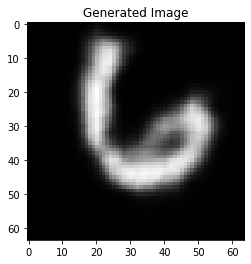

Epoch 483/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.36it/s]


Epoch [483/500], Loss: 65924.4922 (total loss), 62819.9180 (bce), 3104.5779 (kld)
Mu range: -1.1561813354492188 ~ 0.6019326448440552, Logvar range: -6.009793281555176 ~ -0.005291011184453964
tensor(9)


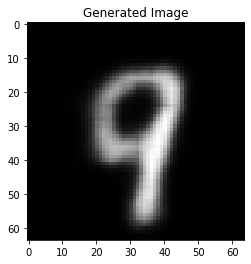

Epoch 484/500: 100%|██████████████████████████| 118/118 [00:11<00:00,  9.91it/s]


Epoch [484/500], Loss: 64524.9961 (total loss), 61381.4062 (bce), 3143.5901 (kld)
Mu range: -1.6889312267303467 ~ 3.868025541305542, Logvar range: -5.704163551330566 ~ -0.0067988308146595955
tensor(2)


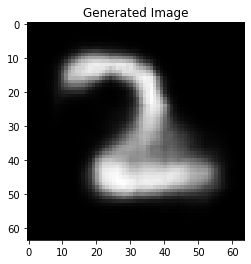

Epoch 485/500: 100%|██████████████████████████| 118/118 [00:12<00:00,  9.47it/s]

Epoch [485/500], Loss: 64165.5156 (total loss), 60913.0781 (bce), 3252.4370 (kld)
Mu range: -3.606762647628784 ~ 2.1531331539154053, Logvar range: -5.949127674102783 ~ -0.002417712938040495
tensor(5)


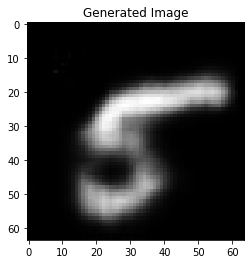

Epoch 486/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.29it/s]


Epoch [486/500], Loss: 64845.0586 (total loss), 61640.3242 (bce), 3204.7327 (kld)
Mu range: -2.776298761367798 ~ 0.2683407664299011, Logvar range: -7.317514896392822 ~ 0.013512931764125824
tensor(5)


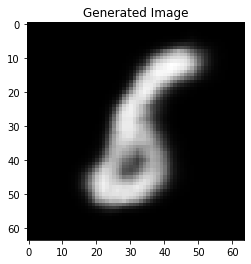

Epoch 487/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.43it/s]


Epoch [487/500], Loss: 64670.8789 (total loss), 61529.5234 (bce), 3141.3545 (kld)
Mu range: -1.0457738637924194 ~ 2.7586169242858887, Logvar range: -6.564099311828613 ~ -0.004613238386809826
tensor(9)


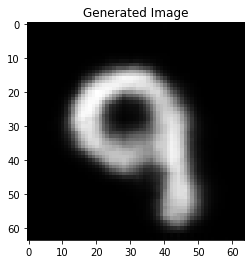

Epoch 488/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 11.00it/s]

Epoch [488/500], Loss: 64822.0234 (total loss), 61731.8906 (bce), 3090.1338 (kld)
Mu range: -3.0777618885040283 ~ 0.9314156770706177, Logvar range: -6.846575736999512 ~ 0.02475956827402115
tensor(6)


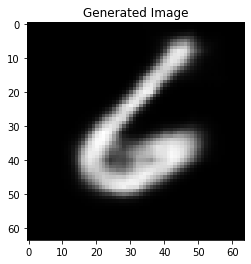

Epoch 489/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.57it/s]

Epoch [489/500], Loss: 63293.8203 (total loss), 59961.7578 (bce), 3332.0608 (kld)
Mu range: -1.7289652824401855 ~ 1.888444185256958, Logvar range: -7.038230895996094 ~ -0.003455732949078083
tensor(4)


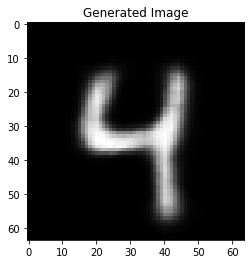

Epoch 490/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.42it/s]


Epoch [490/500], Loss: 65431.3164 (total loss), 62163.2578 (bce), 3268.0576 (kld)
Mu range: -1.5996568202972412 ~ 2.1170339584350586, Logvar range: -6.689460754394531 ~ 0.023725293576717377
tensor(0)


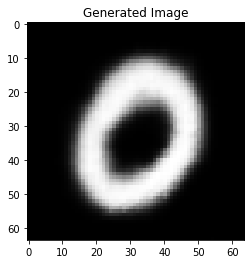

Epoch 491/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.61it/s]

Epoch [491/500], Loss: 60451.8828 (total loss), 57208.1641 (bce), 3243.7188 (kld)
Mu range: -1.485435128211975 ~ 1.2767653465270996, Logvar range: -7.1558332443237305 ~ 0.010422494262456894
tensor(4)


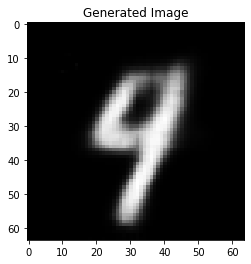

Epoch 492/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.64it/s]


Epoch [492/500], Loss: 63713.8594 (total loss), 60530.7695 (bce), 3183.0894 (kld)
Mu range: -1.772236704826355 ~ 1.1519979238510132, Logvar range: -7.546322345733643 ~ 0.040644094347953796
tensor(1)


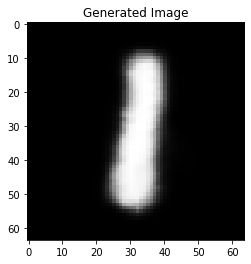

Epoch 493/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.31it/s]


Epoch [493/500], Loss: 63186.1758 (total loss), 60077.4844 (bce), 3108.6931 (kld)
Mu range: -0.9082415699958801 ~ 0.9859714508056641, Logvar range: -5.907125473022461 ~ -0.010124154388904572
tensor(4)


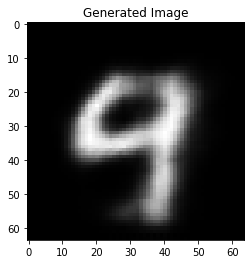

Epoch 494/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.45it/s]

Epoch [494/500], Loss: 65344.4102 (total loss), 62183.2031 (bce), 3161.2058 (kld)
Mu range: -1.570172667503357 ~ 1.2722783088684082, Logvar range: -7.351746082305908 ~ -0.0033075211104005575
tensor(8)


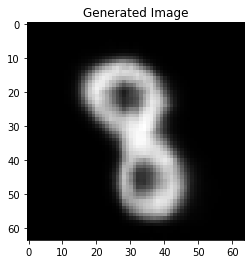

Epoch 495/500: 100%|██████████████████████████| 118/118 [00:10<00:00, 10.97it/s]


Epoch [495/500], Loss: 64316.5039 (total loss), 61071.0195 (bce), 3245.4827 (kld)
Mu range: -0.9820219278335571 ~ 2.1387338638305664, Logvar range: -5.907216548919678 ~ -0.008503714576363564
tensor(6)


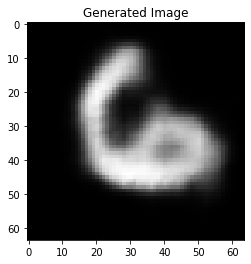

Epoch 496/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.27it/s]

Epoch [496/500], Loss: 63586.4141 (total loss), 60375.7500 (bce), 3210.6655 (kld)
Mu range: -1.184779405593872 ~ 2.0977416038513184, Logvar range: -5.792211055755615 ~ -0.021488327533006668
tensor(3)


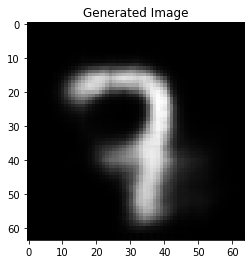

Epoch 497/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.49it/s]


Epoch [497/500], Loss: 63202.7031 (total loss), 60036.7461 (bce), 3165.9580 (kld)
Mu range: -1.5741667747497559 ~ 1.1932814121246338, Logvar range: -6.893707275390625 ~ -0.007983721792697906
tensor(8)


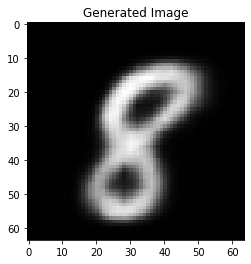

Epoch 498/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.44it/s]


Epoch [498/500], Loss: 65300.2656 (total loss), 62161.4375 (bce), 3138.8267 (kld)
Mu range: -0.7765790820121765 ~ 1.0420781373977661, Logvar range: -5.579916000366211 ~ 0.004832562990486622
tensor(4)


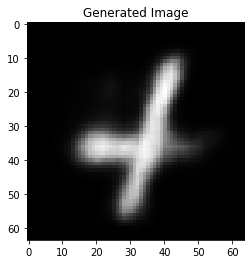

Epoch 499/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.62it/s]


Epoch [499/500], Loss: 60741.4492 (total loss), 57443.0352 (bce), 3298.4128 (kld)
Mu range: -1.3597742319107056 ~ 1.1509424448013306, Logvar range: -6.378409385681152 ~ -0.0153275728225708
tensor(3)


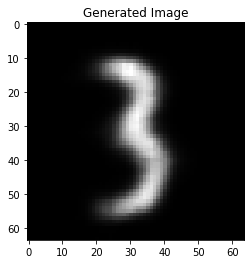

Epoch 500/500: 100%|██████████████████████████| 118/118 [00:11<00:00, 10.39it/s]

Epoch [500/500], Loss: 63298.0469 (total loss), 60008.6797 (bce), 3289.3674 (kld)
Mu range: -0.9895765781402588 ~ 0.8288590312004089, Logvar range: -6.248412132263184 ~ 0.001624935306608677
tensor(9)


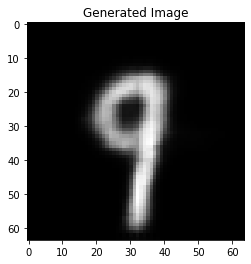

In [8]:
epochs = 500

for epoch in range(epochs):
    for idx, (images, label) in enumerate(tqdm(dataloader, desc=f'Epoch {epoch + 1}/{epochs}')):
        optimizer.zero_grad()

        images = images.float().to(device) # train image (BATCH_SIZE, 1, 64, 64)
        recon_images, mu, logvar = model(images)
        
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar) # loss calculation
        
        if torch.isnan(loss).any(): # nan loss is not acceptable
            print("NaN value in loss!")
            break

        loss.backward()
        optimizer.step()

    scheduler.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f} (total loss), {bce.item():.4f} (bce), {abs(kld.item()):.4f} (kld)")
    print(f"Mu range: {torch.min(mu[0])} ~ {torch.max(mu[0])}, Logvar range: {torch.min(logvar[0])} ~ {torch.max(logvar[0])}")

    # Print label and plot generated image
    print(label[0])
    plt.imshow(recon_images[0].permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
    plt.title("Generated Image")
    plt.show() 


In [47]:
# epochs = 500

# for epoch in range(epochs):
#     for idx, (images, label) in enumerate(tqdm(dataloader, desc=f'Epoch {epoch + 1}/{epochs}')):
#         optimizer.zero_grad()

#         images = images.float().to(device) # train image (BATCH_SIZE, 1, 64, 64)
#         recon_images, mu, logvar = model(images)
        
#         loss, bce, kld = loss_fn(recon_images, images, mu, logvar) # loss calculation
        
#         if torch.isnan(loss).any(): # nan loss is not acceptable
#             print("NaN value in loss!")
#             break

#         loss.backward()
#         optimizer.step()

#     scheduler.step()

#     print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f} (total loss), {bce.item():.4f} (bce), {abs(kld.item()):.4f} (kld)")
#     print(f"Mu range: {torch.min(mu[0])} ~ {torch.max(mu[0])}, Logvar range: {torch.min(logvar[0])} ~ {torch.max(logvar[0])}")

# torch.save(model, './500epochs_KLD*30.pth')